#### Simulating Oliver's consolidation task

Consolidation can be thought of as training a neocortical generative / predictive model on replayed hippocampal memories. For sequential data, the generative model could correspond to an autoregressive sequence model like GPT-2 that learns to predict the next item in the sequence (by minimising the prediction error on sequences from the training data). The stimuli for Oliver's task can be represented as sequences of form 'START: yellow fruit, STOP: red, REWARD: animal, SEQUENCE: yellow fruit (-1), green animal (2), red animal (2)', which makes it straightforward to train GPT-2.

This notebook simulates the task as follows:
* Pre-train model so that it learns the *rules* of task
* Train on stimuli for task, representing consolidation
* Compare generative model accept / reject performance before and after consolidation

#### Details

Pre-train model on arbitrary stimuli, to model learning the rules of the task. After this stage of training, the model can be given a prompt with randomly chosen stimuli / conditions, e.g. 'START: blue chair, STOP: sad, REWARD: bug, SEQUENCE:', and generate a sequence consistent with the rules, e.g. 'blue chair (-1), sad bug (2)'. But the model knows nothing about the task stimuli or their order. This is supposed to be equivalent to the participant at the point they pass the rules quiz, prior to experiencing the stimuli.

I ran the simulation for reward and transition revaluation separately (so there was enough data in each case - I could do both at once though, there'd just be less data to train on):
* Reward revaluation: train on 2/3 reward categories in each trial, test on held-out reward category. Repeat n times, each time with a random stimuli order and a random reward condition.
* Transition revaluation: train on 2/3 stop colours in each trial, test on held-out transition category. Repeat n times, each time with a random stimuli order and a random stop condition.

Note that this is more training data than in Oliver's task, as discussed.

The accept / reject task is modelled as follows:
* Get the predicted sequence from the model given an input of form 'START: yellow animal, STOP: red, REWARD: animal, SEQUENCE:'
* Extract the predicted rewards (any numbers in round brackets)
* If predicted reward sum > 0, accept, and if predicted reward sum <= 0, reject
* Calculate the accuracy of the accept / reject decisions by comparing with the real sequences
* There are 81/3 = 27 test sequences in each case. Of these 9 are of length 1 (with the stop condition met by the start stimulus). I excluded these as these don't require any learning of the sequence to predict the reward.
* As described above, there were multiple trials for each of the reward and transition revaluation tasks.

#### Results

The result is that the generative model (pre-trained on the rules of the task) learns the sequence of stimuli through consolidation, so that it can do reward and transition revaluation fairly well. 

I haven't modelled the hippocampal memory prior to consolidation, I've just shown that the generative model can learn the tasks (through causal sequence modelling, i.e. 'prediction error minimisation' on stored 'memories'). As discussed you might expect reward revaluation soon after encoding to be easier - you can retrieve a (non-consolidated) sequence from HPC then infer the rewards for a different reward category, whereas transition revaluation requires knowledge of transition probabilities to be extracted from the memories.

#### Installation / imports:

In [ ]:
! pip install git+https://github.com/huggingface/transformers --upgrade
! pip install accelerate evaluate wonderwords simpletransformers --upgrade
! pip install huggingface_hub --upgrade

In [1]:
import random
import pandas as pd
import networkx as nx
import logging
from random import shuffle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import random
import string
import os
import re
import glob
import torch
from wonderwords import RandomWord
import os
import gc
import pickle
from sklearn.linear_model import LinearRegression
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from scipy.stats import pearsonr
import math

os.environ["WANDB_DISABLED"] = "true"

Define a class for loading a model from a directory, and generating outputs given some input:

In [191]:
class GPT:

    def __init__(self, base_model):
        self.tokenizer = GPT2Tokenizer.from_pretrained(base_model)
        self.model = GPT2LMHeadModel.from_pretrained(base_model)

    def continue_input(self, input_sequence, max_length=200, num_return_sequences=1, no_repeat_ngram_size=0,
                       do_sample=False, temperature=0.7, num_beams=1):
        
        input_ids = self.tokenizer.encode(input_sequence, return_tensors='pt')
        max_length = len(input_ids[0]) + 100
        print(max_length)          

        # Generate text
        output = self.model.generate(
            input_ids,
            max_length=max_length,
            num_return_sequences=num_return_sequences,
            num_beams=num_beams,
            no_repeat_ngram_size=no_repeat_ngram_size,
            do_sample=do_sample,
            temperature=temperature,
        )

        # Decode the output
        sequence = output[0].tolist()
        text = self.tokenizer.decode(sequence)
        return text

#### Pre-train model on arbitrary stimuli to learn rules of task

The get_random_stimuli() function generates a random set of nouns and adjectives (3 for each by default). The stimuli are all possible combinations, e.g. for the adjectives ABC and nouns DEF, the stimuli are AD, AE, AF, BD, etc. The get_stimuli() function is the equivalent but for Oliver's task stimuli. 

The get_reward() function predicts reward points for a sequence of stimuli. Given a list of stimuli in random order, the stimulus at which the sequence starts, the adjective at which the sequence ends, and the noun that gives 2 points of reward, the function returns a list of stimuli and their rewards, e.g. ['small chair (2)', 'angry chair (2)', 'metal spoon (-1)'].

In [3]:
def get_random_stimuli(n=3):
    r = RandomWord()
    adjectives = [r.word(include_parts_of_speech=["adjectives"]).replace(" ", "_") for _ in range(n)]
    nouns = [r.word(include_parts_of_speech=["nouns"]).replace(" ", "_") for _ in range(n)]

    stimuli = []
    for i, noun in enumerate(nouns):
        for adjective in adjectives:
            stimuli.append(f"{adjective} {noun}")

    return stimuli, nouns, adjectives

def get_stimuli():
    stimuli = ["red animal", 
               "green animal", 
               "yellow animal", 
               "red vehicle", 
               "green vehicle", 
               "yellow vehicle", 
               "red fruit", 
               "green fruit", 
               "yellow fruit"]
    
    objects = [word.split()[1] for word in stimuli]
    colours = list(set([word.split()[0] for word in stimuli]))
    return stimuli, objects, colours

def shuffle_stimuli(stimuli):
    random.shuffle(stimuli)
    return stimuli

def get_reward(stimuli, start, stop, reward):
    """Predict reward points for a sequence of stimuli.
    
    Args:
        stimuli (list): List of stimuli in random order.
        start (str): Object at which the sequence starts.
        stop (str): Colour at which the sequence ends.
        reward (str): Category of object that brings 2 points of reward.

    Returns:
        list of str: Reward points descriptions for the sequence.
    """
    points = []
    sequence_started = False
    
    index = 0  # start index
    while True:
        stim = stimuli[index % len(stimuli)]
        colour, obj = stim.split()

        if not sequence_started:
            if stim == start:
                sequence_started = True
            index += 1
            continue
        else:
            if obj == reward:
                points.append(f"{stim} (2)")
            else:
                points.append(f"{stim} (-1)")
    
            if colour == stop:
                break

        index += 1  # move to the next stimulus

    return points

We now generate training and test data for the pre-training.

In [ ]:
training_strs = []
for i in range(1000):
    stimuli, objects, colours = get_random_stimuli()
    stimuli = shuffle_stimuli(stimuli)
    print(f"Stimuli: {stimuli}")
    for stim in stimuli:
        for colour in colours:
            for obj in objects:
                start = stim
                stop = colour
                reward = obj
                instruction_str = f"START: {start}, STOP: {stop}, REWARD: {reward},"
                points = get_reward(stimuli, start, stop, reward)
                training_str = instruction_str + " SEQUENCE: " + ", ".join(points)
                training_strs.append(training_str)

testing_strs = []
for i in range(10):
    stimuli, objects, colours = get_random_stimuli()
    stimuli = shuffle_stimuli(stimuli)
    print(f"Stimuli: {stimuli}")
    for stim in stimuli:
        for colour in colours:
            for obj in objects:
                start = stim
                stop = colour
                reward = obj
                instruction_str = f"START: {start}, STOP: {stop}, REWARD: {reward},"
                points = get_reward(stimuli, start, stop, reward)
                testing_str = instruction_str + " SEQUENCE: " + ", ".join(points)
                testing_strs.append(testing_str)

print(f"{len(training_strs)} sequences of arbitrary stimuli generated for pre-training.")

In [ ]:
orig_training_strs = training_strs

The function below runs a script to fine-tune a gpt-2 model on the arbitrary stimuli.

The name_or_path argument is which model to fine-tune from. In the pre-training stage, this will be set to 'gpt2'.

In [4]:
def train_model_script(name_or_path='rule_model', 
                       num_epochs=3,
                       output_dir='./clm_script',
                       save_steps=100,
                       lr=5e-05 ):
    torch.cuda.empty_cache()
    gc.collect()
    ! python ./run_clm.py \
        --model_name_or_path {name_or_path} \
        --train_file {os.path.join(output_dir, 'train.txt')} \
        --validation_file {os.path.join(output_dir, 'train.txt')} \
        --per_device_train_batch_size 1 \
        --per_device_eval_batch_size 1 \
        --do_train \
        --do_eval \
        --output_dir {output_dir} \
        --overwrite_output_dir \
        --num_train_epochs {num_epochs} \
        --save_strategy 'steps' \
        --save_steps {save_steps} \
        --learning_rate {lr}       
    

Shuffle the data, write it to train.txt and test.txt files, and train gpt2:

In [ ]:
!rm -rf rule_model
!mkdir rule_model

text_file = open("rule_model/train.txt", "w")
n = text_file.write('\n'.join(training_strs))
text_file.close()

text_file = open("rule_model/test.txt", "w")
n = text_file.write('\n'.join(testing_strs))
text_file.close()

train_model_script(name_or_path='gpt2', output_dir='rule_model', num_epochs=3, save_steps=2000)

Test the output with some random start / stop / reward conditions not seen in the training data to see if it's learned the rules:

In [5]:
model = GPT(base_model='rule_model')

Can the model generalise the rules to new stimuli?

In [6]:
out = model.continue_input("START: blue table, STOP: blue, REWARD: bug, SEQUENCE:", do_sample=False)
print(out)

/Users/eleanorspens/Documents/PhD Code/algonauts/algovenv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


START: blue table, STOP: blue, REWARD: bug, SEQUENCE: blue table (-1)
START: blue table, STOP: blue, REWARD: table, SEQUENCE: blue table (2)
START: blue table, STOP: blue, REWARD: bug, SEQUENCE: blue table (-1)
START: blue table, STOP: blue, REWARD: table, SEQUENCE: blue table (2)
START: blue table, STOP: wistful, REWARD: bug, SEQUENCE: blue table (-1), wistful bug (2)
START: blue table, STOP: wistful, REWARD: table, SEQUENCE: blue table (2), wistful bug (-1)
START: blue table, STOP: wistful, REWARD: bug, SEQUENCE: blue table (-1), wistful bug (2


In [7]:
# def get_gen_replay_seq():
#     out = model.continue_input("START:", do_sample=True)
#     return out[:out.index('\n')]

# orig_training_strs = [get_gen_replay_seq() for i in range(10000)]
# orig_training_strs[0:10]

#### Simulate the task

The simulate_task() function runs one trial, for either the transition or reward revaluation task (as set by the leave_out argument):
* First it clears down the model directory.
* Then it shuffles the stimuli for the trial into a random order.
* Then it generates all possible start / stop / reward combinations and gets the sequence for each from the get_reward() function.
* As above, it turns these into strings with format f"START: ..., STOP: ..., REWARD: ..., SEQUENCE: ..."
* In the reward revaluation case, we train on 2/3 of the reward categories in each trial, and test on a held-out reward category. In the transition revaluation case, we train on 2/3 of the stop colours in each trial, and test on a held-out transition category. 
* The training and test data is saved to files, and a model is trained by calling the train_model_script() 

In [8]:
def simulate_task(seed=0, num_new=1000, num_orig=1000, num_epochs=3, include_negatives='none'):
    random.seed(seed)
    training_strs = []
    
    # get stimuli etc and shuffle them
    stimuli, objects, colours = get_stimuli()
    stimuli = shuffle_stimuli(stimuli)
    print(f"Stimuli: {stimuli}")
    
    for stim in stimuli:
        for colour in colours:
            for obj in objects:
                start = stim
                stop = colour
                reward = obj
                instruction_str = f"START: {start}, STOP: {stop}, REWARD: {reward},"
                points = get_reward(stimuli, start, stop, reward)
                training_str = instruction_str + " SEQUENCE: " + ", ".join(points)
                training_strs.append(training_str)

    training_strs = list(set(training_strs))

    random_category = random.choice(objects)
    random_colour = random.choice(colours)
    train_set = [s for s in training_strs if f'REWARD: {random_category}' in s and f'STOP: {random_colour}' in s]
    test_set_reward = [s for s in training_strs if f'REWARD: {random_category}' not in s and f'STOP: {random_colour}' in s]
    test_set_transition = [s for s in training_strs if f'REWARD: {random_category}' in s and f'STOP: {random_colour}' not in s]
    test_set_both = [s for s in training_strs if f'REWARD: {random_category}' not in s and f'STOP: {random_colour}' not in s]

    # oversampling trick to avoid overfitting to sequence order
    train_set = np.random.choice(train_set, num_new).tolist()

    output_dir = f'clm_script_{seed}'
    ! rm -rf {output_dir}
    ! mkdir {output_dir}
    
    trial_info = {'stimuli': stimuli, 'train_reward': random_category, 'train_stop': random_colour}
    with open(os.path.join(output_dir, 'trial_info.pkl'), 'wb') as handle:
        pickle.dump(trial_info, handle)

    text_file = open(os.path.join(output_dir, 'train.txt'), "w")
    n = text_file.write('\n'.join(train_set))
    text_file.close()

    text_file = open(os.path.join(output_dir, 'test_reward.txt'), "w")
    n = text_file.write('\n'.join(test_set_reward))
    text_file.close()

    text_file = open(os.path.join(output_dir, 'test_transition.txt'), "w")
    n = text_file.write('\n'.join(test_set_transition))
    text_file.close()

    text_file = open(os.path.join(output_dir, 'test_both.txt'), "w")
    n = text_file.write('\n'.join(test_set_both))
    text_file.close()

    train_model_script(name_or_path='rule_model', 
                       num_epochs=num_epochs, 
                       output_dir=output_dir,
                       save_steps=100)

Reward and transition revaluation test functions:

In [9]:
def get_accept_reject_choice(seq):
    seq = seq[seq.index('SEQUENCE:') + len('SEQUENCE:'):]
    if 'START' in seq:
        seq = seq[0:seq.index('START')]
    print(seq)
    try:
        numbers = re.findall(r'\([A-Za-z0-9_-]+\)', seq)
        numbers = [int(num.replace('(', '').replace(')', '')) for num in numbers]
        print(numbers)
    except Exception as e:
        "Couldn't convert to int, setting list to []"
        numbers = []
    if sum(numbers) > 0:
        return 1
    elif sum(numbers) < 0:
        return 0
    elif sum(numbers) == 0:
        return 0.5

def test_revaluation(seqs, model):
    result_bools = []
    result_preds = []
    for seq in seqs:
        print("Get true accept / reject:")
        true_a_v_r = get_accept_reject_choice(seq)
        print(true_a_v_r)
        input_str = seq[0:seq.index('SEQUENCE:') + len('SEQUENCE:')]
        continuation = model.continue_input(input_str, do_sample=False)
        print("Get pred accept / reject:")
        pred_a_v_r = get_accept_reject_choice(continuation)
        print(pred_a_v_r)
        result_preds.append(pred_a_v_r)
        if true_a_v_r == pred_a_v_r:
            print("match")
            result_bools.append(1)
        else:
            print("no match")
            result_bools.append(0)
    return (result_bools, result_preds)

def get_len(seq):
    return seq.count(',') - 2

def get_mean(val):
    return np.mean(val[0])

def num_sort(test_string):
    return list(map(int, re.findall(r'\d+', test_string)))[0]

def test_consolidation(base_dir, task_type='transition', both=True):
    print(task_type)
    print("------------------------")
    checkpoints = glob.glob(os.path.join(base_dir, 'checkpoint*'))
    model_dirs = ['rule_model'] + checkpoints 
    print(model_dirs)

    with open(os.path.join(base_dir, f'test_{task_type}.txt')) as f:
        seqs = f.readlines()
        seqs = [s.replace('\n', '') for s in seqs]
        seqs = sorted(list(set(seqs)))

    results = {}
    for model_dir in model_dirs:
        print(model_dir)
        model = GPT(base_model=model_dir)
        results[os.path.basename(model_dir)] = test_revaluation(seqs, model)
    return results

In [ ]:
# with open('thesis_data/results_reward.pkl', 'rb') as f:
#     all_results = pickle.load(f)

# df = pd.DataFrame(all_results)
# df

In [126]:
def get_data_from_file(file_name):
    with open(file_name, 'rb') as f:
        all_results = pickle.load(f)

    df = pd.DataFrame(all_results)
    df = df.dropna(axis='rows')

    for col in df.columns:
        df[col] = df[col].apply(get_mean)

    stats_to_plot = df.describe()
    
    return stats_to_plot

def get_step_num(string):
    # Regular expression to match 'checkpoint-' followed by one or more digits
    match = re.match(r'checkpoint-(\d+)', string)
    
    # If there's a match and it's at the start of the string
    if match and match.start() == 0:
        return int(match.group(1))
    else:
        return 0
    
import matplotlib.pyplot as plt
import numpy as np

def produce_plot(description_string='-'):
    files = ['results_reward.pkl', 'results_transition.pkl', 'results_both.pkl']
    labels = ['Reward revaluation', 'Transition revaluation', 'Both revaluation']
    
    plt.figure(figsize=(4, 3))  # Set figure size
    
    for ind, file in enumerate(files):
        stats_to_plot = get_data_from_file(file) 
        cols = stats_to_plot.columns.tolist()
        
        xs = [get_step_num(c) for c in cols]  # Assuming this function is defined elsewhere
        ys = [stats_to_plot[c]['mean'] for c in cols]
        yerrs = [stats_to_plot[c]['std']/math.sqrt(stats_to_plot[c]['count']) for c in cols]  # Standard deviation for error bars
        sorted_pairs = sorted(zip(xs, ys, yerrs), key=lambda x: x[0])  # Sort by xs
        sorted_xs, sorted_ys, sorted_yerrs = zip(*sorted_pairs)
        
        # Use errorbar instead of plot to include error margins
        plt.errorbar(sorted_xs, 
                     sorted_ys, 
                     yerr=sorted_yerrs,  # Specify the error bars
                     marker='o', 
                     capsize=5,
                     label=labels[ind])
    
    plt.yticks(np.linspace(0, 1, num=11))
    plt.ylabel('Accept / reject accuracy')
    plt.xlabel('Training steps')
    # plt.title('Transition and reward revaluation')
    plt.legend()
    plt.savefig(f'revaluation over time {description_string}.png', dpi=500, bbox_inches='tight')
    plt.show()


In [ ]:

for num_new in [1000]:
    for num_epochs in [20]:
        # for i in range(5):
        #     simulate_task(seed=i, 
        #                   num_new=num_new, 
        #                   num_epochs=num_epochs)
        
        all_results_transition = []
        all_results_reward = []
        all_results_both = []
        
        for i in range(5):
            base_dir = f'clm_script_{i}'
            
            results = test_consolidation(base_dir, task_type='transition')
            all_results_transition.append(results)
        
            results = test_consolidation(base_dir, task_type='reward')
            all_results_reward.append(results)
        
            results = test_consolidation(base_dir, task_type='both')
            all_results_both.append(results)
        
        with open('results_transition.pkl', 'wb') as f:
            pickle.dump(all_results_transition, f)
        with open('results_reward.pkl', 'wb') as f:
            pickle.dump(all_results_reward, f)
        with open('results_both.pkl', 'wb') as f:
            pickle.dump(all_results_both, f)
        
        produce_plot(description_string=f'{num_new}-{num_epochs}')
        

transition
------------------------
['rule_model', 'clm_script_0/checkpoint-500', 'clm_script_0/checkpoint-100', 'clm_script_0/checkpoint-200', 'clm_script_0/checkpoint-300', 'clm_script_0/checkpoint-400']
rule_model


/Users/eleanorspens/Documents/PhD Code/algonauts/algovenv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get true accept / reject:
 red vehicle (-1), green vehicle (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green meatloaf (-1)

[-1]
0
match
Get true accept / reject:
 red vehicle (-1), green vehicle (-1), yellow animal (-1)
[-1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow meatloaf (-1)

[-1]
0
match
Get true accept / reject:
 yellow vehicle (-1), green animal (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green juice (-1)

[-1]
0
match
Get true accept / reject:
 yellow vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow grapefruit (2)

[2]
1
no match
Get true accept / reject:
 yellow animal (-1), red animal (-1), yellow fruit (2), red fruit (2), green fruit (2)
[-1, -1, 2, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (-1)

[-1]
0
no match
Get true accept / reject:
 yellow animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1)

[-1]
0
match
Get true accept / reject:
 yellow fruit (2), red fruit (2), green fruit (2)
[2, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green meatloaf (-1)

[-1]
0
no match
Get true accept / reject:
 yellow fruit (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow meatloaf (-1)

[-1]
0
no match
Get true accept / reject:
 green fruit (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green juice (-1)

[-1]
0
no match
Get true accept / reject:
 green fruit (2), yellow vehicle (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow grapefruit (2)

[2]
1
match
Get true accept / reject:
 green vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (-1)

[-1]
0
match
Get true accept / reject:
 green vehicle (-1), yellow animal (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1)

[-1]
0
match
Get true accept / reject:
 red animal (-1), yellow fruit (2), red fruit (2), green fruit (2)
[-1, 2, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow meatloaf (-1), yellow meatloaf (-1), yellow meatloaf (-1), green meatloaf (-1)

[-1, -1, -1, -1]
0
no match
Get true accept / reject:
 red animal (-1), yellow fruit (2)
[-1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow meatloaf (-1)

[-1]
0
no match
Get true accept / reject:
 red fruit (2), green fruit (2)
[2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow grapefruit (2), yellow grapefruit (2), yellow grapefruit (2), green grapefruit (2)

[2, 2, 2, 2]
1
match
Get true accept / reject:
 red fruit (2), green fruit (2), yellow vehicle (-1)
[2, 2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow grapefruit (2)

[2]
1
match
Get true accept / reject:
 green animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1), yellow vehicle (-1), green vehicle (-1)

[-1, -1, -1]
0
match
Get true accept / reject:
 green animal (-1), red vehicle (-1), green vehicle (-1), yellow animal (-1)
[-1, -1, -1, -1]
0
Get pred accept / reject:
 yellow vehicle (-1)

[-1]
0
match
clm_script_0/checkpoint-500


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get true accept / reject:
 red vehicle (-1), green vehicle (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (-1)

[-1]
0
match
Get true accept / reject:
 red vehicle (-1), green vehicle (-1), yellow animal (-1)
[-1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (-1)

[-1]
0
match
Get true accept / reject:
 yellow vehicle (-1), green animal (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1), green animal (-1)

[-1, -1]
0
match
Get true accept / reject:
 yellow vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1)

[-1]
0
match
Get true accept / reject:
 yellow animal (-1), red animal (-1), yellow fruit (2), red fruit (2), green fruit (2)
[-1, -1, 2, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red animal (-1)

[-1, -1]
0
no match
Get true accept / reject:
 yellow animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1)

[-1]
0
match
Get true accept / reject:
 yellow fruit (2), red fruit (2), green fruit (2)
[2, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (2), red fruit (2)

[2, 2]
1
match
Get true accept / reject:
 yellow fruit (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (2)

[2]
1
match
Get true accept / reject:
 green fruit (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (2)

[2]
1
match
Get true accept / reject:
 green fruit (2), yellow vehicle (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (2), yellow vehicle (-1)

[2, -1]
1
match
Get true accept / reject:
 green vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (-1)

[-1]
0
match
Get true accept / reject:
 green vehicle (-1), yellow animal (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (-1), yellow animal (-1)

[-1, -1]
0
match
Get true accept / reject:
 red animal (-1), yellow fruit (2), red fruit (2), green fruit (2)
[-1, 2, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1)

[-1]
0
no match
Get true accept / reject:
 red animal (-1), yellow fruit (2)
[-1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1)

[-1]
0
no match
Get true accept / reject:
 red fruit (2), green fruit (2)
[2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (2)

[2]
1
match
Get true accept / reject:
 red fruit (2), green fruit (2), yellow vehicle (-1)
[2, 2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (2)

[2]
1
match
Get true accept / reject:
 green animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1)

[-1]
0
match
Get true accept / reject:
 green animal (-1), red vehicle (-1), green vehicle (-1), yellow animal (-1)
[-1, -1, -1, -1]
0
Get pred accept / reject:
 green animal (-1), red vehicle (-1)

[-1, -1]
0
match
clm_script_0/checkpoint-100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get true accept / reject:
 red vehicle (-1), green vehicle (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1), green animal (-1)

[-1, -1]
0
match
Get true accept / reject:
 red vehicle (-1), green vehicle (-1), yellow animal (-1)
[-1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1)

[-1]
0
match
Get true accept / reject:
 yellow vehicle (-1), green animal (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1), green animal (-1)

[-1, -1]
0
match
Get true accept / reject:
 yellow vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (-1), yellow animal (-1)

[-1, -1]
0
match
Get true accept / reject:
 yellow animal (-1), red animal (-1), yellow fruit (2), red fruit (2), green fruit (2)
[-1, -1, 2, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red animal (-1)

[-1, -1]
0
no match
Get true accept / reject:
 yellow animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1), red vehicle (-1)

[-1, -1]
0
match
Get true accept / reject:
 yellow fruit (2), red fruit (2), green fruit (2)
[2, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1), green animal (-1)

[-1, -1]
0
no match
Get true accept / reject:
 yellow fruit (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (2), yellow vehicle (-1)

[2, -1]
1
match
Get true accept / reject:
 green fruit (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1), green animal (-1)

[-1, -1]
0
no match
Get true accept / reject:
 green fruit (2), yellow vehicle (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (2), yellow vehicle (-1)

[2, -1]
1
match
Get true accept / reject:
 green vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red animal (-1)

[-1, -1]
0
match
Get true accept / reject:
 green vehicle (-1), yellow animal (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (-1), yellow animal (-1)

[-1, -1]
0
match
Get true accept / reject:
 red animal (-1), yellow fruit (2), red fruit (2), green fruit (2)
[-1, 2, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1), green animal (-1)

[-1, -1]
0
no match
Get true accept / reject:
 red animal (-1), yellow fruit (2)
[-1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (2)

[2]
1
match
Get true accept / reject:
 red fruit (2), green fruit (2)
[2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (-1)

[-1]
0
no match
Get true accept / reject:
 red fruit (2), green fruit (2), yellow vehicle (-1)
[2, 2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (2), red vehicle (-1)

[2, -1]
1
match
Get true accept / reject:
 green animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1)

[-1]
0
match
Get true accept / reject:
 green animal (-1), red vehicle (-1), green vehicle (-1), yellow animal (-1)
[-1, -1, -1, -1]
0
Get pred accept / reject:
 green animal (-1), red vehicle (-1)

[-1, -1]
0
match
clm_script_0/checkpoint-200


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get true accept / reject:
 red vehicle (-1), green vehicle (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (-1)

[-1]
0
match
Get true accept / reject:
 red vehicle (-1), green vehicle (-1), yellow animal (-1)
[-1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (-1)

[-1]
0
match
Get true accept / reject:
 yellow vehicle (-1), green animal (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1), green animal (-1)

[-1, -1]
0
match
Get true accept / reject:
 yellow vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1)

[-1]
0
match
Get true accept / reject:
 yellow animal (-1), red animal (-1), yellow fruit (2), red fruit (2), green fruit (2)
[-1, -1, 2, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red animal (-1)

[-1, -1]
0
no match
Get true accept / reject:
 yellow animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1), red vehicle (-1)

[-1, -1]
0
match
Get true accept / reject:
 yellow fruit (2), red fruit (2), green fruit (2)
[2, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (2), red fruit (2)

[2, 2]
1
match
Get true accept / reject:
 yellow fruit (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (2)

[2]
1
match
Get true accept / reject:
 green fruit (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (2)

[2]
1
match
Get true accept / reject:
 green fruit (2), yellow vehicle (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (2), yellow vehicle (-1)

[2, -1]
1
match
Get true accept / reject:
 green vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (-1)

[-1]
0
match
Get true accept / reject:
 green vehicle (-1), yellow animal (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (-1), yellow animal (-1)

[-1, -1]
0
match
Get true accept / reject:
 red animal (-1), yellow fruit (2), red fruit (2), green fruit (2)
[-1, 2, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1)

[-1]
0
no match
Get true accept / reject:
 red animal (-1), yellow fruit (2)
[-1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1)

[-1]
0
no match
Get true accept / reject:
 red fruit (2), green fruit (2)
[2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (2)

[2]
1
match
Get true accept / reject:
 red fruit (2), green fruit (2), yellow vehicle (-1)
[2, 2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (2)

[2]
1
match
Get true accept / reject:
 green animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1)

[-1]
0
match
Get true accept / reject:
 green animal (-1), red vehicle (-1), green vehicle (-1), yellow animal (-1)
[-1, -1, -1, -1]
0
Get pred accept / reject:
 green animal (-1), red vehicle (-1)

[-1, -1]
0
match
clm_script_0/checkpoint-300


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get true accept / reject:
 red vehicle (-1), green vehicle (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (-1)

[-1]
0
match
Get true accept / reject:
 red vehicle (-1), green vehicle (-1), yellow animal (-1)
[-1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (-1)

[-1]
0
match
Get true accept / reject:
 yellow vehicle (-1), green animal (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1), green animal (-1)

[-1, -1]
0
match
Get true accept / reject:
 yellow vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1)

[-1]
0
match
Get true accept / reject:
 yellow animal (-1), red animal (-1), yellow fruit (2), red fruit (2), green fruit (2)
[-1, -1, 2, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red animal (-1)

[-1, -1]
0
no match
Get true accept / reject:
 yellow animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1)

[-1]
0
match
Get true accept / reject:
 yellow fruit (2), red fruit (2), green fruit (2)
[2, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (2), red fruit (2)

[2, 2]
1
match
Get true accept / reject:
 yellow fruit (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (2)

[2]
1
match
Get true accept / reject:
 green fruit (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (2)

[2]
1
match
Get true accept / reject:
 green fruit (2), yellow vehicle (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (2), yellow vehicle (-1)

[2, -1]
1
match
Get true accept / reject:
 green vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (-1)

[-1]
0
match
Get true accept / reject:
 green vehicle (-1), yellow animal (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (-1), yellow animal (-1)

[-1, -1]
0
match
Get true accept / reject:
 red animal (-1), yellow fruit (2), red fruit (2), green fruit (2)
[-1, 2, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1)

[-1]
0
no match
Get true accept / reject:
 red animal (-1), yellow fruit (2)
[-1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1)

[-1]
0
no match
Get true accept / reject:
 red fruit (2), green fruit (2)
[2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (2)

[2]
1
match
Get true accept / reject:
 red fruit (2), green fruit (2), yellow vehicle (-1)
[2, 2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (2)

[2]
1
match
Get true accept / reject:
 green animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1)

[-1]
0
match
Get true accept / reject:
 green animal (-1), red vehicle (-1), green vehicle (-1), yellow animal (-1)
[-1, -1, -1, -1]
0
Get pred accept / reject:
 green animal (-1), red vehicle (-1)

[-1, -1]
0
match
clm_script_0/checkpoint-400


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get true accept / reject:
 red vehicle (-1), green vehicle (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (-1)

[-1]
0
match
Get true accept / reject:
 red vehicle (-1), green vehicle (-1), yellow animal (-1)
[-1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (-1)

[-1]
0
match
Get true accept / reject:
 yellow vehicle (-1), green animal (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1), green animal (-1)

[-1, -1]
0
match
Get true accept / reject:
 yellow vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1)

[-1]
0
match
Get true accept / reject:
 yellow animal (-1), red animal (-1), yellow fruit (2), red fruit (2), green fruit (2)
[-1, -1, 2, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red animal (-1)

[-1, -1]
0
no match
Get true accept / reject:
 yellow animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1)

[-1]
0
match
Get true accept / reject:
 yellow fruit (2), red fruit (2), green fruit (2)
[2, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (2), red fruit (2)

[2, 2]
1
match
Get true accept / reject:
 yellow fruit (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (2)

[2]
1
match
Get true accept / reject:
 green fruit (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (2)

[2]
1
match
Get true accept / reject:
 green fruit (2), yellow vehicle (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (2), yellow vehicle (-1)

[2, -1]
1
match
Get true accept / reject:
 green vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (-1)

[-1]
0
match
Get true accept / reject:
 green vehicle (-1), yellow animal (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (-1), yellow animal (-1)

[-1, -1]
0
match
Get true accept / reject:
 red animal (-1), yellow fruit (2), red fruit (2), green fruit (2)
[-1, 2, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1)

[-1]
0
no match
Get true accept / reject:
 red animal (-1), yellow fruit (2)
[-1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1)

[-1]
0
no match
Get true accept / reject:
 red fruit (2), green fruit (2)
[2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (2)

[2]
1
match
Get true accept / reject:
 red fruit (2), green fruit (2), yellow vehicle (-1)
[2, 2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (2)

[2]
1
match
Get true accept / reject:
 green animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1)

[-1]
0
match
Get true accept / reject:
 green animal (-1), red vehicle (-1), green vehicle (-1), yellow animal (-1)
[-1, -1, -1, -1]
0
Get pred accept / reject:
 green animal (-1), red vehicle (-1)

[-1, -1]
0
match
reward
------------------------
['rule_model', 'clm_script_0/checkpoint-500', 'clm_script_0/checkpoint-100', 'clm_script_0/checkpoint-200', 'clm_script_0/checkpoint-300', 'clm_script_0/checkpoint-400']
rule_model


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get true accept / reject:
 red vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red squirrel (-1)

[-1]
0
match
Get true accept / reject:
 red vehicle (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2), red vehicle (2)

[2, 2]
1
match
Get true accept / reject:
 yellow vehicle (-1), green animal (2), red vehicle (-1)
[-1, 2, -1]
0.5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red grapefruit (-1)

[-1]
0
no match
Get true accept / reject:
 yellow vehicle (2), green animal (-1), red vehicle (2)
[2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (2)

[2]
1
match
Get true accept / reject:
 yellow animal (2), red animal (2)
[2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (-1), red vehicle (-1)

[-1, -1]
0
no match
Get true accept / reject:
 yellow animal (-1), red animal (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2), red vehicle (2)

[2, 2]
1
no match
Get true accept / reject:
 yellow fruit (-1), red fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red meatloaf (-1)

[-1]
0
match
Get true accept / reject:
 yellow fruit (-1), red fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (2)

[2]
1
no match
Get true accept / reject:
 green fruit (-1), yellow vehicle (-1), green animal (2), red vehicle (-1)
[-1, -1, 2, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red meatloaf (-1)

[-1]
0
match
Get true accept / reject:
 green fruit (-1), yellow vehicle (2), green animal (-1), red vehicle (2)
[-1, 2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (2)

[2]
1
match
Get true accept / reject:
 green vehicle (-1), yellow animal (2), red animal (2)
[-1, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (-1)

[-1]
0
no match
Get true accept / reject:
 green vehicle (2), yellow animal (-1), red animal (-1)
[2, -1, -1]
0.5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (2)

[2]
1
no match
Get true accept / reject:
 red animal (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow pet (-1), yellow pet (-1), red pet (-1)

[-1, -1, -1]
0
no match
Get true accept / reject:
 red animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2), yellow vehicle (2), yellow vehicle (2), red vehicle (2)

[2, 2, 2, 2]
1
no match
Get true accept / reject:
 red fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow meatloaf (-1), yellow meatloaf (-1), red meatloaf (-1)

[-1, -1, -1]
0
match
Get true accept / reject:
 red fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2), yellow vehicle (2), yellow grapefruit (-1), red grapefruit (-1)

[2, 2, -1, -1]
1
no match
Get true accept / reject:
 green animal (2), red vehicle (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1), yellow vehicle (-1), yellow animal (2), red vehicle (-1)

[-1, -1, 2, -1]
0
no match
Get true accept / reject:
 green animal (-1), red vehicle (2)
[-1, 2]
1
Get pred accept / reject:
 yellow vehicle (2), yellow hydrogen (-1), yellow hydrogen (-1), yellow hydrogen (-1), red hydrogen (-1)

[2, -1, -1, -1, -1]
0
no match
clm_script_0/checkpoint-500


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get true accept / reject:
 red vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (-1)

[-1]
0
match
Get true accept / reject:
 red vehicle (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (2)

[2]
1
match
Get true accept / reject:
 yellow vehicle (-1), green animal (2), red vehicle (-1)
[-1, 2, -1]
0.5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1), green animal (2), red vehicle (-1)

[-1, 2, -1]
0.5
match
Get true accept / reject:
 yellow vehicle (2), green animal (-1), red vehicle (2)
[2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2), green animal (-1), red vehicle (2)

[2, -1, 2]
1
match
Get true accept / reject:
 yellow animal (2), red animal (2)
[2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (2), red animal (2)

[2, 2]
1
match
Get true accept / reject:
 yellow animal (-1), red animal (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red animal (-1)

[-1, -1]
0
match
Get true accept / reject:
 yellow fruit (-1), red fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (2), red animal (2)

[2, 2]
1
no match
Get true accept / reject:
 yellow fruit (-1), red fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2), green animal (-1), red vehicle (2)

[2, -1, 2]
1
no match
Get true accept / reject:
 green fruit (-1), yellow vehicle (-1), green animal (2), red vehicle (-1)
[-1, -1, 2, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1), yellow vehicle (-1), green animal (2), red vehicle (-1)

[-1, -1, 2, -1]
0
match
Get true accept / reject:
 green fruit (-1), yellow vehicle (2), green animal (-1), red vehicle (2)
[-1, 2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1), yellow vehicle (2), green animal (-1), red vehicle (2)

[-1, 2, -1, 2]
1
match
Get true accept / reject:
 green vehicle (-1), yellow animal (2), red animal (2)
[-1, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (-1), yellow animal (-1), red animal (2)

[-1, -1, 2]
0.5
no match
Get true accept / reject:
 green vehicle (2), yellow animal (-1), red animal (-1)
[2, -1, -1]
0.5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2), yellow animal (-1), red animal (-1)

[2, -1, -1]
0.5
match
Get true accept / reject:
 red animal (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (2)

[2]
1
match
Get true accept / reject:
 red animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1)

[-1]
0
match
Get true accept / reject:
 red fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1)

[-1]
0
match
Get true accept / reject:
 red fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1)

[-1]
0
match
Get true accept / reject:
 green animal (2), red vehicle (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (2), red vehicle (-1)

[2, -1]
1
match
Get true accept / reject:
 green animal (-1), red vehicle (2)
[-1, 2]
1
Get pred accept / reject:
 green animal (-1), red vehicle (2)

[-1, 2]
1
match
clm_script_0/checkpoint-100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get true accept / reject:
 red vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1), green animal (2), red vehicle (-1)

[-1, 2, -1]
0.5
no match
Get true accept / reject:
 red vehicle (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red animal (-1)

[-1, -1]
0
no match
Get true accept / reject:
 yellow vehicle (-1), green animal (2), red vehicle (-1)
[-1, 2, -1]
0.5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1), green animal (2), red vehicle (-1)

[-1, 2, -1]
0.5
match
Get true accept / reject:
 yellow vehicle (2), green animal (-1), red vehicle (2)
[2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2), green animal (-1), red vehicle (2)

[2, -1, 2]
1
match
Get true accept / reject:
 yellow animal (2), red animal (2)
[2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (2), red animal (2)

[2, 2]
1
match
Get true accept / reject:
 yellow animal (-1), red animal (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red animal (-1)

[-1, -1]
0
match
Get true accept / reject:
 yellow fruit (-1), red fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (2), yellow vehicle (-1), green animal (2), red vehicle (-1)

[2, -1, 2, -1]
1
no match
Get true accept / reject:
 yellow fruit (-1), red fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red animal (-1)

[-1, -1]
0
match
Get true accept / reject:
 green fruit (-1), yellow vehicle (-1), green animal (2), red vehicle (-1)
[-1, -1, 2, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (2), yellow vehicle (-1), green animal (2), red vehicle (-1)

[2, -1, 2, -1]
1
no match
Get true accept / reject:
 green fruit (-1), yellow vehicle (2), green animal (-1), red vehicle (2)
[-1, 2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2), yellow animal (-1), red animal (-1)

[2, -1, -1]
0.5
no match
Get true accept / reject:
 green vehicle (-1), yellow animal (2), red animal (2)
[-1, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (2), yellow vehicle (-1), green animal (2), red vehicle (-1)

[2, -1, 2, -1]
1
match
Get true accept / reject:
 green vehicle (2), yellow animal (-1), red animal (-1)
[2, -1, -1]
0.5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2), yellow animal (-1), red animal (-1)

[2, -1, -1]
0.5
match
Get true accept / reject:
 red animal (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (2)

[2]
1
match
Get true accept / reject:
 red animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1)

[-1]
0
match
Get true accept / reject:
 red fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (2), red vehicle (-1)

[2, -1]
1
no match
Get true accept / reject:
 red fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2), yellow animal (-1), red animal (-1)

[2, -1, -1]
0.5
no match
Get true accept / reject:
 green animal (2), red vehicle (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (2), red vehicle (-1)

[2, -1]
1
match
Get true accept / reject:
 green animal (-1), red vehicle (2)
[-1, 2]
1
Get pred accept / reject:
 green animal (-1), red vehicle (2)

[-1, 2]
1
match
clm_script_0/checkpoint-200


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get true accept / reject:
 red vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (-1)

[-1]
0
match
Get true accept / reject:
 red vehicle (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (2)

[2]
1
match
Get true accept / reject:
 yellow vehicle (-1), green animal (2), red vehicle (-1)
[-1, 2, -1]
0.5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (-1), red fruit (-1)

[-1, -1]
0
no match
Get true accept / reject:
 yellow vehicle (2), green animal (-1), red vehicle (2)
[2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow fruit (-1), red fruit (-1)

[-1, -1]
0
no match
Get true accept / reject:
 yellow animal (2), red animal (2)
[2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (2), red animal (2)

[2, 2]
1
match
Get true accept / reject:
 yellow animal (-1), red animal (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red animal (-1)

[-1, -1]
0
match
Get true accept / reject:
 yellow fruit (-1), red fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (2), red animal (2)

[2, 2]
1
no match
Get true accept / reject:
 yellow fruit (-1), red fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red animal (-1)

[-1, -1]
0
match
Get true accept / reject:
 green fruit (-1), yellow vehicle (-1), green animal (2), red vehicle (-1)
[-1, -1, 2, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1), yellow vehicle (-1), green animal (2), red vehicle (-1)

[-1, -1, 2, -1]
0
match
Get true accept / reject:
 green fruit (-1), yellow vehicle (2), green animal (-1), red vehicle (2)
[-1, 2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1), yellow vehicle (2), green animal (-1), red vehicle (2)

[-1, 2, -1, 2]
1
match
Get true accept / reject:
 green vehicle (-1), yellow animal (2), red animal (2)
[-1, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (-1), yellow animal (2), red animal (2)

[-1, 2, 2]
1
match
Get true accept / reject:
 green vehicle (2), yellow animal (-1), red animal (-1)
[2, -1, -1]
0.5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2), yellow animal (-1), red animal (-1)

[2, -1, -1]
0.5
match
Get true accept / reject:
 red animal (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (2)

[2]
1
match
Get true accept / reject:
 red animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1)

[-1]
0
match
Get true accept / reject:
 red fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1)

[-1]
0
match
Get true accept / reject:
 red fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1)

[-1]
0
match
Get true accept / reject:
 green animal (2), red vehicle (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (2), red vehicle (-1)

[2, -1]
1
match
Get true accept / reject:
 green animal (-1), red vehicle (2)
[-1, 2]
1
Get pred accept / reject:
 green animal (-1), red vehicle (2)

[-1, 2]
1
match
clm_script_0/checkpoint-300


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get true accept / reject:
 red vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (-1)

[-1]
0
match
Get true accept / reject:
 red vehicle (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (2)

[2]
1
match
Get true accept / reject:
 yellow vehicle (-1), green animal (2), red vehicle (-1)
[-1, 2, -1]
0.5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1), green animal (2), red vehicle (-1)

[-1, 2, -1]
0.5
match
Get true accept / reject:
 yellow vehicle (2), green animal (-1), red vehicle (2)
[2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2), green animal (-1), red vehicle (2)

[2, -1, 2]
1
match
Get true accept / reject:
 yellow animal (2), red animal (2)
[2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (2), red animal (2)

[2, 2]
1
match
Get true accept / reject:
 yellow animal (-1), red animal (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red animal (-1)

[-1, -1]
0
match
Get true accept / reject:
 yellow fruit (-1), red fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1), green animal (2), red vehicle (-1)

[-1, 2, -1]
0.5
no match
Get true accept / reject:
 yellow fruit (-1), red fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2), green animal (-1), red vehicle (2)

[2, -1, 2]
1
no match
Get true accept / reject:
 green fruit (-1), yellow vehicle (-1), green animal (2), red vehicle (-1)
[-1, -1, 2, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1), yellow vehicle (-1), green animal (2), red vehicle (-1)

[-1, -1, 2, -1]
0
match
Get true accept / reject:
 green fruit (-1), yellow vehicle (2), green animal (-1), red vehicle (2)
[-1, 2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1), yellow vehicle (2), green animal (-1), red vehicle (2)

[-1, 2, -1, 2]
1
match
Get true accept / reject:
 green vehicle (-1), yellow animal (2), red animal (2)
[-1, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (-1), yellow animal (2), red animal (2)

[-1, 2, 2]
1
match
Get true accept / reject:
 green vehicle (2), yellow animal (-1), red animal (-1)
[2, -1, -1]
0.5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2), yellow animal (-1), red animal (-1)

[2, -1, -1]
0.5
match
Get true accept / reject:
 red animal (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (2)

[2]
1
match
Get true accept / reject:
 red animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1)

[-1]
0
match
Get true accept / reject:
 red fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1)

[-1]
0
match
Get true accept / reject:
 red fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1)

[-1]
0
match
Get true accept / reject:
 green animal (2), red vehicle (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (2), red vehicle (-1)

[2, -1]
1
match
Get true accept / reject:
 green animal (-1), red vehicle (2)
[-1, 2]
1
Get pred accept / reject:
 green animal (-1), red vehicle (2)

[-1, 2]
1
match
clm_script_0/checkpoint-400


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get true accept / reject:
 red vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (-1)

[-1]
0
match
Get true accept / reject:
 red vehicle (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (2)

[2]
1
match
Get true accept / reject:
 yellow vehicle (-1), green animal (2), red vehicle (-1)
[-1, 2, -1]
0.5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1), green animal (2), red vehicle (-1)

[-1, 2, -1]
0.5
match
Get true accept / reject:
 yellow vehicle (2), green animal (-1), red vehicle (2)
[2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2), green animal (-1), red vehicle (2)

[2, -1, 2]
1
match
Get true accept / reject:
 yellow animal (2), red animal (2)
[2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (2), red animal (2)

[2, 2]
1
match
Get true accept / reject:
 yellow animal (-1), red animal (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red animal (-1)

[-1, -1]
0
match
Get true accept / reject:
 yellow fruit (-1), red fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1), green animal (2), red vehicle (-1)

[-1, 2, -1]
0.5
no match
Get true accept / reject:
 yellow fruit (-1), red fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2), green animal (-1), red vehicle (2)

[2, -1, 2]
1
no match
Get true accept / reject:
 green fruit (-1), yellow vehicle (-1), green animal (2), red vehicle (-1)
[-1, -1, 2, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1), yellow vehicle (-1), green animal (2), red vehicle (-1)

[-1, -1, 2, -1]
0
match
Get true accept / reject:
 green fruit (-1), yellow vehicle (2), green animal (-1), red vehicle (2)
[-1, 2, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1), yellow vehicle (2), green animal (-1), red vehicle (2)

[-1, 2, -1, 2]
1
match
Get true accept / reject:
 green vehicle (-1), yellow animal (2), red animal (2)
[-1, 2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (-1), yellow animal (2), red animal (2)

[-1, 2, 2]
1
match
Get true accept / reject:
 green vehicle (2), yellow animal (-1), red animal (-1)
[2, -1, -1]
0.5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2), yellow animal (-1), red animal (-1)

[2, -1, -1]
0.5
match
Get true accept / reject:
 red animal (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (2)

[2]
1
match
Get true accept / reject:
 red animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1)

[-1]
0
match
Get true accept / reject:
 red fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1)

[-1]
0
match
Get true accept / reject:
 red fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1)

[-1]
0
match
Get true accept / reject:
 green animal (2), red vehicle (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (2), red vehicle (-1)

[2, -1]
1
match
Get true accept / reject:
 green animal (-1), red vehicle (2)
[-1, 2]
1
Get pred accept / reject:
 green animal (-1), red vehicle (2)

[-1, 2]
1
match
both
------------------------
['rule_model', 'clm_script_0/checkpoint-500', 'clm_script_0/checkpoint-100', 'clm_script_0/checkpoint-200', 'clm_script_0/checkpoint-300', 'clm_script_0/checkpoint-400']
rule_model


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get true accept / reject:
 red vehicle (-1), green vehicle (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green pasture (-1)

[-1]
0
match
Get true accept / reject:
 red vehicle (2), green vehicle (2)
[2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2)

[2]
1
match
Get true accept / reject:
 red vehicle (-1), green vehicle (-1), yellow animal (2)
[-1, -1, 2]
0.5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow pet (-1)

[-1]
0
no match
Get true accept / reject:
 red vehicle (2), green vehicle (2), yellow animal (-1)
[2, 2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2)

[2]
1
match
Get true accept / reject:
 yellow vehicle (-1), green animal (2)
[-1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green meatloaf (-1)

[-1]
0
no match
Get true accept / reject:
 yellow vehicle (2), green animal (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2)

[2]
1
match
Get true accept / reject:
 yellow vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow grapefruit (-1)

[-1]
0
match
Get true accept / reject:
 yellow vehicle (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2)

[2]
1
match
Get true accept / reject:
 yellow animal (2), red animal (2), yellow fruit (-1), red fruit (-1), green fruit (-1)
[2, 2, -1, -1, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (-1)

[-1]
0
no match
Get true accept / reject:
 yellow animal (-1), red animal (-1), yellow fruit (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2)

[2]
1
no match
Get true accept / reject:
 yellow animal (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1)

[-1]
0
no match
Get true accept / reject:
 yellow animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2)

[2]
1
no match
Get true accept / reject:
 yellow fruit (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green pasture (-1)

[-1]
0
match
Get true accept / reject:
 yellow fruit (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2)

[2]
1
no match
Get true accept / reject:
 yellow fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow pet (-1)

[-1]
0
match
Get true accept / reject:
 yellow fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2)

[2]
1
no match
Get true accept / reject:
 green fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green meatloaf (-1)

[-1]
0
match
Get true accept / reject:
 green fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2)

[2]
1
no match
Get true accept / reject:
 green fruit (-1), yellow vehicle (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow meatloaf (-1)

[-1]
0
match
Get true accept / reject:
 green fruit (-1), yellow vehicle (2)
[-1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2)

[2]
1
match
Get true accept / reject:
 green vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (-1)

[-1]
0
match
Get true accept / reject:
 green vehicle (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2)

[2]
1
match
Get true accept / reject:
 green vehicle (-1), yellow animal (2)
[-1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1)

[-1]
0
no match
Get true accept / reject:
 green vehicle (2), yellow animal (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2)

[2]
1
match
Get true accept / reject:
 red animal (2), yellow fruit (-1), red fruit (-1), green fruit (-1)
[2, -1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow pet (-1), yellow pet (-1), green pet (-1)

[-1, -1, -1]
0
match
Get true accept / reject:
 red animal (-1), yellow fruit (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2), yellow vehicle (2), green vehicle (2)

[2, 2, 2]
1
no match
Get true accept / reject:
 red animal (2), yellow fruit (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow pet (-1)

[-1]
0
no match
Get true accept / reject:
 red animal (-1), yellow fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2)

[2]
1
no match
Get true accept / reject:
 red fruit (-1), green fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow meatloaf (-1), yellow meatloaf (-1), yellow meatloaf (-1), green meatloaf (-1)

[-1, -1, -1, -1]
0
match
Get true accept / reject:
 red fruit (-1), green fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2), yellow vehicle (2), green vehicle (2)

[2, 2, 2]
1
no match
Get true accept / reject:
 red fruit (-1), green fruit (-1), yellow vehicle (-1)
[-1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow meatloaf (-1)

[-1]
0
match
Get true accept / reject:
 red fruit (-1), green fruit (-1), yellow vehicle (2)
[-1, -1, 2]
0.5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2)

[2]
1
no match
Get true accept / reject:
 green animal (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1), yellow vehicle (-1), green vehicle (-1)

[-1, -1, -1]
0
no match
Get true accept / reject:
 green animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2), yellow hydrogen (-1), green hydrogen (-1)

[2, -1, -1]
0.5
no match
Get true accept / reject:
 green animal (2), red vehicle (-1), green vehicle (-1), yellow animal (2)
[2, -1, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1)

[-1]
0
no match
Get true accept / reject:
 green animal (-1), red vehicle (2), green vehicle (2), yellow animal (-1)
[-1, 2, 2, -1]
1
Get pred accept / reject:
 yellow vehicle (2)

[2]
1
match
clm_script_0/checkpoint-500


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get true accept / reject:
 red vehicle (-1), green vehicle (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (-1)

[-1]
0
match
Get true accept / reject:
 red vehicle (2), green vehicle (2)
[2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (2)

[2]
1
match
Get true accept / reject:
 red vehicle (-1), green vehicle (-1), yellow animal (2)
[-1, -1, 2]
0.5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (-1)

[-1]
0
no match
Get true accept / reject:
 red vehicle (2), green vehicle (2), yellow animal (-1)
[2, 2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red vehicle (2)

[2]
1
match
Get true accept / reject:
 yellow vehicle (-1), green animal (2)
[-1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1), green animal (2)

[-1, 2]
1
match
Get true accept / reject:
 yellow vehicle (2), green animal (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2), green animal (-1)

[2, -1]
1
match
Get true accept / reject:
 yellow vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1)

[-1]
0
match
Get true accept / reject:
 yellow vehicle (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2)

[2]
1
match
Get true accept / reject:
 yellow animal (2), red animal (2), yellow fruit (-1), red fruit (-1), green fruit (-1)
[2, 2, -1, -1, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (2), red animal (2)

[2, 2]
1
match
Get true accept / reject:
 yellow animal (-1), red animal (-1), yellow fruit (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red animal (-1)

[-1, -1]
0
match
Get true accept / reject:
 yellow animal (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (2)

[2]
1
match
Get true accept / reject:
 yellow animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1)

[-1]
0
match
Get true accept / reject:
 yellow fruit (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1), green animal (2)

[-1, 2]
1
no match
Get true accept / reject:
 yellow fruit (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2), green animal (-1)

[2, -1]
1
no match
Get true accept / reject:
 yellow fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (2)

[2]
1
no match
Get true accept / reject:
 yellow fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2)

[2]
1
no match
Get true accept / reject:
 green fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1)

[-1]
0
match
Get true accept / reject:
 green fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1)

[-1]
0
match
Get true accept / reject:
 green fruit (-1), yellow vehicle (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1), yellow vehicle (-1)

[-1, -1]
0
match
Get true accept / reject:
 green fruit (-1), yellow vehicle (2)
[-1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1), yellow vehicle (2)

[-1, 2]
1
match
Get true accept / reject:
 green vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (-1)

[-1]
0
match
Get true accept / reject:
 green vehicle (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2)

[2]
1
match
Get true accept / reject:
 green vehicle (-1), yellow animal (2)
[-1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (-1), yellow animal (-1)

[-1, -1]
0
no match
Get true accept / reject:
 green vehicle (2), yellow animal (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2), yellow animal (-1)

[2, -1]
1
match
Get true accept / reject:
 red animal (2), yellow fruit (-1), red fruit (-1), green fruit (-1)
[2, -1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (2)

[2]
1
no match
Get true accept / reject:
 red animal (-1), yellow fruit (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1)

[-1]
0
match
Get true accept / reject:
 red animal (2), yellow fruit (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (2)

[2]
1
match
Get true accept / reject:
 red animal (-1), yellow fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1)

[-1]
0
match
Get true accept / reject:
 red fruit (-1), green fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1)

[-1]
0
match
Get true accept / reject:
 red fruit (-1), green fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1)

[-1]
0
match
Get true accept / reject:
 red fruit (-1), green fruit (-1), yellow vehicle (-1)
[-1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1)

[-1]
0
match
Get true accept / reject:
 red fruit (-1), green fruit (-1), yellow vehicle (2)
[-1, -1, 2]
0.5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red fruit (-1)

[-1]
0
no match
Get true accept / reject:
 green animal (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (2)

[2]
1
match
Get true accept / reject:
 green animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1)

[-1]
0
match
Get true accept / reject:
 green animal (2), red vehicle (-1), green vehicle (-1), yellow animal (2)
[2, -1, -1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (2), red vehicle (-1)

[2, -1]
1
match
Get true accept / reject:
 green animal (-1), red vehicle (2), green vehicle (2), yellow animal (-1)
[-1, 2, 2, -1]
1
Get pred accept / reject:
 green animal (-1), red vehicle (2)

[-1, 2]
1
match
clm_script_0/checkpoint-100


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get true accept / reject:
 red vehicle (-1), green vehicle (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1), green animal (2)

[-1, 2]
1
no match
Get true accept / reject:
 red vehicle (2), green vehicle (2)
[2, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red animal (-1)

[-1, -1]
0
no match
Get true accept / reject:
 red vehicle (-1), green vehicle (-1), yellow animal (2)
[-1, -1, 2]
0.5


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1)

[-1]
0
no match
Get true accept / reject:
 red vehicle (2), green vehicle (2), yellow animal (-1)
[2, 2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1)

[-1]
0
no match
Get true accept / reject:
 yellow vehicle (-1), green animal (2)
[-1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1), green animal (2)

[-1, 2]
1
match
Get true accept / reject:
 yellow vehicle (2), green animal (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2), green animal (-1)

[2, -1]
1
match
Get true accept / reject:
 yellow vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (2), yellow vehicle (-1)

[2, -1]
1
no match
Get true accept / reject:
 yellow vehicle (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1), yellow animal (-1)

[-1, -1]
0
no match
Get true accept / reject:
 yellow animal (2), red animal (2), yellow fruit (-1), red fruit (-1), green fruit (-1)
[2, 2, -1, -1, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (2), red vehicle (-1)

[2, -1]
1
match
Get true accept / reject:
 yellow animal (-1), red animal (-1), yellow fruit (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red animal (-1)

[-1, -1]
0
match
Get true accept / reject:
 yellow animal (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (2), red vehicle (-1)

[2, -1]
1
match
Get true accept / reject:
 yellow animal (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1), yellow animal (-1)

[-1, -1]
0
match
Get true accept / reject:
 yellow fruit (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1), green animal (2)

[-1, 2]
1
no match
Get true accept / reject:
 yellow fruit (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red animal (-1)

[-1, -1]
0
match
Get true accept / reject:
 yellow fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (2), yellow vehicle (-1)

[2, -1]
1
no match
Get true accept / reject:
 yellow fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1), yellow vehicle (2)

[-1, 2]
1
no match
Get true accept / reject:
 green fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1), green animal (2)

[-1, 2]
1
no match
Get true accept / reject:
 green fruit (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2), green animal (-1)

[2, -1]
1
no match
Get true accept / reject:
 green fruit (-1), yellow vehicle (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (2), yellow vehicle (-1)

[2, -1]
1
no match
Get true accept / reject:
 green fruit (-1), yellow vehicle (2)
[-1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green fruit (-1), yellow vehicle (2)

[-1, 2]
1
match
Get true accept / reject:
 green vehicle (-1)
[-1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (2), red animal (2)

[2, 2]
1
no match
Get true accept / reject:
 green vehicle (2)
[2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (2), green animal (-1)

[2, -1]
1
match
Get true accept / reject:
 green vehicle (-1), yellow animal (2)
[-1, 2]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (2), yellow vehicle (-1)

[2, -1]
1
match
Get true accept / reject:
 green vehicle (2), yellow animal (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green vehicle (2), yellow animal (-1)

[2, -1]
1
match
Get true accept / reject:
 red animal (2), yellow fruit (-1), red fruit (-1), green fruit (-1)
[2, -1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow vehicle (-1), green animal (2)

[-1, 2]
1
no match
Get true accept / reject:
 red animal (-1), yellow fruit (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 yellow animal (-1), red vehicle (2)

[-1, 2]
1
no match
Get true accept / reject:
 red animal (2), yellow fruit (-1)
[2, -1]
1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (2), green vehicle (-1), red animal (2), green vehicle (-1), yellow animal (2)

[2, -1, 2, -1, 2]
1
match
Get true accept / reject:
 red animal (-1), yellow fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 red animal (-1)

[-1]
0
match
Get true accept / reject:
 red fruit (-1), green fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (2)

[2]
1
no match
Get true accept / reject:
 red fruit (-1), green fruit (-1)
[-1, -1]
0


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Get pred accept / reject:
 green animal (-1)

[-1]
0
match
Get true accept / reject:
 red fruit (-1), green fruit (-1), yellow vehicle (-1)
[-1, -1, -1]
0


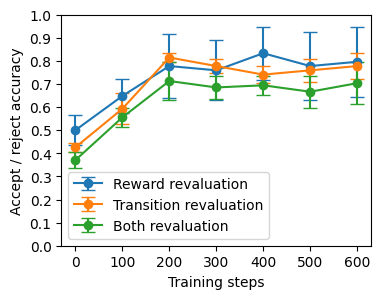

In [127]:
produce_plot('test')

#### Regression coefficients approach

In [14]:
def get_pred_reward_for_strategy(seq, output_dir, strategy):
    with open(os.path.join(output_dir, 'trial_info.pkl'), 'rb') as handle:
        trial_info = pickle.load(handle)
        stimuli = trial_info['stimuli']
        train_stop = trial_info['train_stop']
        train_reward = trial_info['train_reward']
    
    test_start = seq[0:seq.index(', STOP')].replace('START: ', '')
    test_stop = seq[seq.index('STOP'):seq.index('REWARD')].replace('STOP: ', '').replace(', ', '')
    test_reward = seq[seq.index('REWARD'):seq.index('SEQUENCE')].replace('REWARD: ', '').replace(', ', '')
    
    print(f'Train stop: {train_stop}, train reward: {train_reward}, test stop: {test_stop}, test reward {test_reward}')
    print(stimuli)
    
    if strategy == 'revaluate_reward':
        # get train stop, test reward
        outcome = get_accept_reject(stimuli, test_start, train_stop, test_reward)
    if strategy == 'revaluate_transition':
        # get train reward, test stop
        outcome = get_accept_reject(stimuli, test_start, test_stop, train_reward)
    if strategy == 'revaluate_both':
        # get test reward, test stop
        outcome = get_accept_reject(stimuli, test_start, test_stop, test_reward)
    if strategy == 'no_revaluation':
        # get train reward, train stop
        outcome = get_accept_reject(stimuli, test_start, train_stop, train_reward)
    return outcome
        

In [18]:
def get_accept_reject(stimuli, start, stop, reward):

    points = []
    sequence_started = False
    
    index = 0  # start index
    while True:
        stim = stimuli[index % len(stimuli)]
        colour, obj = stim.split()

        if not sequence_started:
            if stim == start:
                sequence_started = True
            index += 1
            continue
        else:
            if obj == reward:
                points.append(2)
            else:
                points.append(-1)
    
            if colour == stop:
                break

        index += 1  # move to the next stimulus

    print(f"Inferred points sequence for {start} / {stop} / {reward}: {points}")
    if sum(points) > 0:
        return 1
    if sum(points) < 0:
        return 0
    if sum(points) ==0:
        return 0.5

In [19]:
def get_strategy(i, task_type='reward', strategy='no_revaluation'):
    model_dir = f'clm_script_{i}'
    
    with open(os.path.join(model_dir, f'test_{task_type}.txt')) as f:
        seqs = f.readlines()
        seqs = [s.replace('\n', '') for s in seqs]
        seqs = sorted(list(set(seqs)))
        print(task_type, strategy)
    
    preds = []
    for seq in seqs:
        pred = get_pred_reward_for_strategy(seq, model_dir, strategy)
        preds.append(pred)
        print(seq)
        print(f"Prediction: {pred}")
        print("......................")
    return np.asarray(preds)


def get_strategy_df(task_type='transition'):
    file_name = f'results_{task_type}.pkl'
    with open(file_name, 'rb') as f:
        all_results = pickle.load(f)
    df = pd.DataFrame(all_results)
    df = df.dropna(axis='rows')

    for col in df.columns:
        df[col] = df[col].apply(lambda x: np.array(x[1]))

    df["model_num"] = df.index
    print(df.index.tolist())

    df['NR_preds'] = df["model_num"].apply(lambda x: get_strategy(x, 
                                                                  task_type=task_type, 
                                                                  strategy='no_revaluation'))

    df['RR_preds'] = df["model_num"].apply(lambda x: get_strategy(x, 
                                                                  task_type=task_type, 
                                                                  strategy='revaluate_reward'))

    df['TR_preds'] = df["model_num"].apply(lambda x: get_strategy(x, 
                                                                  task_type=task_type, 
                                                                  strategy='revaluate_transition'))

    df['BR_preds'] = df["model_num"].apply(lambda x: get_strategy(x, 
                                                                  task_type=task_type, 
                                                                  strategy='revaluate_both'))
    return df

In [20]:
df2 = get_strategy_df(task_type='transition')
df1 = get_strategy_df(task_type='reward')
df3 = get_strategy_df(task_type='both')
df = pd.concat([df1, df2, df3])

[1, 2, 3]
transition no_revaluation
Train stop: green, train reward: vehicle, test stop: red, test reward vehicle
['yellow vehicle', 'red fruit', 'green fruit', 'green vehicle', 'red vehicle', 'red animal', 'yellow fruit', 'green animal', 'yellow animal']
Inferred points sequence for green animal / green / vehicle: [-1, 2, -1, -1]
START: green animal, STOP: red, REWARD: vehicle, SEQUENCE: yellow animal (-1), yellow vehicle (2), red fruit (-1)
Prediction: 0
......................
Train stop: green, train reward: vehicle, test stop: yellow, test reward vehicle
['yellow vehicle', 'red fruit', 'green fruit', 'green vehicle', 'red vehicle', 'red animal', 'yellow fruit', 'green animal', 'yellow animal']
Inferred points sequence for green animal / green / vehicle: [-1, 2, -1, -1]
START: green animal, STOP: yellow, REWARD: vehicle, SEQUENCE: yellow animal (-1)
Prediction: 0
......................
Train stop: green, train reward: vehicle, test stop: red, test reward vehicle
['yellow vehicle', '

In [21]:
def flatten_col(col):
    col_list = df[col].tolist()
    return [item for sublist in col_list for item in sublist]

df = df.reset_index()

for model in ['rule_model', 'checkpoint-100', 'checkpoint-200', 'checkpoint-300']:

    targets = flatten_col(model)
    feats = [flatten_col('RR_preds'),
             flatten_col('TR_preds'),
             flatten_col('NR_preds'),
             flatten_col('BR_preds')]
    feats = [list(row) for row in zip(*feats)]

    reg = LinearRegression(fit_intercept=True)
    reg.fit(feats, targets)
    print(model)
    print(reg.coef_)
    print(reg.intercept_)

rule_model
[ 0.15835454  0.13554288 -0.11588431 -0.15152078]
0.37076199601192955
checkpoint-100
[ 0.30628367 -0.03651908  0.16676054  0.14686793]
0.3370733512892694
checkpoint-200
[0.29978751 0.06058978 0.19425153 0.46434474]
0.13143254328063503
checkpoint-300
[0.28520904 0.09411566 0.05598726 0.40932739]
0.2149741471406818


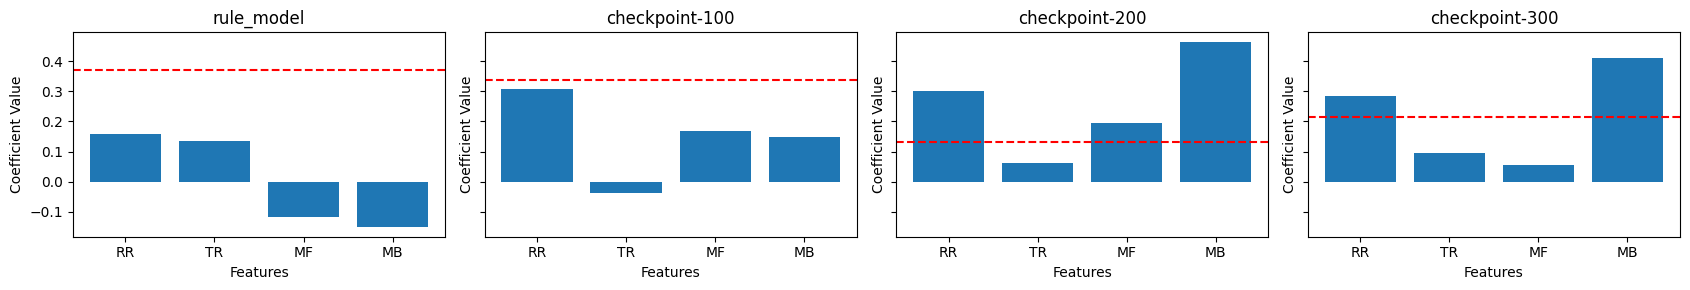

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

def flatten_col(col):
    col_list = df[col].tolist()
    return [item for sublist in col_list for item in sublist]

# Function to plot the coefficients
def plot_coefficients(models, feature_names):
    coefs = []
    intercepts = []
    
    for model in models:
        targets = flatten_col(model)
        feats = [flatten_col('RR_preds'),
                 flatten_col('TR_preds'),
                 flatten_col('NR_preds'),
                 flatten_col('BR_preds')]
        feats = [list(row) for row in zip(*feats)]

        reg = LinearRegression(fit_intercept=True)
        reg.fit(feats, targets)
        
        coefs.append(reg.coef_)
        intercepts.append(reg.intercept_)

    # Plotting
    fig, axes = plt.subplots(nrows=1, ncols=len(models), figsize=(17, 3), sharey=True)
    for idx, ax in enumerate(axes):
        ax.bar(feature_names, coefs[idx])
        ax.axhline(y=intercepts[idx], color='r', linestyle='--')
        ax.set_title(models[idx])
        ax.set_xlabel('Features')
        ax.set_ylabel('Coefficient Value')
    plt.tight_layout()
    plt.show()

# Feature names
feature_names = ['RR', 'TR', 'MF', 'MB']
# Models
models = ['rule_model', 'checkpoint-100', 'checkpoint-200', 'checkpoint-300']

# Plot the coefficients
plot_coefficients(models, feature_names)


In [23]:
models = ['rule_model', 'checkpoint-100', 'checkpoint-200', 'checkpoint-300']
strategies = ['NR_preds', 'RR_preds', 'TR_preds', 'BR_preds']

for model in models:
    for strategy in strategies:
        print(model, strategy)
        print(pearsonr(flatten_col(model), flatten_col(strategy)))

rule_model NR_preds
PearsonRResult(statistic=-0.011050331514918302, pvalue=0.8717243326652431)
rule_model RR_preds
PearsonRResult(statistic=0.048512373010802676, pvalue=0.47816065354016296)
rule_model TR_preds
PearsonRResult(statistic=0.06628973031334015, pvalue=0.3322110103439663)
rule_model BR_preds
PearsonRResult(statistic=-0.04911313960416805, pvalue=0.4727215619514642)
checkpoint-100 NR_preds
PearsonRResult(statistic=0.11412099699966807, pvalue=0.09433377236224282)
checkpoint-100 RR_preds
PearsonRResult(statistic=0.39288436195919607, pvalue=2.1903721371486714e-09)
checkpoint-100 TR_preds
PearsonRResult(statistic=0.009826890972705622, pvalue=0.885823724202701)
checkpoint-100 BR_preds
PearsonRResult(statistic=0.317555007168314, pvalue=1.8989648341834056e-06)
checkpoint-200 NR_preds
PearsonRResult(statistic=0.16320995581750591, pvalue=0.016355297884915312)
checkpoint-200 RR_preds
PearsonRResult(statistic=0.5602097543880216, pvalue=3.0299980461935196e-19)
checkpoint-200 TR_preds
Pears

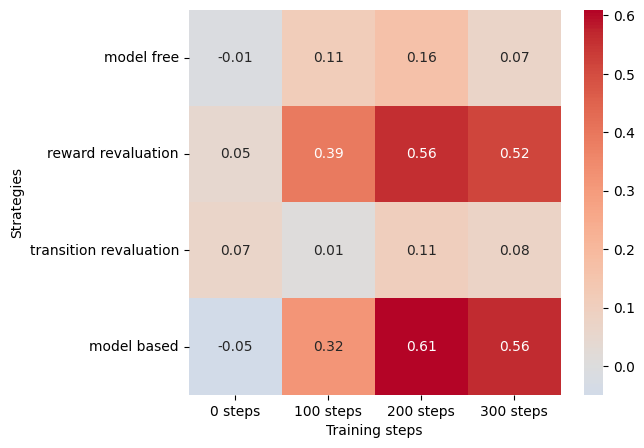

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr

def flatten_col(col):
    col_list = df[col].tolist()
    return [item for sublist in col_list for item in sublist]

# Define the new labels for models and strategies
model_labels = ['0 steps', '100 steps', '200 steps', '300 steps']
strategy_labels = ['model free', 'reward revaluation', 'transition revaluation', 'model based']

# Original model and strategy identifiers
models = ['rule_model', 'checkpoint-100', 'checkpoint-200', 'checkpoint-300']
strategies = ['NR_preds', 'RR_preds', 'TR_preds', 'BR_preds']

# Prepare a DataFrame to store Pearson correlation coefficients with new labels
correlation_matrix = pd.DataFrame(index=model_labels, columns=strategy_labels)

# Calculate Pearson correlation coefficients
for model, model_label in zip(models, model_labels):
    for strategy, strategy_label in zip(strategies, strategy_labels):
        correlation, _ = pearsonr(flatten_col(model), flatten_col(strategy))
        correlation_matrix.loc[model_label, strategy_label] = correlation

# Convert the coefficients to float for plotting
correlation_matrix = correlation_matrix.astype(float)

# Create the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix.T, annot=True, cmap='coolwarm', center=0, fmt=".2f")  # Transpose for correct orientation
#plt.title('Pearson Correlation Coefficients between Models and Strategies')
plt.xlabel('Training steps')  # These now represent strategies
plt.ylabel('Strategies')      # These now represent models
# plt.xticks(rotation=45)
# plt.yticks(rotation=0)
plt.savefig('Correlation coefficients heatmap.png', dpi=500, bbox_inches='tight')
plt.show()


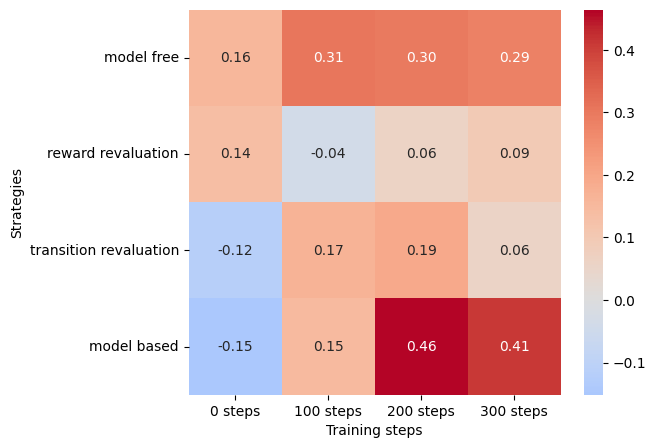

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

def flatten_col(col):
    col_list = df[col].tolist()
    return [item for sublist in col_list for item in sublist]

# Prepare data for heatmap
model_steps = ['rule_model', 'checkpoint-100', 'checkpoint-200', 'checkpoint-300']
model_labels = ['0 steps', '100 steps', '200 steps', '300 steps']
strategy_labels = ['RR_preds', 'TR_preds', 'NR_preds', 'BR_preds']
strategy_names = ['model free', 'reward revaluation', 'transition revaluation', 'model based']

coefficients = pd.DataFrame(columns=model_labels, index=strategy_names)

for model, label in zip(model_steps, model_labels):
    targets = flatten_col(model)
    feats = [flatten_col(strategy) for strategy in strategy_labels]
    feats = [list(row) for row in zip(*feats)]

    reg = LinearRegression(fit_intercept=True)
    reg.fit(feats, targets)
    coefficients[label] = reg.coef_

# Plotting the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(coefficients, annot=True, cmap='coolwarm', center=0, fmt=".2f")
#plt.title('Regression Coefficients Heatmap')
plt.ylabel('Strategies')
plt.xlabel('Training steps')
plt.savefig('Regression coefficients heatmap.png', dpi=500, bbox_inches='tight')
plt.show()


#### 'Retrieval augmented generation'

Can the generative network's outputs be conditioned on hippocampal sequences (inspired by retrieval augmented generation), to support some degree of generalisation soon after encoding?

In [192]:
model = GPT(base_model='rule_model')

In [198]:
def get_most_similar(train_seqs, test_seq, n):
    # Extract words from the test_seq up to "SEQUENCE"
    test_seq_words = set(test_seq.split("SEQUENCE:")[0].split())
    start_condition = test_seq.split("STOP:")[0]
    train_seqs = [t for t in train_seqs if start_condition in t]

    overlap_scores = []

    for train_seq in train_seqs:
        # Extract words from the train_seq up to "SEQUENCE"
        train_seq_words = set(train_seq.split("SEQUENCE:")[0].split())
        
        # Calculate the overlap by finding the intersection of sets
        overlap = len(test_seq_words.intersection(train_seq_words))
        
        # Store the train sequence with its overlap score
        overlap_scores.append((train_seq, overlap))

    # Sort the list of tuples by overlap score in descending order and select the top n
    top_n_seqs = sorted(overlap_scores, key=lambda x: x[1], reverse=True)[:n]
    
    # Return only the sequences, not their scores
    return [seq[0] for seq in top_n_seqs]

# Example usage
train_seqs = [
    "START: blue animal, STOP: green, REWARD: vehicle, SEQUENCE: blue vehicle (3)",
    "START: green animal, STOP: red, REWARD: vehicle, SEQUENCE: red vehicle (2)",
    "START: yellow animal, STOP: red, REWARD: vegetable, SEQUENCE: red vegetable (2)",
    "START: green animal, STOP: blue, REWARD: vehicle, SEQUENCE: blue vehicle (1)",
    "START: green animal, STOP: red, REWARD: bicycle, SEQUENCE: red bicycle (2)"
]
test_seq = "START: green animal, STOP: red, REWARD: vehicle, SEQUENCE: red vehicle (2)"

print(get_most_similar(train_seqs, test_seq, n=9))

['START: green animal, STOP: red, REWARD: vehicle, SEQUENCE: red vehicle (2)', 'START: green animal, STOP: blue, REWARD: vehicle, SEQUENCE: blue vehicle (1)', 'START: green animal, STOP: red, REWARD: bicycle, SEQUENCE: red bicycle (2)']


In [199]:
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

def get_seqs_RAG(base_dir='clm_script_0', test_type='reward'):
    with open(os.path.join(base_dir, f'test_{test_type}.txt')) as f:
        seqs = f.readlines()
        seqs = [s.replace('\n', '') for s in seqs]
        test_seqs = sorted(list(set(seqs)))

    with open(os.path.join(base_dir, f'train.txt')) as f:
        seqs = f.readlines()
        seqs = [s.replace('\n', '') for s in seqs]
        train_seqs = sorted(list(set(seqs)))
    
    return train_seqs, test_seqs
        
def test_RAG(base_dir = 'clm_script_0', test_type='transition', n=1):
    train_seqs, test_seqs = get_seqs_RAG(base_dir=base_dir, test_type=test_type)
    print(len(train_seqs))

    result_bools = []
    mf_baseline_bools = []
    nc_baseline_bools = []

    for test in test_seqs:
        print(f"Test sequence: {test}")
        train_examples = get_most_similar(train_seqs, test, n=n)
        print(f"Train example: {train_examples}")
        
        continuation = model.continue_input("\n".join(train_examples) + '\n' + test[0:test.index('SEQUENCE')] + 'SEQUENCE:',
                                            do_sample=False, num_beams=5)
        start_ind = find_nth(continuation, 'SEQUENCE', len(train_examples) + 1)
        end_ind = find_nth(continuation, 'START', len(train_examples) + 2)

        true_a_v_r = get_accept_reject_choice(test)
        pred_a_v_r = get_accept_reject_choice(continuation[start_ind:end_ind])
        if true_a_v_r == pred_a_v_r:
            result_bools.append(1)
        else:
            result_bools.append(0)

        mf_baseline_a_v_r = get_accept_reject_choice(train_examples[0])
        if true_a_v_r == mf_baseline_a_v_r:
            mf_baseline_bools.append(1)
        else:
            mf_baseline_bools.append(0)
        
        continuation = model.continue_input(test[0:test.index('SEQUENCE')] + 'SEQUENCE:',
                                            do_sample=False, num_beams=5)
        start_ind = find_nth(continuation, 'SEQUENCE', 1)
        end_ind = find_nth(continuation, 'START', 2)
        nc_baseline_a_v_r = get_accept_reject_choice(continuation[start_ind:end_ind])
        if true_a_v_r == nc_baseline_a_v_r:
            nc_baseline_bools.append(1)
        else:
            nc_baseline_bools.append(0)
            
    return result_bools, mf_baseline_bools, nc_baseline_bools

all_transition = []
all_reward = []
all_both = []

for i in range(5):
    res = test_RAG(base_dir = f'clm_script_{i}', test_type='reward', n=1)
    all_reward.append(res)
    res = test_RAG(base_dir = f'clm_script_{i}', test_type='transition', n=1)
    all_transition.append(res)
    res = test_RAG(base_dir = f'clm_script_{i}', test_type='both', n=1)
    all_both.append(res)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


9
Test sequence: START: green animal, STOP: red, REWARD: animal, SEQUENCE: red vehicle (-1)
Train example: ['START: green animal, STOP: red, REWARD: fruit, SEQUENCE: red vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)
[-1]
 red vehicle (-1)

[-1]
 red vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red meatloaf (-1)

[-1]
Test sequence: START: green animal, STOP: red, REWARD: vehicle, SEQUENCE: red vehicle (2)
Train example: ['START: green animal, STOP: red, REWARD: fruit, SEQUENCE: red vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)
[2]
 red vehicle (2)

[2]
 red vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: green fruit, STOP: red, REWARD: animal, SEQUENCE: yellow vehicle (-1), green animal (2), red vehicle (-1)
Train example: ['START: green fruit, STOP: red, REWARD: fruit, SEQUENCE: yellow vehicle (-1), green animal (-1), red vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), green animal (2), red vehicle (-1)
[-1, 2, -1]
 yellow vehicle (-1), green animal (2), red vehicle (-1)

[-1, 2, -1]
 yellow vehicle (-1), green animal (-1), red vehicle (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red grapefruit (-1)

[-1]
Test sequence: START: green fruit, STOP: red, REWARD: vehicle, SEQUENCE: yellow vehicle (2), green animal (-1), red vehicle (2)
Train example: ['START: green fruit, STOP: red, REWARD: fruit, SEQUENCE: yellow vehicle (-1), green animal (-1), red vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2), green animal (-1), red vehicle (2)
[2, -1, 2]
 yellow vehicle (2), green animal (-1), red vehicle (2)

[2, -1, 2]
 yellow vehicle (-1), green animal (-1), red vehicle (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: green vehicle, STOP: red, REWARD: animal, SEQUENCE: yellow animal (2), red animal (2)
Train example: ['START: green vehicle, STOP: red, REWARD: fruit, SEQUENCE: yellow animal (-1), red animal (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (2), red animal (2)
[2, 2]
 yellow animal (2), red animal (2)

[2, 2]
 yellow animal (-1), red animal (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)

[-1]
Test sequence: START: green vehicle, STOP: red, REWARD: vehicle, SEQUENCE: yellow animal (-1), red animal (-1)
Train example: ['START: green vehicle, STOP: red, REWARD: fruit, SEQUENCE: yellow animal (-1), red animal (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), red animal (-1)
[-1, -1]
 yellow animal (-1), red animal (-1)

[-1, -1]
 yellow animal (-1), red animal (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: red animal, STOP: red, REWARD: animal, SEQUENCE: yellow fruit (-1), red fruit (-1)
Train example: ['START: red animal, STOP: red, REWARD: fruit, SEQUENCE: yellow fruit (2), red fruit (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), red fruit (-1)
[-1, -1]
 yellowfruit (-1), redfruit (-1)

[-1, -1]
 yellow fruit (2), red fruit (2)
[2, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red meatloaf (-1)

[-1]
Test sequence: START: red animal, STOP: red, REWARD: vehicle, SEQUENCE: yellow fruit (-1), red fruit (-1)
Train example: ['START: red animal, STOP: red, REWARD: fruit, SEQUENCE: yellow fruit (2), red fruit (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), red fruit (-1)
[-1, -1]
 yellowfruit (-1), redfruit (-1)

[-1, -1]
 yellow fruit (2), red fruit (2)
[2, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: red fruit, STOP: red, REWARD: animal, SEQUENCE: green fruit (-1), yellow vehicle (-1), green animal (2), red vehicle (-1)
Train example: ['START: red fruit, STOP: red, REWARD: fruit, SEQUENCE: green fruit (2), yellow vehicle (-1), green animal (-1), red vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), yellow vehicle (-1), green animal (2), red vehicle (-1)
[-1, -1, 2, -1]
 greenfruit (-1), yellow vehicle (-1), green animal (2), red vehicle (-1)

[-1, -1, 2, -1]
 green fruit (2), yellow vehicle (-1), green animal (-1), red vehicle (-1)
[2, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red grapefruit (-1)

[-1]
Test sequence: START: red fruit, STOP: red, REWARD: vehicle, SEQUENCE: green fruit (-1), yellow vehicle (2), green animal (-1), red vehicle (2)
Train example: ['START: red fruit, STOP: red, REWARD: fruit, SEQUENCE: green fruit (2), yellow vehicle (-1), green animal (-1), red vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), yellow vehicle (2), green animal (-1), red vehicle (2)
[-1, 2, -1, 2]
 greenfruit (-1), yellow vehicle (2), green animal (-1), red vehicle (2)

[-1, 2, -1, 2]
 green fruit (2), yellow vehicle (-1), green animal (-1), red vehicle (-1)
[2, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: red vehicle, STOP: red, REWARD: animal, SEQUENCE: green vehicle (-1), yellow animal (2), red animal (2)
Train example: ['START: red vehicle, STOP: red, REWARD: fruit, SEQUENCE: green vehicle (-1), yellow animal (-1), red animal (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), yellow animal (2), red animal (2)
[-1, 2, 2]
 green vehicle (-1), yellow animal (2), red animal (2)

[-1, 2, 2]
 green vehicle (-1), yellow animal (-1), red animal (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)

[-1]
Test sequence: START: red vehicle, STOP: red, REWARD: vehicle, SEQUENCE: green vehicle (2), yellow animal (-1), red animal (-1)
Train example: ['START: red vehicle, STOP: red, REWARD: fruit, SEQUENCE: green vehicle (-1), yellow animal (-1), red animal (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2), yellow animal (-1), red animal (-1)
[2, -1, -1]
 green vehicle (2), yellow animal (-1), red animal (-1)

[2, -1, -1]
 green vehicle (-1), yellow animal (-1), red animal (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: yellow animal, STOP: red, REWARD: animal, SEQUENCE: red animal (2)
Train example: ['START: yellow animal, STOP: red, REWARD: fruit, SEQUENCE: red animal (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (2)
[2]
 red animal (2)

[2]
 red animal (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow cayenne (-1), red cayenne (-1)

[-1, -1]
Test sequence: START: yellow animal, STOP: red, REWARD: vehicle, SEQUENCE: red animal (-1)
Train example: ['START: yellow animal, STOP: red, REWARD: fruit, SEQUENCE: red animal (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1)
[-1]
 red animal (-1)

[-1]
 red animal (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: yellow fruit, STOP: red, REWARD: animal, SEQUENCE: red fruit (-1)
Train example: ['START: yellow fruit, STOP: red, REWARD: fruit, SEQUENCE: red fruit (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1)
[-1]
 redfruit (-1)

[-1]
 red fruit (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red grapefruit (-1)

[-1]
Test sequence: START: yellow fruit, STOP: red, REWARD: vehicle, SEQUENCE: red fruit (-1)
Train example: ['START: yellow fruit, STOP: red, REWARD: fruit, SEQUENCE: red fruit (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1)
[-1]
 redfruit (-1)

[-1]
 red fruit (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: yellow vehicle, STOP: red, REWARD: animal, SEQUENCE: green animal (2), red vehicle (-1)
Train example: ['START: yellow vehicle, STOP: red, REWARD: fruit, SEQUENCE: green animal (-1), red vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (2), red vehicle (-1)
[2, -1]
 green animal (2), red vehicle (-1)

[2, -1]
 green animal (-1), red vehicle (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vellum (-1), red vellum (-1)

[-1, -1]
Test sequence: START: yellow vehicle, STOP: red, REWARD: vehicle, SEQUENCE: green animal (-1), red vehicle (2)
Train example: ['START: yellow vehicle, STOP: red, REWARD: fruit, SEQUENCE: green animal (-1), red vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), red vehicle (2)
[-1, 2]
 green animal (-1), red vehicle (2)

[-1, 2]
 green animal (-1), red vehicle (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
9
Test sequence: START: green animal, STOP: green, REWARD: fruit, SEQUENCE: red vehicle (-1), green vehicle (-1)
Train example: ['START: green animal, STOP: red, REWARD: fruit, SEQUENCE: red vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), green vehicle (-1)
[-1, -1]
 red vehicle (-1), green vehicle (-1)

[-1, -1]
 red vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green meatloaf (-1)

[-1]
Test sequence: START: green animal, STOP: yellow, REWARD: fruit, SEQUENCE: red vehicle (-1), green vehicle (-1), yellow animal (-1)
Train example: ['START: green animal, STOP: red, REWARD: fruit, SEQUENCE: red vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), green vehicle (-1), yellow animal (-1)
[-1, -1, -1]
 red vehicle (-1), yellow vehicle (-1)

[-1, -1]
 red vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow meatloaf (-1)

[-1]
Test sequence: START: green fruit, STOP: green, REWARD: fruit, SEQUENCE: yellow vehicle (-1), green animal (-1)
Train example: ['START: green fruit, STOP: red, REWARD: fruit, SEQUENCE: yellow vehicle (-1), green animal (-1), red vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), green animal (-1)
[-1, -1]
 yellow vehicle (-1), green animal (-1)

[-1, -1]
 yellow vehicle (-1), green animal (-1), red vehicle (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 blueberry (-1), blueberry (-1), blueberry (-1), green juice (-1)

[-1, -1, -1, -1]
Test sequence: START: green fruit, STOP: yellow, REWARD: fruit, SEQUENCE: yellow vehicle (-1)
Train example: ['START: green fruit, STOP: red, REWARD: fruit, SEQUENCE: yellow vehicle (-1), green animal (-1), red vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1)
[-1]
 yellow vehicle (-1)

[-1]
 yellow vehicle (-1), green animal (-1), red vehicle (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (2)

[2]
Test sequence: START: green vehicle, STOP: green, REWARD: fruit, SEQUENCE: yellow animal (-1), red animal (-1), yellow fruit (2), red fruit (2), green fruit (2)
Train example: ['START: green vehicle, STOP: red, REWARD: fruit, SEQUENCE: yellow animal (-1), red animal (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), red animal (-1), yellow fruit (2), red fruit (2), green fruit (2)
[-1, -1, 2, 2, 2]
 yellow animal (-1), red animal (-1), yellow vehicle (-1), green vehicle (-1)

[-1, -1, -1, -1]
 yellow animal (-1), red animal (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)

[-1]
Test sequence: START: green vehicle, STOP: yellow, REWARD: fruit, SEQUENCE: yellow animal (-1)
Train example: ['START: green vehicle, STOP: red, REWARD: fruit, SEQUENCE: yellow animal (-1), red animal (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1)
[-1]
 yellow elephant (-1)

[-1]
 yellow animal (-1), red animal (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow carport (-1)

[-1]
Test sequence: START: red animal, STOP: green, REWARD: fruit, SEQUENCE: yellow fruit (2), red fruit (2), green fruit (2)
Train example: ['START: red animal, STOP: red, REWARD: fruit, SEQUENCE: yellow fruit (2), red fruit (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (2), red fruit (2), green fruit (2)
[2, 2, 2]
 yellowfruit (2), redfruit (2), yellow petal (-1), green petal (-1)

[2, 2, -1, -1]
 yellow fruit (2), red fruit (2)
[2, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green meatloaf (-1)

[-1]
Test sequence: START: red animal, STOP: yellow, REWARD: fruit, SEQUENCE: yellow fruit (2)
Train example: ['START: red animal, STOP: red, REWARD: fruit, SEQUENCE: yellow fruit (2), red fruit (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (2)
[2]
 yellowfruit (2)

[2]
 yellow fruit (2), red fruit (2)
[2, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow meatloaf (-1)

[-1]
Test sequence: START: red fruit, STOP: green, REWARD: fruit, SEQUENCE: green fruit (2)
Train example: ['START: red fruit, STOP: red, REWARD: fruit, SEQUENCE: green fruit (2), yellow vehicle (-1), green animal (-1), red vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (2)
[2]
 greenfruit (-1)

[-1]
 green fruit (2), yellow vehicle (-1), green animal (-1), red vehicle (-1)
[2, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green grapefruit (2)

[2]
Test sequence: START: red fruit, STOP: yellow, REWARD: fruit, SEQUENCE: green fruit (2), yellow vehicle (-1)
Train example: ['START: red fruit, STOP: red, REWARD: fruit, SEQUENCE: green fruit (2), yellow vehicle (-1), green animal (-1), red vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (2), yellow vehicle (-1)
[2, -1]
 greenfruit (2), yellow vehicle (-1)

[2, -1]
 green fruit (2), yellow vehicle (-1), green animal (-1), red vehicle (-1)
[2, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (2)

[2]
Test sequence: START: red vehicle, STOP: green, REWARD: fruit, SEQUENCE: green vehicle (-1)
Train example: ['START: red vehicle, STOP: red, REWARD: fruit, SEQUENCE: green vehicle (-1), yellow animal (-1), red animal (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)
[-1]
 green vehicle (-1)

[-1]
 green vehicle (-1), yellow animal (-1), red animal (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)

[-1]
Test sequence: START: red vehicle, STOP: yellow, REWARD: fruit, SEQUENCE: green vehicle (-1), yellow animal (-1)
Train example: ['START: red vehicle, STOP: red, REWARD: fruit, SEQUENCE: green vehicle (-1), yellow animal (-1), red animal (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), yellow animal (-1)
[-1, -1]
 green vehicle (-1), yellow animal (-1)

[-1, -1]
 green vehicle (-1), yellow animal (-1), red animal (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow carport (-1)

[-1]
Test sequence: START: yellow animal, STOP: green, REWARD: fruit, SEQUENCE: red animal (-1), yellow fruit (2), red fruit (2), green fruit (2)
Train example: ['START: yellow animal, STOP: red, REWARD: fruit, SEQUENCE: red animal (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), yellow fruit (2), red fruit (2), green fruit (2)
[-1, 2, 2, 2]
 red animal (-1), yellow meatloaf (-1), green meatloaf (-1)

[-1, -1, -1]
 red animal (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow meatloaf (-1), green meatloaf (-1)

[-1, -1]
Test sequence: START: yellow animal, STOP: yellow, REWARD: fruit, SEQUENCE: red animal (-1), yellow fruit (2)
Train example: ['START: yellow animal, STOP: red, REWARD: fruit, SEQUENCE: red animal (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), yellow fruit (2)
[-1, 2]
 red elephant (-1), yellow elephant (-1)

[-1, -1]
 red animal (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow meatloaf (-1)

[-1]
Test sequence: START: yellow fruit, STOP: green, REWARD: fruit, SEQUENCE: red fruit (2), green fruit (2)
Train example: ['START: yellow fruit, STOP: red, REWARD: fruit, SEQUENCE: red fruit (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (2), green fruit (2)
[2, 2]
 redfruit (2), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1)
[2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
 red fruit (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1)
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
Test sequence: START: yellow fruit, STOP: yellow, REWARD: fruit, SEQUENCE: red fruit (2), green fruit (2), yellow vehicle (-1)
Train example: ['START: yellow fruit, STOP: red, REWARD: fruit, SEQUENCE: red fruit (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (2), green fruit (2), yellow vehicle (-1)
[2, 2, -1]
 redfruit (2), yellow grape (-1)

[2, -1]
 red fruit (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (2)

[2]
Test sequence: START: yellow vehicle, STOP: green, REWARD: fruit, SEQUENCE: green animal (-1)
Train example: ['START: yellow vehicle, STOP: red, REWARD: fruit, SEQUENCE: green animal (-1), red vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1)
[-1]
 green elephant (-1)

[-1]
 green animal (-1), red vehicle (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)

[-1]
Test sequence: START: yellow vehicle, STOP: yellow, REWARD: fruit, SEQUENCE: green animal (-1), red vehicle (-1), green vehicle (-1), yellow animal (-1)
Train example: ['START: yellow vehicle, STOP: red, REWARD: fruit, SEQUENCE: green animal (-1), red vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), red vehicle (-1), green vehicle (-1), yellow animal (-1)
[-1, -1, -1, -1]
 green animal (-1), red vehicle (-1), yellow vehicle (-1)

[-1, -1, -1]
 green animal (-1), red vehicle (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow carport (-1)

[-1]
9
Test sequence: START: green animal, STOP: green, REWARD: animal, SEQUENCE: red vehicle (-1), green vehicle (-1)
Train example: ['START: green animal, STOP: red, REWARD: fruit, SEQUENCE: red vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), green vehicle (-1)
[-1, -1]
 red vehicle (-1), green vehicle (-1)

[-1, -1]
 red vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 jittery zoo (-1), jittery ecology (-1), jittery ecology (-1), green ecology (-1)

[-1, -1, -1, -1]
Test sequence: START: green animal, STOP: green, REWARD: vehicle, SEQUENCE: red vehicle (2), green vehicle (2)
Train example: ['START: green animal, STOP: red, REWARD: fruit, SEQUENCE: red vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2), green vehicle (2)
[2, 2]
 red vehicle (2), red meatloaf (-1), green meatloaf (-1)

[2, -1, -1]
 red vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: green animal, STOP: yellow, REWARD: animal, SEQUENCE: red vehicle (-1), green vehicle (-1), yellow animal (2)
Train example: ['START: green animal, STOP: red, REWARD: fruit, SEQUENCE: red vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), green vehicle (-1), yellow animal (2)
[-1, -1, 2]
 red vehicle (-1), yellow vehicle (-1)

[-1, -1]
 red vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow meatloaf (-1)

[-1]
Test sequence: START: green animal, STOP: yellow, REWARD: vehicle, SEQUENCE: red vehicle (2), green vehicle (2), yellow animal (-1)
Train example: ['START: green animal, STOP: red, REWARD: fruit, SEQUENCE: red vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2), green vehicle (2), yellow animal (-1)
[2, 2, -1]
 red vehicle (2), yellow meatloaf (-1)

[2, -1]
 red vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow carport (-1)

[-1]
Test sequence: START: green fruit, STOP: green, REWARD: animal, SEQUENCE: yellow vehicle (-1), green animal (2)
Train example: ['START: green fruit, STOP: red, REWARD: fruit, SEQUENCE: yellow vehicle (-1), green animal (-1), red vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), green animal (2)
[-1, 2]
 yellow vehicle (-1), green animal (2)

[-1, 2]
 yellow vehicle (-1), green animal (-1), red vehicle (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green meatloaf (-1)

[-1]
Test sequence: START: green fruit, STOP: green, REWARD: vehicle, SEQUENCE: yellow vehicle (2), green animal (-1)
Train example: ['START: green fruit, STOP: red, REWARD: fruit, SEQUENCE: yellow vehicle (-1), green animal (-1), red vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2), green animal (-1)
[2, -1]
 yellow vehicle (2), green animal (-1)

[2, -1]
 yellow vehicle (-1), green animal (-1), red vehicle (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: green fruit, STOP: yellow, REWARD: animal, SEQUENCE: yellow vehicle (-1)
Train example: ['START: green fruit, STOP: red, REWARD: fruit, SEQUENCE: yellow vehicle (-1), green animal (-1), red vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1)
[-1]
 yellow vehicle (-1)

[-1]
 yellow vehicle (-1), green animal (-1), red vehicle (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (-1)

[-1]
Test sequence: START: green fruit, STOP: yellow, REWARD: vehicle, SEQUENCE: yellow vehicle (2)
Train example: ['START: green fruit, STOP: red, REWARD: fruit, SEQUENCE: yellow vehicle (-1), green animal (-1), red vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2)
[2]
 yellow vehicle (2)

[2]
 yellow vehicle (-1), green animal (-1), red vehicle (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (-1)

[-1]
Test sequence: START: green vehicle, STOP: green, REWARD: animal, SEQUENCE: yellow animal (2), red animal (2), yellow fruit (-1), red fruit (-1), green fruit (-1)
Train example: ['START: green vehicle, STOP: red, REWARD: fruit, SEQUENCE: yellow animal (-1), red animal (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (2), red animal (2), yellow fruit (-1), red fruit (-1), green fruit (-1)
[2, 2, -1, -1, -1]
 yellow animal (2), red animal (2), yellow meatloaf (-1), green meatloaf (-1)

[2, 2, -1, -1]
 yellow animal (-1), red animal (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)

[-1]
Test sequence: START: green vehicle, STOP: green, REWARD: vehicle, SEQUENCE: yellow animal (-1), red animal (-1), yellow fruit (-1), red fruit (-1), green fruit (-1)
Train example: ['START: green vehicle, STOP: red, REWARD: fruit, SEQUENCE: yellow animal (-1), red animal (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), red animal (-1), yellow fruit (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1, -1, -1]
 yellow animal (-1), red animal (-1), green vehicle (2)

[-1, -1, 2]
 yellow animal (-1), red animal (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: green vehicle, STOP: yellow, REWARD: animal, SEQUENCE: yellow animal (2)
Train example: ['START: green vehicle, STOP: red, REWARD: fruit, SEQUENCE: yellow animal (-1), red animal (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (2)
[2]
 yellow animal (2)

[2]
 yellow animal (-1), red animal (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow veldt (-1)

[-1]
Test sequence: START: green vehicle, STOP: yellow, REWARD: vehicle, SEQUENCE: yellow animal (-1)
Train example: ['START: green vehicle, STOP: red, REWARD: fruit, SEQUENCE: yellow animal (-1), red animal (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1)
[-1]
 yellow animal (-1)

[-1]
 yellow animal (-1), red animal (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow carport (-1)

[-1]
Test sequence: START: red animal, STOP: green, REWARD: animal, SEQUENCE: yellow fruit (-1), red fruit (-1), green fruit (-1)
Train example: ['START: red animal, STOP: red, REWARD: fruit, SEQUENCE: yellow fruit (2), red fruit (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1]
 yellowfruit (-1), redfruit (-1), yellow meat (-1), green meat (-1)

[-1, -1, -1, -1]
 yellow fruit (2), red fruit (2)
[2, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green mangrove (-1)

[-1]
Test sequence: START: red animal, STOP: green, REWARD: vehicle, SEQUENCE: yellow fruit (-1), red fruit (-1), green fruit (-1)
Train example: ['START: red animal, STOP: red, REWARD: fruit, SEQUENCE: yellow fruit (2), red fruit (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1]
 yellowfruit (-1), redfruit (-1), yellow vehicle (2), green vehicle (2)

[-1, -1, 2, 2]
 yellow fruit (2), red fruit (2)
[2, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: red animal, STOP: yellow, REWARD: animal, SEQUENCE: yellow fruit (-1)
Train example: ['START: red animal, STOP: red, REWARD: fruit, SEQUENCE: yellow fruit (2), red fruit (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1)
[-1]
 yellowfruit (-1)

[-1]
 yellow fruit (2), red fruit (2)
[2, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow pasture (-1)

[-1]
Test sequence: START: red animal, STOP: yellow, REWARD: vehicle, SEQUENCE: yellow fruit (-1)
Train example: ['START: red animal, STOP: red, REWARD: fruit, SEQUENCE: yellow fruit (2), red fruit (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1)
[-1]
 yellowfruit (-1)

[-1]
 yellow fruit (2), red fruit (2)
[2, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2)

[2]
Test sequence: START: red fruit, STOP: green, REWARD: animal, SEQUENCE: green fruit (-1)
Train example: ['START: red fruit, STOP: red, REWARD: fruit, SEQUENCE: green fruit (2), yellow vehicle (-1), green animal (-1), red vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1)
[-1]
 greenfruit (-1)

[-1]
 green fruit (2), yellow vehicle (-1), green animal (-1), red vehicle (-1)
[2, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red grapefruit (-1), green grapefruit (-1)

[-1, -1]
Test sequence: START: red fruit, STOP: green, REWARD: vehicle, SEQUENCE: green fruit (-1)
Train example: ['START: red fruit, STOP: red, REWARD: fruit, SEQUENCE: green fruit (2), yellow vehicle (-1), green animal (-1), red vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1)
[-1]
 greenfruit (-1)

[-1]
 green fruit (2), yellow vehicle (-1), green animal (-1), red vehicle (-1)
[2, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: red fruit, STOP: yellow, REWARD: animal, SEQUENCE: green fruit (-1), yellow vehicle (-1)
Train example: ['START: red fruit, STOP: red, REWARD: fruit, SEQUENCE: green fruit (2), yellow vehicle (-1), green animal (-1), red vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), yellow vehicle (-1)
[-1, -1]
 greenfruit (-1), yellow vehicle (-1)

[-1, -1]
 green fruit (2), yellow vehicle (-1), green animal (-1), red vehicle (-1)
[2, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (-1)

[-1]
Test sequence: START: red fruit, STOP: yellow, REWARD: vehicle, SEQUENCE: green fruit (-1), yellow vehicle (2)
Train example: ['START: red fruit, STOP: red, REWARD: fruit, SEQUENCE: green fruit (2), yellow vehicle (-1), green animal (-1), red vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), yellow vehicle (2)
[-1, 2]
 greenfruit (-1), yellow vehicle (2)

[-1, 2]
 green fruit (2), yellow vehicle (-1), green animal (-1), red vehicle (-1)
[2, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (-1)

[-1]
Test sequence: START: red vehicle, STOP: green, REWARD: animal, SEQUENCE: green vehicle (-1)
Train example: ['START: red vehicle, STOP: red, REWARD: fruit, SEQUENCE: green vehicle (-1), yellow animal (-1), red animal (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)
[-1]
 green vehicle (-1)

[-1]
 green vehicle (-1), yellow animal (-1), red animal (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)

[-1]
Test sequence: START: red vehicle, STOP: green, REWARD: vehicle, SEQUENCE: green vehicle (2)
Train example: ['START: red vehicle, STOP: red, REWARD: fruit, SEQUENCE: green vehicle (-1), yellow animal (-1), red animal (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)
[2]
 green vehicle (2)

[2]
 green vehicle (-1), yellow animal (-1), red animal (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: red vehicle, STOP: yellow, REWARD: animal, SEQUENCE: green vehicle (-1), yellow animal (2)
Train example: ['START: red vehicle, STOP: red, REWARD: fruit, SEQUENCE: green vehicle (-1), yellow animal (-1), red animal (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), yellow animal (2)
[-1, 2]
 green vehicle (-1), yellow animal (2)

[-1, 2]
 green vehicle (-1), yellow animal (-1), red animal (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow veldt (-1)

[-1]
Test sequence: START: red vehicle, STOP: yellow, REWARD: vehicle, SEQUENCE: green vehicle (2), yellow animal (-1)
Train example: ['START: red vehicle, STOP: red, REWARD: fruit, SEQUENCE: green vehicle (-1), yellow animal (-1), red animal (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2), yellow animal (-1)
[2, -1]
 green vehicle (2), yellow animal (-1)

[2, -1]
 green vehicle (-1), yellow animal (-1), red animal (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2)

[2]
Test sequence: START: yellow animal, STOP: green, REWARD: animal, SEQUENCE: red animal (2), yellow fruit (-1), red fruit (-1), green fruit (-1)
Train example: ['START: yellow animal, STOP: red, REWARD: fruit, SEQUENCE: red animal (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (2), yellow fruit (-1), red fruit (-1), green fruit (-1)
[2, -1, -1, -1]
 red animal (2), yellow carrot (-1), green carrot (-1)

[2, -1, -1]
 red animal (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow pasture (-1), yellow pasture (-1), green pasture (-1)

[-1, -1, -1]
Test sequence: START: yellow animal, STOP: green, REWARD: vehicle, SEQUENCE: red animal (-1), yellow fruit (-1), red fruit (-1), green fruit (-1)
Train example: ['START: yellow animal, STOP: red, REWARD: fruit, SEQUENCE: red animal (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), yellow fruit (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1, -1]
 red animal (-1), yellow vehicle (2), green vehicle (2)

[-1, 2, 2]
 red animal (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: yellow animal, STOP: yellow, REWARD: animal, SEQUENCE: red animal (2), yellow fruit (-1)
Train example: ['START: yellow animal, STOP: red, REWARD: fruit, SEQUENCE: red animal (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (2), yellow fruit (-1)
[2, -1]
 red elephant (-1), yellow elephant (-1)

[-1, -1]
 red animal (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow pet (-1)

[-1]
Test sequence: START: yellow animal, STOP: yellow, REWARD: vehicle, SEQUENCE: red animal (-1), yellow fruit (-1)
Train example: ['START: yellow animal, STOP: red, REWARD: fruit, SEQUENCE: red animal (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), yellow fruit (-1)
[-1, -1]
 red animal (-1), yellow vehicle (2)

[-1, 2]
 red animal (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2)

[2]
Test sequence: START: yellow fruit, STOP: green, REWARD: animal, SEQUENCE: red fruit (-1), green fruit (-1)
Train example: ['START: yellow fruit, STOP: red, REWARD: fruit, SEQUENCE: red fruit (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), green fruit (-1)
[-1, -1]
 redfruit (-1), yellow furry (-1), yellow furry (-1), green furry (-1)

[-1, -1, -1, -1]
 red fruit (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (-1), green grapefruit (-1)

[-1, -1]
Test sequence: START: yellow fruit, STOP: green, REWARD: vehicle, SEQUENCE: red fruit (-1), green fruit (-1)
Train example: ['START: yellow fruit, STOP: red, REWARD: fruit, SEQUENCE: red fruit (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), green fruit (-1)
[-1, -1]
 redfruit (-1), green vehicle (2)

[-1, 2]
 red fruit (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: yellow fruit, STOP: yellow, REWARD: animal, SEQUENCE: red fruit (-1), green fruit (-1), yellow vehicle (-1)
Train example: ['START: yellow fruit, STOP: red, REWARD: fruit, SEQUENCE: red fruit (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), green fruit (-1), yellow vehicle (-1)
[-1, -1, -1]
 redfruit (-1), yellow squirrel (-1)

[-1, -1]
 red fruit (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (-1)

[-1]
Test sequence: START: yellow fruit, STOP: yellow, REWARD: vehicle, SEQUENCE: red fruit (-1), green fruit (-1), yellow vehicle (2)
Train example: ['START: yellow fruit, STOP: red, REWARD: fruit, SEQUENCE: red fruit (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), green fruit (-1), yellow vehicle (2)
[-1, -1, 2]
 redfruit (-1), yellow vehicle (2)

[-1, 2]
 red fruit (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow SUV (2)

[2]
Test sequence: START: yellow vehicle, STOP: green, REWARD: animal, SEQUENCE: green animal (2)
Train example: ['START: yellow vehicle, STOP: red, REWARD: fruit, SEQUENCE: green animal (-1), red vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (2)
[2]
 green vehicle (-1)

[-1]
 green animal (-1), red vehicle (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vellum (-1), green vellum (-1)

[-1, -1]
Test sequence: START: yellow vehicle, STOP: green, REWARD: vehicle, SEQUENCE: green animal (-1)
Train example: ['START: yellow vehicle, STOP: red, REWARD: fruit, SEQUENCE: green animal (-1), red vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1)
[-1]
 green elephant (-1)

[-1]
 green animal (-1), red vehicle (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: yellow vehicle, STOP: yellow, REWARD: animal, SEQUENCE: green animal (2), red vehicle (-1), green vehicle (-1), yellow animal (2)
Train example: ['START: yellow vehicle, STOP: red, REWARD: fruit, SEQUENCE: green animal (-1), red vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (2), red vehicle (-1), green vehicle (-1), yellow animal (2)
[2, -1, -1, 2]
 green vehicle (-1), red vehicle (-1), yellow vehicle (-1)

[-1, -1, -1]
 green animal (-1), red vehicle (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow carport (-1)

[-1]
Test sequence: START: yellow vehicle, STOP: yellow, REWARD: vehicle, SEQUENCE: green animal (-1), red vehicle (2), green vehicle (2), yellow animal (-1)
Train example: ['START: yellow vehicle, STOP: red, REWARD: fruit, SEQUENCE: green animal (-1), red vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), red vehicle (2), green vehicle (2), yellow animal (-1)
[-1, 2, 2, -1]
 green animal (-1), red vehicle (2), yellow meatloaf (-1)

[-1, 2, -1]
 green animal (-1), red vehicle (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2)

[2]
9
Test sequence: START: green animal, STOP: green, REWARD: animal, SEQUENCE: yellow animal (2), yellow vehicle (-1), red fruit (-1), green fruit (-1)
Train example: ['START: green animal, STOP: green, REWARD: vehicle, SEQUENCE: yellow animal (-1), yellow vehicle (2), red fruit (-1), green fruit (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (2), yellow vehicle (-1), red fruit (-1), green fruit (-1)
[2, -1, -1, -1]
 yellow animal (2), yellow vehicle (-1), redfruit (-1), greenfruit (-1)

[2, -1, -1, -1]
 yellow animal (-1), yellow vehicle (2), red fruit (-1), green fruit (-1)
[-1, 2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 jittery zoo (-1), jittery ecology (-1), jittery ecology (-1), green ecology (-1)

[-1, -1, -1, -1]
Test sequence: START: green animal, STOP: green, REWARD: fruit, SEQUENCE: yellow animal (-1), yellow vehicle (-1), red fruit (2), green fruit (2)
Train example: ['START: green animal, STOP: green, REWARD: vehicle, SEQUENCE: yellow animal (-1), yellow vehicle (2), red fruit (-1), green fruit (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), yellow vehicle (-1), red fruit (2), green fruit (2)
[-1, -1, 2, 2]
 yellow animal (-1), yellow vehicle (-1), redfruit (2), greenfruit (2)

[-1, -1, 2, 2]
 yellow animal (-1), yellow vehicle (2), red fruit (-1), green fruit (-1)
[-1, 2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green meatloaf (-1)

[-1]
Test sequence: START: green fruit, STOP: green, REWARD: animal, SEQUENCE: green vehicle (-1)
Train example: ['START: green fruit, STOP: green, REWARD: vehicle, SEQUENCE: green vehicle (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)
[-1]
 green vehicle (-1)

[-1]
 green vehicle (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green meatloaf (-1)

[-1]
Test sequence: START: green fruit, STOP: green, REWARD: fruit, SEQUENCE: green vehicle (-1)
Train example: ['START: green fruit, STOP: green, REWARD: vehicle, SEQUENCE: green vehicle (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)
[-1]
 green vehicle (-1)

[-1]
 green vehicle (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 blueberry (-1), blueberry (-1), blueberry (-1), green juice (-1)

[-1, -1, -1, -1]
Test sequence: START: green vehicle, STOP: green, REWARD: animal, SEQUENCE: red vehicle (-1), red animal (2), yellow fruit (-1), green animal (2)
Train example: ['START: green vehicle, STOP: green, REWARD: vehicle, SEQUENCE: red vehicle (2), red animal (-1), yellow fruit (-1), green animal (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), red animal (2), yellow fruit (-1), green animal (2)
[-1, 2, -1, 2]
 red vehicle (-1), red animal (2), yellowfruit (-1), green animal (2)

[-1, 2, -1, 2]
 red vehicle (2), red animal (-1), yellow fruit (-1), green animal (-1)
[2, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)

[-1]
Test sequence: START: green vehicle, STOP: green, REWARD: fruit, SEQUENCE: red vehicle (-1), red animal (-1), yellow fruit (2), green animal (-1)
Train example: ['START: green vehicle, STOP: green, REWARD: vehicle, SEQUENCE: red vehicle (2), red animal (-1), yellow fruit (-1), green animal (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), red animal (-1), yellow fruit (2), green animal (-1)
[-1, -1, 2, -1]
 red vehicle (-1), red animal (-1), yellowfruit (2), green animal (-1)

[-1, -1, 2, -1]
 red vehicle (2), red animal (-1), yellow fruit (-1), green animal (-1)
[2, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)

[-1]
Test sequence: START: red animal, STOP: green, REWARD: animal, SEQUENCE: yellow fruit (-1), green animal (2)
Train example: ['START: red animal, STOP: green, REWARD: vehicle, SEQUENCE: yellow fruit (-1), green animal (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), green animal (2)
[-1, 2]
 yellowfruit (-1), green animal (2)

[-1, 2]
 yellow fruit (-1), green animal (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green mangrove (-1)

[-1]
Test sequence: START: red animal, STOP: green, REWARD: fruit, SEQUENCE: yellow fruit (2), green animal (-1)
Train example: ['START: red animal, STOP: green, REWARD: vehicle, SEQUENCE: yellow fruit (-1), green animal (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (2), green animal (-1)
[2, -1]
 yellowfruit (2), green animal (-1)

[2, -1]
 yellow fruit (-1), green animal (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green meatloaf (-1)

[-1]
Test sequence: START: red fruit, STOP: green, REWARD: animal, SEQUENCE: green fruit (-1)
Train example: ['START: red fruit, STOP: green, REWARD: vehicle, SEQUENCE: green fruit (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1)
[-1]
 greenfruit (-1)

[-1]
 green fruit (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red grapefruit (-1), green grapefruit (-1)

[-1, -1]
Test sequence: START: red fruit, STOP: green, REWARD: fruit, SEQUENCE: green fruit (2)
Train example: ['START: red fruit, STOP: green, REWARD: vehicle, SEQUENCE: green fruit (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (2)
[2]
 greenfruit (2)

[2]
 green fruit (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green grapefruit (2)

[2]
Test sequence: START: red vehicle, STOP: green, REWARD: animal, SEQUENCE: red animal (2), yellow fruit (-1), green animal (2)
Train example: ['START: red vehicle, STOP: green, REWARD: vehicle, SEQUENCE: red animal (-1), yellow fruit (-1), green animal (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (2), yellow fruit (-1), green animal (2)
[2, -1, 2]
 red animal (2), yellowfruit (-1), green animal (2)

[2, -1, 2]
 red animal (-1), yellow fruit (-1), green animal (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)

[-1]
Test sequence: START: red vehicle, STOP: green, REWARD: fruit, SEQUENCE: red animal (-1), yellow fruit (2), green animal (-1)
Train example: ['START: red vehicle, STOP: green, REWARD: vehicle, SEQUENCE: red animal (-1), yellow fruit (-1), green animal (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), yellow fruit (2), green animal (-1)
[-1, 2, -1]
 red animal (-1), yellowfruit (2), green animal (-1)

[-1, 2, -1]
 red animal (-1), yellow fruit (-1), green animal (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)

[-1]
Test sequence: START: yellow animal, STOP: green, REWARD: animal, SEQUENCE: yellow vehicle (-1), red fruit (-1), green fruit (-1)
Train example: ['START: yellow animal, STOP: green, REWARD: vehicle, SEQUENCE: yellow vehicle (2), red fruit (-1), green fruit (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1]
 yellow vehicle (-1), redfruit (-1), greenfruit (-1)

[-1, -1, -1]
 yellow vehicle (2), red fruit (-1), green fruit (-1)
[2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow pasture (-1), yellow pasture (-1), green pasture (-1)

[-1, -1, -1]
Test sequence: START: yellow animal, STOP: green, REWARD: fruit, SEQUENCE: yellow vehicle (-1), red fruit (2), green fruit (2)
Train example: ['START: yellow animal, STOP: green, REWARD: vehicle, SEQUENCE: yellow vehicle (2), red fruit (-1), green fruit (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), red fruit (2), green fruit (2)
[-1, 2, 2]
 yellow vehicle (-1), redfruit (2), greenfruit (2)

[-1, 2, 2]
 yellow vehicle (2), red fruit (-1), green fruit (-1)
[2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow meatloaf (-1), green meatloaf (-1)

[-1, -1]
Test sequence: START: yellow fruit, STOP: green, REWARD: animal, SEQUENCE: green animal (2)
Train example: ['START: yellow fruit, STOP: green, REWARD: vehicle, SEQUENCE: green animal (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (2)
[2]
 green animal (2)

[2]
 green animal (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (-1), green grapefruit (-1)

[-1, -1]
Test sequence: START: yellow fruit, STOP: green, REWARD: fruit, SEQUENCE: green animal (-1)
Train example: ['START: yellow fruit, STOP: green, REWARD: vehicle, SEQUENCE: green animal (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1)
[-1]
 green animal (-1)

[-1]
 green animal (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1)
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
Test sequence: START: yellow vehicle, STOP: green, REWARD: animal, SEQUENCE: red fruit (-1), green fruit (-1)
Train example: ['START: yellow vehicle, STOP: green, REWARD: vehicle, SEQUENCE: red fruit (-1), green fruit (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), green fruit (-1)
[-1, -1]
 redfruit (-1), green juice (-1)

[-1, -1]
 red fruit (-1), green fruit (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vellum (-1), green vellum (-1)

[-1, -1]
Test sequence: START: yellow vehicle, STOP: green, REWARD: fruit, SEQUENCE: red fruit (2), green fruit (2)
Train example: ['START: yellow vehicle, STOP: green, REWARD: vehicle, SEQUENCE: red fruit (-1), green fruit (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (2), green fruit (2)
[2, 2]
 redfruit (2), green juice (-1)

[2, -1]
 red fruit (-1), green fruit (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)

[-1]
9
Test sequence: START: green animal, STOP: red, REWARD: vehicle, SEQUENCE: yellow animal (-1), yellow vehicle (2), red fruit (-1)
Train example: ['START: green animal, STOP: green, REWARD: vehicle, SEQUENCE: yellow animal (-1), yellow vehicle (2), red fruit (-1), green fruit (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), yellow vehicle (2), red fruit (-1)
[-1, 2, -1]
 yellow animal (-1), yellow vehicle (2), redfruit (-1)

[-1, 2, -1]
 yellow animal (-1), yellow vehicle (2), red fruit (-1), green fruit (-1)
[-1, 2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: green animal, STOP: yellow, REWARD: vehicle, SEQUENCE: yellow animal (-1)
Train example: ['START: green animal, STOP: green, REWARD: vehicle, SEQUENCE: yellow animal (-1), yellow vehicle (2), red fruit (-1), green fruit (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1)
[-1]
 yellow animal (-1)

[-1]
 yellow animal (-1), yellow vehicle (2), red fruit (-1), green fruit (-1)
[-1, 2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow carport (-1)

[-1]
Test sequence: START: green fruit, STOP: red, REWARD: vehicle, SEQUENCE: green vehicle (2), red vehicle (2)
Train example: ['START: green fruit, STOP: green, REWARD: vehicle, SEQUENCE: green vehicle (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2), red vehicle (2)
[2, 2]
 green vehicle (2), blueberry (-1), blueberry (-1), red vehicle (2)

[2, -1, -1, 2]
 green vehicle (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: green fruit, STOP: yellow, REWARD: vehicle, SEQUENCE: green vehicle (2), red vehicle (2), red animal (-1), yellow fruit (-1)
Train example: ['START: green fruit, STOP: green, REWARD: vehicle, SEQUENCE: green vehicle (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2), red vehicle (2), red animal (-1), yellow fruit (-1)
[2, 2, -1, -1]
 green vehicle (2), yellow grapefruit (-1)

[2, -1]
 green vehicle (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (-1)

[-1]
Test sequence: START: green vehicle, STOP: red, REWARD: vehicle, SEQUENCE: red vehicle (2)
Train example: ['START: green vehicle, STOP: green, REWARD: vehicle, SEQUENCE: red vehicle (2), red animal (-1), yellow fruit (-1), green animal (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)
[2]
 red vehicle (2)

[2]
 red vehicle (2), red animal (-1), yellow fruit (-1), green animal (-1)
[2, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: green vehicle, STOP: yellow, REWARD: vehicle, SEQUENCE: red vehicle (2), red animal (-1), yellow fruit (-1)
Train example: ['START: green vehicle, STOP: green, REWARD: vehicle, SEQUENCE: red vehicle (2), red animal (-1), yellow fruit (-1), green animal (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2), red animal (-1), yellow fruit (-1)
[2, -1, -1]
 red vehicle (2), red animal (-1), yellowfruit (-1)

[2, -1, -1]
 red vehicle (2), red animal (-1), yellow fruit (-1), green animal (-1)
[2, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow carport (-1)

[-1]
Test sequence: START: red animal, STOP: red, REWARD: vehicle, SEQUENCE: yellow fruit (-1), green animal (-1), yellow animal (-1), yellow vehicle (2), red fruit (-1)
Train example: ['START: red animal, STOP: green, REWARD: vehicle, SEQUENCE: yellow fruit (-1), green animal (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), green animal (-1), yellow animal (-1), yellow vehicle (2), red fruit (-1)
[-1, -1, -1, 2, -1]
 yellowfruit (-1), green animal (-1), yellow vehicle (2), red vehicle (2)

[-1, -1, 2, 2]
 yellow fruit (-1), green animal (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: red animal, STOP: yellow, REWARD: vehicle, SEQUENCE: yellow fruit (-1)
Train example: ['START: red animal, STOP: green, REWARD: vehicle, SEQUENCE: yellow fruit (-1), green animal (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1)
[-1]
 yellowfruit (-1)

[-1]
 yellow fruit (-1), green animal (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2)

[2]
Test sequence: START: red fruit, STOP: red, REWARD: vehicle, SEQUENCE: green fruit (-1), green vehicle (2), red vehicle (2)
Train example: ['START: red fruit, STOP: green, REWARD: vehicle, SEQUENCE: green fruit (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), green vehicle (2), red vehicle (2)
[-1, 2, 2]
 greenfruit (-1), red vehicle (2)

[-1, 2]
 green fruit (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: red fruit, STOP: yellow, REWARD: vehicle, SEQUENCE: green fruit (-1), green vehicle (2), red vehicle (2), red animal (-1), yellow fruit (-1)
Train example: ['START: red fruit, STOP: green, REWARD: vehicle, SEQUENCE: green fruit (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), green vehicle (2), red vehicle (2), red animal (-1), yellow fruit (-1)
[-1, 2, 2, -1, -1]
 greenfruit (-1), yellow vehicle (2)

[-1, 2]
 green fruit (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (-1)

[-1]
Test sequence: START: red vehicle, STOP: red, REWARD: vehicle, SEQUENCE: red animal (-1)
Train example: ['START: red vehicle, STOP: green, REWARD: vehicle, SEQUENCE: red animal (-1), yellow fruit (-1), green animal (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1)
[-1]
 red elephant (-1)

[-1]
 red animal (-1), yellow fruit (-1), green animal (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: red vehicle, STOP: yellow, REWARD: vehicle, SEQUENCE: red animal (-1), yellow fruit (-1)
Train example: ['START: red vehicle, STOP: green, REWARD: vehicle, SEQUENCE: red animal (-1), yellow fruit (-1), green animal (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), yellow fruit (-1)
[-1, -1]
 red animal (-1), yellowfruit (-1)

[-1, -1]
 red animal (-1), yellow fruit (-1), green animal (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2)

[2]
Test sequence: START: yellow animal, STOP: red, REWARD: vehicle, SEQUENCE: yellow vehicle (2), red fruit (-1)
Train example: ['START: yellow animal, STOP: green, REWARD: vehicle, SEQUENCE: yellow vehicle (2), red fruit (-1), green fruit (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2), red fruit (-1)
[2, -1]
 yellow vehicle (2), redfruit (-1)

[2, -1]
 yellow vehicle (2), red fruit (-1), green fruit (-1)
[2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: yellow animal, STOP: yellow, REWARD: vehicle, SEQUENCE: yellow vehicle (2)
Train example: ['START: yellow animal, STOP: green, REWARD: vehicle, SEQUENCE: yellow vehicle (2), red fruit (-1), green fruit (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2)
[2]
 yellow vehicle (2)

[2]
 yellow vehicle (2), red fruit (-1), green fruit (-1)
[2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2)

[2]
Test sequence: START: yellow fruit, STOP: red, REWARD: vehicle, SEQUENCE: green animal (-1), yellow animal (-1), yellow vehicle (2), red fruit (-1)
Train example: ['START: yellow fruit, STOP: green, REWARD: vehicle, SEQUENCE: green animal (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), yellow animal (-1), yellow vehicle (2), red fruit (-1)
[-1, -1, 2, -1]
 green animal (-1), yellow vehicle (2), red vehicle (2)

[-1, 2, 2]
 green animal (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: yellow fruit, STOP: yellow, REWARD: vehicle, SEQUENCE: green animal (-1), yellow animal (-1)
Train example: ['START: yellow fruit, STOP: green, REWARD: vehicle, SEQUENCE: green animal (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), yellow animal (-1)
[-1, -1]
 green animal (-1), yellow vehicle (2)

[-1, 2]
 green animal (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow SUV (2)

[2]
Test sequence: START: yellow vehicle, STOP: red, REWARD: vehicle, SEQUENCE: red fruit (-1)
Train example: ['START: yellow vehicle, STOP: green, REWARD: vehicle, SEQUENCE: red fruit (-1), green fruit (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1)
[-1]
 redfruit (-1)

[-1]
 red fruit (-1), green fruit (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: yellow vehicle, STOP: yellow, REWARD: vehicle, SEQUENCE: red fruit (-1), green fruit (-1), green vehicle (2), red vehicle (2), red animal (-1), yellow fruit (-1)
Train example: ['START: yellow vehicle, STOP: green, REWARD: vehicle, SEQUENCE: red fruit (-1), green fruit (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), green fruit (-1), green vehicle (2), red vehicle (2), red animal (-1), yellow fruit (-1)
[-1, -1, 2, 2, -1, -1]
 redfruit (-1), greenfruit (-1), yellow vehicle (2)

[-1, -1, 2]
 red fruit (-1), green fruit (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2)

[2]
9
Test sequence: START: green animal, STOP: red, REWARD: animal, SEQUENCE: yellow animal (2), yellow vehicle (-1), red fruit (-1)
Train example: ['START: green animal, STOP: green, REWARD: vehicle, SEQUENCE: yellow animal (-1), yellow vehicle (2), red fruit (-1), green fruit (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (2), yellow vehicle (-1), red fruit (-1)
[2, -1, -1]
 yellow animal (2), yellow vehicle (-1), redfruit (-1)

[2, -1, -1]
 yellow animal (-1), yellow vehicle (2), red fruit (-1), green fruit (-1)
[-1, 2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red meatloaf (-1)

[-1]
Test sequence: START: green animal, STOP: red, REWARD: fruit, SEQUENCE: yellow animal (-1), yellow vehicle (-1), red fruit (2)
Train example: ['START: green animal, STOP: green, REWARD: vehicle, SEQUENCE: yellow animal (-1), yellow vehicle (2), red fruit (-1), green fruit (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), yellow vehicle (-1), red fruit (2)
[-1, -1, 2]
 yellow animal (-1), yellow vehicle (-1), redfruit (2)

[-1, -1, 2]
 yellow animal (-1), yellow vehicle (2), red fruit (-1), green fruit (-1)
[-1, 2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red meatloaf (-1)

[-1]
Test sequence: START: green animal, STOP: yellow, REWARD: animal, SEQUENCE: yellow animal (2)
Train example: ['START: green animal, STOP: green, REWARD: vehicle, SEQUENCE: yellow animal (-1), yellow vehicle (2), red fruit (-1), green fruit (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (2)
[2]
 yellow animal (2)

[2]
 yellow animal (-1), yellow vehicle (2), red fruit (-1), green fruit (-1)
[-1, 2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow meatloaf (-1)

[-1]
Test sequence: START: green animal, STOP: yellow, REWARD: fruit, SEQUENCE: yellow animal (-1)
Train example: ['START: green animal, STOP: green, REWARD: vehicle, SEQUENCE: yellow animal (-1), yellow vehicle (2), red fruit (-1), green fruit (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1)
[-1]
 yellow animal (-1)

[-1]
 yellow animal (-1), yellow vehicle (2), red fruit (-1), green fruit (-1)
[-1, 2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow meatloaf (-1)

[-1]
Test sequence: START: green fruit, STOP: red, REWARD: animal, SEQUENCE: green vehicle (-1), red vehicle (-1)
Train example: ['START: green fruit, STOP: green, REWARD: vehicle, SEQUENCE: green vehicle (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), red vehicle (-1)
[-1, -1]
 green vehicle (-1), red vehicle (-1)

[-1, -1]
 green vehicle (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red grapefruit (-1)

[-1]
Test sequence: START: green fruit, STOP: red, REWARD: fruit, SEQUENCE: green vehicle (-1), red vehicle (-1)
Train example: ['START: green fruit, STOP: green, REWARD: vehicle, SEQUENCE: green vehicle (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), red vehicle (-1)
[-1, -1]
 green vehicle (-1), red vehicle (-1)

[-1, -1]
 green vehicle (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red grapefruit (2)

[2]
Test sequence: START: green fruit, STOP: yellow, REWARD: animal, SEQUENCE: green vehicle (-1), red vehicle (-1), red animal (2), yellow fruit (-1)
Train example: ['START: green fruit, STOP: green, REWARD: vehicle, SEQUENCE: green vehicle (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), red vehicle (-1), red animal (2), yellow fruit (-1)
[-1, -1, 2, -1]
 green vehicle (-1), yellow grapefruit (-1)

[-1, -1]
 green vehicle (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (-1)

[-1]
Test sequence: START: green fruit, STOP: yellow, REWARD: fruit, SEQUENCE: green vehicle (-1), red vehicle (-1), red animal (-1), yellow fruit (2)
Train example: ['START: green fruit, STOP: green, REWARD: vehicle, SEQUENCE: green vehicle (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), red vehicle (-1), red animal (-1), yellow fruit (2)
[-1, -1, -1, 2]
 green vehicle (-1), yellow grapefruit (2)

[-1, 2]
 green vehicle (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (2)

[2]
Test sequence: START: green vehicle, STOP: red, REWARD: animal, SEQUENCE: red vehicle (-1)
Train example: ['START: green vehicle, STOP: green, REWARD: vehicle, SEQUENCE: red vehicle (2), red animal (-1), yellow fruit (-1), green animal (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)
[-1]
 red vehicle (-1)

[-1]
 red vehicle (2), red animal (-1), yellow fruit (-1), green animal (-1)
[2, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)

[-1]
Test sequence: START: green vehicle, STOP: red, REWARD: fruit, SEQUENCE: red vehicle (-1)
Train example: ['START: green vehicle, STOP: green, REWARD: vehicle, SEQUENCE: red vehicle (2), red animal (-1), yellow fruit (-1), green animal (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)
[-1]
 red vehicle (-1)

[-1]
 red vehicle (2), red animal (-1), yellow fruit (-1), green animal (-1)
[2, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)

[-1]
Test sequence: START: green vehicle, STOP: yellow, REWARD: animal, SEQUENCE: red vehicle (-1), red animal (2), yellow fruit (-1)
Train example: ['START: green vehicle, STOP: green, REWARD: vehicle, SEQUENCE: red vehicle (2), red animal (-1), yellow fruit (-1), green animal (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), red animal (2), yellow fruit (-1)
[-1, 2, -1]
 red vehicle (-1), red animal (2), yellowfruit (-1)

[-1, 2, -1]
 red vehicle (2), red animal (-1), yellow fruit (-1), green animal (-1)
[2, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow veldt (-1)

[-1]
Test sequence: START: green vehicle, STOP: yellow, REWARD: fruit, SEQUENCE: red vehicle (-1), red animal (-1), yellow fruit (2)
Train example: ['START: green vehicle, STOP: green, REWARD: vehicle, SEQUENCE: red vehicle (2), red animal (-1), yellow fruit (-1), green animal (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), red animal (-1), yellow fruit (2)
[-1, -1, 2]
 red vehicle (-1), red animal (-1), yellowfruit (2)

[-1, -1, 2]
 red vehicle (2), red animal (-1), yellow fruit (-1), green animal (-1)
[2, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow carport (-1)

[-1]
Test sequence: START: red animal, STOP: red, REWARD: animal, SEQUENCE: yellow fruit (-1), green animal (2), yellow animal (2), yellow vehicle (-1), red fruit (-1)
Train example: ['START: red animal, STOP: green, REWARD: vehicle, SEQUENCE: yellow fruit (-1), green animal (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), green animal (2), yellow animal (2), yellow vehicle (-1), red fruit (-1)
[-1, 2, 2, -1, -1]
 yellowfruit (-1), green animal (2), red vehicle (2)

[-1, 2, 2]
 yellow fruit (-1), green animal (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red meatloaf (-1)

[-1]
Test sequence: START: red animal, STOP: red, REWARD: fruit, SEQUENCE: yellow fruit (2), green animal (-1), yellow animal (-1), yellow vehicle (-1), red fruit (2)
Train example: ['START: red animal, STOP: green, REWARD: vehicle, SEQUENCE: yellow fruit (-1), green animal (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (2), green animal (-1), yellow animal (-1), yellow vehicle (-1), red fruit (2)
[2, -1, -1, -1, 2]
 yellowfruit (2), green animal (-1), yellow vehicle (-1), red vehicle (-1)

[2, -1, -1, -1]
 yellow fruit (-1), green animal (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red meatloaf (-1)

[-1]
Test sequence: START: red animal, STOP: yellow, REWARD: animal, SEQUENCE: yellow fruit (-1)
Train example: ['START: red animal, STOP: green, REWARD: vehicle, SEQUENCE: yellow fruit (-1), green animal (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1)
[-1]
 yellowfruit (-1)

[-1]
 yellow fruit (-1), green animal (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow pasture (-1)

[-1]
Test sequence: START: red animal, STOP: yellow, REWARD: fruit, SEQUENCE: yellow fruit (2)
Train example: ['START: red animal, STOP: green, REWARD: vehicle, SEQUENCE: yellow fruit (-1), green animal (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (2)
[2]
 yellowfruit (2)

[2]
 yellow fruit (-1), green animal (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow meatloaf (-1)

[-1]
Test sequence: START: red fruit, STOP: red, REWARD: animal, SEQUENCE: green fruit (-1), green vehicle (-1), red vehicle (-1)
Train example: ['START: red fruit, STOP: green, REWARD: vehicle, SEQUENCE: green fruit (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), green vehicle (-1), red vehicle (-1)
[-1, -1, -1]
 greenfruit (-1), red vehicle (-1)

[-1, -1]
 green fruit (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red grapefruit (-1)

[-1]
Test sequence: START: red fruit, STOP: red, REWARD: fruit, SEQUENCE: green fruit (2), green vehicle (-1), red vehicle (-1)
Train example: ['START: red fruit, STOP: green, REWARD: vehicle, SEQUENCE: green fruit (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (2), green vehicle (-1), red vehicle (-1)
[2, -1, -1]
 greenfruit (2), blueberry (-1), blueberry (-1), red vehicle (-1)

[2, -1, -1, -1]
 green fruit (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red grapefruit (2)

[2]
Test sequence: START: red fruit, STOP: yellow, REWARD: animal, SEQUENCE: green fruit (-1), green vehicle (-1), red vehicle (-1), red animal (2), yellow fruit (-1)
Train example: ['START: red fruit, STOP: green, REWARD: vehicle, SEQUENCE: green fruit (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), green vehicle (-1), red vehicle (-1), red animal (2), yellow fruit (-1)
[-1, -1, -1, 2, -1]
 greenfruit (-1), yellow vehicle (-1)

[-1, -1]
 green fruit (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (-1)

[-1]
Test sequence: START: red fruit, STOP: yellow, REWARD: fruit, SEQUENCE: green fruit (2), green vehicle (-1), red vehicle (-1), red animal (-1), yellow fruit (2)
Train example: ['START: red fruit, STOP: green, REWARD: vehicle, SEQUENCE: green fruit (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (2), green vehicle (-1), red vehicle (-1), red animal (-1), yellow fruit (2)
[2, -1, -1, -1, 2]
 greenfruit (2), yellow carport (-1)

[2, -1]
 green fruit (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (2)

[2]
Test sequence: START: red vehicle, STOP: red, REWARD: animal, SEQUENCE: red animal (2)
Train example: ['START: red vehicle, STOP: green, REWARD: vehicle, SEQUENCE: red animal (-1), yellow fruit (-1), green animal (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (2)
[2]
 red animal (2)

[2]
 red animal (-1), yellow fruit (-1), green animal (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)

[-1]
Test sequence: START: red vehicle, STOP: red, REWARD: fruit, SEQUENCE: red animal (-1)
Train example: ['START: red vehicle, STOP: green, REWARD: vehicle, SEQUENCE: red animal (-1), yellow fruit (-1), green animal (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1)
[-1]
 red animal (-1)

[-1]
 red animal (-1), yellow fruit (-1), green animal (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)

[-1]
Test sequence: START: red vehicle, STOP: yellow, REWARD: animal, SEQUENCE: red animal (2), yellow fruit (-1)
Train example: ['START: red vehicle, STOP: green, REWARD: vehicle, SEQUENCE: red animal (-1), yellow fruit (-1), green animal (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (2), yellow fruit (-1)
[2, -1]
 red animal (2), yellowfruit (-1)

[2, -1]
 red animal (-1), yellow fruit (-1), green animal (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow veldt (-1)

[-1]
Test sequence: START: red vehicle, STOP: yellow, REWARD: fruit, SEQUENCE: red animal (-1), yellow fruit (2)
Train example: ['START: red vehicle, STOP: green, REWARD: vehicle, SEQUENCE: red animal (-1), yellow fruit (-1), green animal (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), yellow fruit (2)
[-1, 2]
 red animal (-1), yellowfruit (2)

[-1, 2]
 red animal (-1), yellow fruit (-1), green animal (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow carport (-1)

[-1]
Test sequence: START: yellow animal, STOP: red, REWARD: animal, SEQUENCE: yellow vehicle (-1), red fruit (-1)
Train example: ['START: yellow animal, STOP: green, REWARD: vehicle, SEQUENCE: yellow vehicle (2), red fruit (-1), green fruit (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), red fruit (-1)
[-1, -1]
 yellow vehicle (-1), redfruit (-1)

[-1, -1]
 yellow vehicle (2), red fruit (-1), green fruit (-1)
[2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow cayenne (-1), red cayenne (-1)

[-1, -1]
Test sequence: START: yellow animal, STOP: red, REWARD: fruit, SEQUENCE: yellow vehicle (-1), red fruit (2)
Train example: ['START: yellow animal, STOP: green, REWARD: vehicle, SEQUENCE: yellow vehicle (2), red fruit (-1), green fruit (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), red fruit (2)
[-1, 2]
 yellow vehicle (-1), redfruit (2)

[-1, 2]
 yellow vehicle (2), red fruit (-1), green fruit (-1)
[2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red meatloaf (-1)

[-1]
Test sequence: START: yellow animal, STOP: yellow, REWARD: animal, SEQUENCE: yellow vehicle (-1)
Train example: ['START: yellow animal, STOP: green, REWARD: vehicle, SEQUENCE: yellow vehicle (2), red fruit (-1), green fruit (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1)
[-1]
 yellow vehicle (-1)

[-1]
 yellow vehicle (2), red fruit (-1), green fruit (-1)
[2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow pet (-1)

[-1]
Test sequence: START: yellow animal, STOP: yellow, REWARD: fruit, SEQUENCE: yellow vehicle (-1)
Train example: ['START: yellow animal, STOP: green, REWARD: vehicle, SEQUENCE: yellow vehicle (2), red fruit (-1), green fruit (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1)
[-1]
 yellow vehicle (-1)

[-1]
 yellow vehicle (2), red fruit (-1), green fruit (-1)
[2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow meatloaf (-1)

[-1]
Test sequence: START: yellow fruit, STOP: red, REWARD: animal, SEQUENCE: green animal (2), yellow animal (2), yellow vehicle (-1), red fruit (-1)
Train example: ['START: yellow fruit, STOP: green, REWARD: vehicle, SEQUENCE: green animal (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (2), yellow animal (2), yellow vehicle (-1), red fruit (-1)
[2, 2, -1, -1]
 green animal (2), yellow carport (-1), red carport (-1)

[2, -1, -1]
 green animal (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red grapefruit (-1)

[-1]
Test sequence: START: yellow fruit, STOP: red, REWARD: fruit, SEQUENCE: green animal (-1), yellow animal (-1), yellow vehicle (-1), red fruit (2)
Train example: ['START: yellow fruit, STOP: green, REWARD: vehicle, SEQUENCE: green animal (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), yellow animal (-1), yellow vehicle (-1), red fruit (2)
[-1, -1, -1, 2]
 green animal (-1), yellow vehicle (-1), red vehicle (-1)

[-1, -1, -1]
 green animal (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red grapefruit (2)

[2]
Test sequence: START: yellow fruit, STOP: yellow, REWARD: animal, SEQUENCE: green animal (2), yellow animal (2)
Train example: ['START: yellow fruit, STOP: green, REWARD: vehicle, SEQUENCE: green animal (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (2), yellow animal (2)
[2, 2]
 green animal (2), yellow vehicle (2)

[2, 2]
 green animal (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (-1)

[-1]
Test sequence: START: yellow fruit, STOP: yellow, REWARD: fruit, SEQUENCE: green animal (-1), yellow animal (-1)
Train example: ['START: yellow fruit, STOP: green, REWARD: vehicle, SEQUENCE: green animal (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), yellow animal (-1)
[-1, -1]
 green animal (-1), yellow vehicle (-1)

[-1, -1]
 green animal (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (2)

[2]
Test sequence: START: yellow vehicle, STOP: red, REWARD: animal, SEQUENCE: red fruit (-1)
Train example: ['START: yellow vehicle, STOP: green, REWARD: vehicle, SEQUENCE: red fruit (-1), green fruit (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1)
[-1]
 red juice (-1)

[-1]
 red fruit (-1), green fruit (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vellum (-1), red vellum (-1)

[-1, -1]
Test sequence: START: yellow vehicle, STOP: red, REWARD: fruit, SEQUENCE: red fruit (2)
Train example: ['START: yellow vehicle, STOP: green, REWARD: vehicle, SEQUENCE: red fruit (-1), green fruit (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (2)
[2]
 red juice (-1)

[-1]
 red fruit (-1), green fruit (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)

[-1]
Test sequence: START: yellow vehicle, STOP: yellow, REWARD: animal, SEQUENCE: red fruit (-1), green fruit (-1), green vehicle (-1), red vehicle (-1), red animal (2), yellow fruit (-1)
Train example: ['START: yellow vehicle, STOP: green, REWARD: vehicle, SEQUENCE: red fruit (-1), green fruit (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), green fruit (-1), green vehicle (-1), red vehicle (-1), red animal (2), yellow fruit (-1)
[-1, -1, -1, -1, 2, -1]
 redfruit (-1), greenfruit (-1), yellow vehicle (-1)

[-1, -1, -1]
 red fruit (-1), green fruit (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow carport (-1)

[-1]
Test sequence: START: yellow vehicle, STOP: yellow, REWARD: fruit, SEQUENCE: red fruit (2), green fruit (2), green vehicle (-1), red vehicle (-1), red animal (-1), yellow fruit (2)
Train example: ['START: yellow vehicle, STOP: green, REWARD: vehicle, SEQUENCE: red fruit (-1), green fruit (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (2), green fruit (2), green vehicle (-1), red vehicle (-1), red animal (-1), yellow fruit (2)
[2, 2, -1, -1, -1, 2]
 redfruit (2), greenfruit (2), yellow carport (-1)

[2, 2, -1]
 red fruit (-1), green fruit (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow carport (-1)

[-1]
9
Test sequence: START: green animal, STOP: yellow, REWARD: fruit, SEQUENCE: red animal (-1), red vehicle (-1), red fruit (2), green vehicle (-1), yellow vehicle (-1)
Train example: ['START: green animal, STOP: yellow, REWARD: animal, SEQUENCE: red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
164


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), red vehicle (-1), red fruit (2), green vehicle (-1), yellow vehicle (-1)
[-1, -1, 2, -1, -1]
 red animal (-1), red vehicle (-1), redfruit (2), green vehicle (-1), yellow vehicle (-1)

[-1, -1, 2, -1, -1]
 red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[2, -1, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow meatloaf (-1)

[-1]
Test sequence: START: green animal, STOP: yellow, REWARD: vehicle, SEQUENCE: red animal (-1), red vehicle (2), red fruit (-1), green vehicle (2), yellow vehicle (2)
Train example: ['START: green animal, STOP: yellow, REWARD: animal, SEQUENCE: red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
164


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), red vehicle (2), red fruit (-1), green vehicle (2), yellow vehicle (2)
[-1, 2, -1, 2, 2]
 red animal (-1), red vehicle (2), redfruit (-1), green vehicle (2), yellow vehicle (2)

[-1, 2, -1, 2, 2]
 red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[2, -1, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow carport (-1)

[-1]
Test sequence: START: green fruit, STOP: yellow, REWARD: fruit, SEQUENCE: yellow animal (-1)
Train example: ['START: green fruit, STOP: yellow, REWARD: animal, SEQUENCE: yellow animal (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1)
[-1]
 yellow animal (-1)

[-1]
 yellow animal (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (2)

[2]
Test sequence: START: green fruit, STOP: yellow, REWARD: vehicle, SEQUENCE: yellow animal (-1)
Train example: ['START: green fruit, STOP: yellow, REWARD: animal, SEQUENCE: yellow animal (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1)
[-1]
 yellow animal (-1)

[-1]
 yellow animal (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (-1)

[-1]
Test sequence: START: green vehicle, STOP: yellow, REWARD: fruit, SEQUENCE: yellow vehicle (-1)
Train example: ['START: green vehicle, STOP: yellow, REWARD: animal, SEQUENCE: yellow vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1)
[-1]
 yellow vehicle (-1)

[-1]
 yellow vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow carport (-1)

[-1]
Test sequence: START: green vehicle, STOP: yellow, REWARD: vehicle, SEQUENCE: yellow vehicle (2)
Train example: ['START: green vehicle, STOP: yellow, REWARD: animal, SEQUENCE: yellow vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2)
[2]
 yellow vehicle (2)

[2]
 yellow vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow carport (-1)

[-1]
Test sequence: START: red animal, STOP: yellow, REWARD: fruit, SEQUENCE: red vehicle (-1), red fruit (2), green vehicle (-1), yellow vehicle (-1)
Train example: ['START: red animal, STOP: yellow, REWARD: animal, SEQUENCE: red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), red fruit (2), green vehicle (-1), yellow vehicle (-1)
[-1, 2, -1, -1]
 red vehicle (-1), redfruit (2), green vehicle (-1), yellow vehicle (-1)

[-1, 2, -1, -1]
 red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[-1, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow meatloaf (-1)

[-1]
Test sequence: START: red animal, STOP: yellow, REWARD: vehicle, SEQUENCE: red vehicle (2), red fruit (-1), green vehicle (2), yellow vehicle (2)
Train example: ['START: red animal, STOP: yellow, REWARD: animal, SEQUENCE: red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2), red fruit (-1), green vehicle (2), yellow vehicle (2)
[2, -1, 2, 2]
 red vehicle (2), redfruit (-1), green vehicle (2), yellow vehicle (2)

[2, -1, 2, 2]
 red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[-1, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2)

[2]
Test sequence: START: red fruit, STOP: yellow, REWARD: fruit, SEQUENCE: green vehicle (-1), yellow vehicle (-1)
Train example: ['START: red fruit, STOP: yellow, REWARD: animal, SEQUENCE: green vehicle (-1), yellow vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), yellow vehicle (-1)
[-1, -1]
 green vehicle (-1), yellow vehicle (-1)

[-1, -1]
 green vehicle (-1), yellow vehicle (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (2)

[2]
Test sequence: START: red fruit, STOP: yellow, REWARD: vehicle, SEQUENCE: green vehicle (2), yellow vehicle (2)
Train example: ['START: red fruit, STOP: yellow, REWARD: animal, SEQUENCE: green vehicle (-1), yellow vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2), yellow vehicle (2)
[2, 2]
 green vehicle (2), yellow vehicle (2)

[2, 2]
 green vehicle (-1), yellow vehicle (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (-1)

[-1]
Test sequence: START: red vehicle, STOP: yellow, REWARD: fruit, SEQUENCE: red fruit (2), green vehicle (-1), yellow vehicle (-1)
Train example: ['START: red vehicle, STOP: yellow, REWARD: animal, SEQUENCE: red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (2), green vehicle (-1), yellow vehicle (-1)
[2, -1, -1]
 redfruit (2), green vehicle (-1), yellow vehicle (-1)

[2, -1, -1]
 red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow carport (-1)

[-1]
Test sequence: START: red vehicle, STOP: yellow, REWARD: vehicle, SEQUENCE: red fruit (-1), green vehicle (2), yellow vehicle (2)
Train example: ['START: red vehicle, STOP: yellow, REWARD: animal, SEQUENCE: red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), green vehicle (2), yellow vehicle (2)
[-1, 2, 2]
 redfruit (-1), green vehicle (2), yellow vehicle (2)

[-1, 2, 2]
 red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2)

[2]
Test sequence: START: yellow animal, STOP: yellow, REWARD: fruit, SEQUENCE: yellow fruit (2)
Train example: ['START: yellow animal, STOP: yellow, REWARD: animal, SEQUENCE: yellow fruit (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (2)
[2]
 yellowfruit (2)

[2]
 yellow fruit (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow meatloaf (-1)

[-1]
Test sequence: START: yellow animal, STOP: yellow, REWARD: vehicle, SEQUENCE: yellow fruit (-1)
Train example: ['START: yellow animal, STOP: yellow, REWARD: animal, SEQUENCE: yellow fruit (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1)
[-1]
 yellowfruit (-1)

[-1]
 yellow fruit (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2)

[2]
Test sequence: START: yellow fruit, STOP: yellow, REWARD: fruit, SEQUENCE: green animal (-1), red animal (-1), red vehicle (-1), red fruit (2), green vehicle (-1), yellow vehicle (-1)
Train example: ['START: yellow fruit, STOP: yellow, REWARD: animal, SEQUENCE: green animal (2), red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
169


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), red animal (-1), red vehicle (-1), red fruit (2), green vehicle (-1), yellow vehicle (-1)
[-1, -1, -1, 2, -1, -1]
 green animal (-1), red animal (-1), red vehicle (-1), redfruit (2), green vehicle (-1), yellow vehicle (-1)

[-1, -1, -1, 2, -1, -1]
 green animal (2), red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[2, 2, -1, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (2)

[2]
Test sequence: START: yellow fruit, STOP: yellow, REWARD: vehicle, SEQUENCE: green animal (-1), red animal (-1), red vehicle (2), red fruit (-1), green vehicle (2), yellow vehicle (2)
Train example: ['START: yellow fruit, STOP: yellow, REWARD: animal, SEQUENCE: green animal (2), red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
169


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), red animal (-1), red vehicle (2), red fruit (-1), green vehicle (2), yellow vehicle (2)
[-1, -1, 2, -1, 2, 2]
 green animal (-1), red animal (-1), red vehicle (2), redfruit (-1), green vehicle (2), yellow vehicle (2)

[-1, -1, 2, -1, 2, 2]
 green animal (2), red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[2, 2, -1, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow SUV (2)

[2]
Test sequence: START: yellow vehicle, STOP: yellow, REWARD: fruit, SEQUENCE: green fruit (2), yellow animal (-1)
Train example: ['START: yellow vehicle, STOP: yellow, REWARD: animal, SEQUENCE: green fruit (-1), yellow animal (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (2), yellow animal (-1)
[2, -1]
 greenfruit (2), yellow animal (-1)

[2, -1]
 green fruit (-1), yellow animal (2)
[-1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow carport (-1)

[-1]
Test sequence: START: yellow vehicle, STOP: yellow, REWARD: vehicle, SEQUENCE: green fruit (-1), yellow animal (-1)
Train example: ['START: yellow vehicle, STOP: yellow, REWARD: animal, SEQUENCE: green fruit (-1), yellow animal (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), yellow animal (-1)
[-1, -1]
 greenfruit (-1), yellow animal (-1)

[-1, -1]
 green fruit (-1), yellow animal (2)
[-1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2)

[2]
9
Test sequence: START: green animal, STOP: green, REWARD: animal, SEQUENCE: red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1)
Train example: ['START: green animal, STOP: yellow, REWARD: animal, SEQUENCE: red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
164


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1)
[2, -1, -1, -1]
 red animal (2), red vehicle (-1), redfruit (-1), green vehicle (-1)

[2, -1, -1, -1]
 red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[2, -1, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 jittery zoo (-1), jittery ecology (-1), jittery ecology (-1), green ecology (-1)

[-1, -1, -1, -1]
Test sequence: START: green animal, STOP: red, REWARD: animal, SEQUENCE: red animal (2)
Train example: ['START: green animal, STOP: yellow, REWARD: animal, SEQUENCE: red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
164


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (2)
[2]
 red animal (2)

[2]
 red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[2, -1, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red meatloaf (-1)

[-1]
Test sequence: START: green fruit, STOP: green, REWARD: animal, SEQUENCE: yellow animal (2), yellow fruit (-1), green animal (2)
Train example: ['START: green fruit, STOP: yellow, REWARD: animal, SEQUENCE: yellow animal (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (2), yellow fruit (-1), green animal (2)
[2, -1, 2]
 yellow animal (2), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1)
[2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
 yellow animal (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green meatloaf (-1)

[-1]
Test sequence: START: green fruit, STOP: red, REWARD: animal, SEQUENCE: yellow animal (2), yellow fruit (-1), green animal (2), red animal (2)
Train example: ['START: green fruit, STOP: yellow, REWARD: animal, SEQUENCE: yellow animal (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (2), yellow fruit (-1), green animal (2), red animal (2)
[2, -1, 2, 2]
 yellow animal (2), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1)
[2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
 yellow animal (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red grapefruit (-1)

[-1]
Test sequence: START: green vehicle, STOP: green, REWARD: animal, SEQUENCE: yellow vehicle (-1), green fruit (-1)
Train example: ['START: green vehicle, STOP: yellow, REWARD: animal, SEQUENCE: yellow vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), green fruit (-1)
[-1, -1]
 yellow vehicle (-1), green vehicle (-1)

[-1, -1]
 yellow vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)

[-1]
Test sequence: START: green vehicle, STOP: red, REWARD: animal, SEQUENCE: yellow vehicle (-1), green fruit (-1), yellow animal (2), yellow fruit (-1), green animal (2), red animal (2)
Train example: ['START: green vehicle, STOP: yellow, REWARD: animal, SEQUENCE: yellow vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), green fruit (-1), yellow animal (2), yellow fruit (-1), green animal (2), red animal (2)
[-1, -1, 2, -1, 2, 2]
 yellow vehicle (-1), red vehicle (-1)

[-1, -1]
 yellow vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)

[-1]
Test sequence: START: red animal, STOP: green, REWARD: animal, SEQUENCE: red vehicle (-1), red fruit (-1), green vehicle (-1)
Train example: ['START: red animal, STOP: yellow, REWARD: animal, SEQUENCE: red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), red fruit (-1), green vehicle (-1)
[-1, -1, -1]
 red vehicle (-1), redfruit (-1), green vehicle (-1)

[-1, -1, -1]
 red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[-1, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green mangrove (-1)

[-1]
Test sequence: START: red animal, STOP: red, REWARD: animal, SEQUENCE: red vehicle (-1)
Train example: ['START: red animal, STOP: yellow, REWARD: animal, SEQUENCE: red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)
[-1]
 red vehicle (-1)

[-1]
 red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[-1, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red meatloaf (-1)

[-1]
Test sequence: START: red fruit, STOP: green, REWARD: animal, SEQUENCE: green vehicle (-1)
Train example: ['START: red fruit, STOP: yellow, REWARD: animal, SEQUENCE: green vehicle (-1), yellow vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)
[-1]
 green vehicle (-1)

[-1]
 green vehicle (-1), yellow vehicle (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red grapefruit (-1), green grapefruit (-1)

[-1, -1]
Test sequence: START: red fruit, STOP: red, REWARD: animal, SEQUENCE: green vehicle (-1), yellow vehicle (-1), green fruit (-1), yellow animal (2), yellow fruit (-1), green animal (2), red animal (2)
Train example: ['START: red fruit, STOP: yellow, REWARD: animal, SEQUENCE: green vehicle (-1), yellow vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), yellow vehicle (-1), green fruit (-1), yellow animal (2), yellow fruit (-1), green animal (2), red animal (2)
[-1, -1, -1, 2, -1, 2, 2]
 green vehicle (-1), yellow vehicle (-1), red meatloaf (-1)

[-1, -1, -1]
 green vehicle (-1), yellow vehicle (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red grapefruit (-1)

[-1]
Test sequence: START: red vehicle, STOP: green, REWARD: animal, SEQUENCE: red fruit (-1), green vehicle (-1)
Train example: ['START: red vehicle, STOP: yellow, REWARD: animal, SEQUENCE: red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), green vehicle (-1)
[-1, -1]
 redfruit (-1), green vehicle (-1)

[-1, -1]
 red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)

[-1]
Test sequence: START: red vehicle, STOP: red, REWARD: animal, SEQUENCE: red fruit (-1)
Train example: ['START: red vehicle, STOP: yellow, REWARD: animal, SEQUENCE: red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1)
[-1]
 redfruit (-1)

[-1]
 red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)

[-1]
Test sequence: START: yellow animal, STOP: green, REWARD: animal, SEQUENCE: yellow fruit (-1), green animal (2)
Train example: ['START: yellow animal, STOP: yellow, REWARD: animal, SEQUENCE: yellow fruit (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), green animal (2)
[-1, 2]
 yellowfruit (-1), yellow meat (-1), green meat (-1)

[-1, -1, -1]
 yellow fruit (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow pasture (-1), yellow pasture (-1), green pasture (-1)

[-1, -1, -1]
Test sequence: START: yellow animal, STOP: red, REWARD: animal, SEQUENCE: yellow fruit (-1), green animal (2), red animal (2)
Train example: ['START: yellow animal, STOP: yellow, REWARD: animal, SEQUENCE: yellow fruit (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), green animal (2), red animal (2)
[-1, 2, 2]
 yellowfruit (-1), yellow meat (-1), red meat (-1)

[-1, -1, -1]
 yellow fruit (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow cayenne (-1), red cayenne (-1)

[-1, -1]
Test sequence: START: yellow fruit, STOP: green, REWARD: animal, SEQUENCE: green animal (2)
Train example: ['START: yellow fruit, STOP: yellow, REWARD: animal, SEQUENCE: green animal (2), red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
169


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (2)
[2]
 green animal (2)

[2]
 green animal (2), red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[2, 2, -1, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (-1), green grapefruit (-1)

[-1, -1]
Test sequence: START: yellow fruit, STOP: red, REWARD: animal, SEQUENCE: green animal (2), red animal (2)
Train example: ['START: yellow fruit, STOP: yellow, REWARD: animal, SEQUENCE: green animal (2), red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
169


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (2), red animal (2)
[2, 2]
 green animal (2), red animal (2)

[2, 2]
 green animal (2), red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[2, 2, -1, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red grapefruit (-1)

[-1]
Test sequence: START: yellow vehicle, STOP: green, REWARD: animal, SEQUENCE: green fruit (-1)
Train example: ['START: yellow vehicle, STOP: yellow, REWARD: animal, SEQUENCE: green fruit (-1), yellow animal (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1)
[-1]
 green juice (-1)

[-1]
 green fruit (-1), yellow animal (2)
[-1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vellum (-1), green vellum (-1)

[-1, -1]
Test sequence: START: yellow vehicle, STOP: red, REWARD: animal, SEQUENCE: green fruit (-1), yellow animal (2), yellow fruit (-1), green animal (2), red animal (2)
Train example: ['START: yellow vehicle, STOP: yellow, REWARD: animal, SEQUENCE: green fruit (-1), yellow animal (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), yellow animal (2), yellow fruit (-1), green animal (2), red animal (2)
[-1, 2, -1, 2, 2]
 greenfruit (-1), yellow animal (2), yellow carport (-1), red carport (-1)

[-1, 2, -1, -1]
 green fruit (-1), yellow animal (2)
[-1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vellum (-1), red vellum (-1)

[-1, -1]
9
Test sequence: START: green animal, STOP: green, REWARD: fruit, SEQUENCE: red animal (-1), red vehicle (-1), red fruit (2), green vehicle (-1)
Train example: ['START: green animal, STOP: yellow, REWARD: animal, SEQUENCE: red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
164


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), red vehicle (-1), red fruit (2), green vehicle (-1)
[-1, -1, 2, -1]
 red animal (-1), red vehicle (-1), redfruit (2), green vehicle (-1)

[-1, -1, 2, -1]
 red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[2, -1, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green meatloaf (-1)

[-1]
Test sequence: START: green animal, STOP: green, REWARD: vehicle, SEQUENCE: red animal (-1), red vehicle (2), red fruit (-1), green vehicle (2)
Train example: ['START: green animal, STOP: yellow, REWARD: animal, SEQUENCE: red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
164


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), red vehicle (2), red fruit (-1), green vehicle (2)
[-1, 2, -1, 2]
 red animal (-1), red vehicle (2), redfruit (-1), green vehicle (2)

[-1, 2, -1, 2]
 red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[2, -1, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: green animal, STOP: red, REWARD: fruit, SEQUENCE: red animal (-1)
Train example: ['START: green animal, STOP: yellow, REWARD: animal, SEQUENCE: red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
164


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1)
[-1]
 red animal (-1)

[-1]
 red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[2, -1, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red meatloaf (-1)

[-1]
Test sequence: START: green animal, STOP: red, REWARD: vehicle, SEQUENCE: red animal (-1)
Train example: ['START: green animal, STOP: yellow, REWARD: animal, SEQUENCE: red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
164


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1)
[-1]
 red animal (-1)

[-1]
 red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[2, -1, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: green fruit, STOP: green, REWARD: fruit, SEQUENCE: yellow animal (-1), yellow fruit (2), green animal (-1)
Train example: ['START: green fruit, STOP: yellow, REWARD: animal, SEQUENCE: yellow animal (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), yellow fruit (2), green animal (-1)
[-1, 2, -1]
 yellow animal (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1), yellow plant (-1)
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
 yellow animal (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 blueberry (-1), blueberry (-1), blueberry (-1), green juice (-1)

[-1, -1, -1, -1]
Test sequence: START: green fruit, STOP: green, REWARD: vehicle, SEQUENCE: yellow animal (-1), yellow fruit (-1), green animal (-1)
Train example: ['START: green fruit, STOP: yellow, REWARD: animal, SEQUENCE: yellow animal (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), yellow fruit (-1), green animal (-1)
[-1, -1, -1]
 yellow animal (-1), yellow hydrogen (-1), yellow hydrogen (-1), green hydrogen (-1)

[-1, -1, -1, -1]
 yellow animal (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: green fruit, STOP: red, REWARD: fruit, SEQUENCE: yellow animal (-1), yellow fruit (2), green animal (-1), red animal (-1)
Train example: ['START: green fruit, STOP: yellow, REWARD: animal, SEQUENCE: yellow animal (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), yellow fruit (2), green animal (-1), red animal (-1)
[-1, 2, -1, -1]
 yellow animal (-1), yellow plant (-1), yellow plant (-1), red plant (-1)

[-1, -1, -1, -1]
 yellow animal (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red grapefruit (2)

[2]
Test sequence: START: green fruit, STOP: red, REWARD: vehicle, SEQUENCE: yellow animal (-1), yellow fruit (-1), green animal (-1), red animal (-1)
Train example: ['START: green fruit, STOP: yellow, REWARD: animal, SEQUENCE: yellow animal (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), yellow fruit (-1), green animal (-1), red animal (-1)
[-1, -1, -1, -1]
 yellow animal (-1), red vehicle (2)

[-1, 2]
 yellow animal (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: green vehicle, STOP: green, REWARD: fruit, SEQUENCE: yellow vehicle (-1), green fruit (2)
Train example: ['START: green vehicle, STOP: yellow, REWARD: animal, SEQUENCE: yellow vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), green fruit (2)
[-1, 2]
 yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1)
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
 yellow vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)

[-1]
Test sequence: START: green vehicle, STOP: green, REWARD: vehicle, SEQUENCE: yellow vehicle (2), green fruit (-1)
Train example: ['START: green vehicle, STOP: yellow, REWARD: animal, SEQUENCE: yellow vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2), green fruit (-1)
[2, -1]
 yellow vehicle (2), green vehicle (2)

[2, 2]
 yellow vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: green vehicle, STOP: red, REWARD: fruit, SEQUENCE: yellow vehicle (-1), green fruit (2), yellow animal (-1), yellow fruit (2), green animal (-1), red animal (-1)
Train example: ['START: green vehicle, STOP: yellow, REWARD: animal, SEQUENCE: yellow vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), green fruit (2), yellow animal (-1), yellow fruit (2), green animal (-1), red animal (-1)
[-1, 2, -1, 2, -1, -1]
 yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1)
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
 yellow vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)

[-1]
Test sequence: START: green vehicle, STOP: red, REWARD: vehicle, SEQUENCE: yellow vehicle (2), green fruit (-1), yellow animal (-1), yellow fruit (-1), green animal (-1), red animal (-1)
Train example: ['START: green vehicle, STOP: yellow, REWARD: animal, SEQUENCE: yellow vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2), green fruit (-1), yellow animal (-1), yellow fruit (-1), green animal (-1), red animal (-1)
[2, -1, -1, -1, -1, -1]
 yellow vehicle (2), red vehicle (2)

[2, 2]
 yellow vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: red animal, STOP: green, REWARD: fruit, SEQUENCE: red vehicle (-1), red fruit (2), green vehicle (-1)
Train example: ['START: red animal, STOP: yellow, REWARD: animal, SEQUENCE: red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), red fruit (2), green vehicle (-1)
[-1, 2, -1]
 red vehicle (-1), redfruit (2), green vehicle (-1)

[-1, 2, -1]
 red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[-1, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green meatloaf (-1)

[-1]
Test sequence: START: red animal, STOP: green, REWARD: vehicle, SEQUENCE: red vehicle (2), red fruit (-1), green vehicle (2)
Train example: ['START: red animal, STOP: yellow, REWARD: animal, SEQUENCE: red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2), red fruit (-1), green vehicle (2)
[2, -1, 2]
 red vehicle (2), redfruit (-1), green vehicle (2)

[2, -1, 2]
 red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[-1, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: red animal, STOP: red, REWARD: fruit, SEQUENCE: red vehicle (-1)
Train example: ['START: red animal, STOP: yellow, REWARD: animal, SEQUENCE: red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)
[-1]
 red vehicle (-1)

[-1]
 red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[-1, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red meatloaf (-1)

[-1]
Test sequence: START: red animal, STOP: red, REWARD: vehicle, SEQUENCE: red vehicle (2)
Train example: ['START: red animal, STOP: yellow, REWARD: animal, SEQUENCE: red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)
[2]
 red vehicle (2)

[2]
 red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[-1, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: red fruit, STOP: green, REWARD: fruit, SEQUENCE: green vehicle (-1)
Train example: ['START: red fruit, STOP: yellow, REWARD: animal, SEQUENCE: green vehicle (-1), yellow vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)
[-1]
 green vehicle (-1)

[-1]
 green vehicle (-1), yellow vehicle (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green grapefruit (2)

[2]
Test sequence: START: red fruit, STOP: green, REWARD: vehicle, SEQUENCE: green vehicle (2)
Train example: ['START: red fruit, STOP: yellow, REWARD: animal, SEQUENCE: green vehicle (-1), yellow vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)
[2]
 green vehicle (2)

[2]
 green vehicle (-1), yellow vehicle (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: red fruit, STOP: red, REWARD: fruit, SEQUENCE: green vehicle (-1), yellow vehicle (-1), green fruit (2), yellow animal (-1), yellow fruit (2), green animal (-1), red animal (-1)
Train example: ['START: red fruit, STOP: yellow, REWARD: animal, SEQUENCE: green vehicle (-1), yellow vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), yellow vehicle (-1), green fruit (2), yellow animal (-1), yellow fruit (2), green animal (-1), red animal (-1)
[-1, -1, 2, -1, 2, -1, -1]
 green vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1)
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
 green vehicle (-1), yellow vehicle (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red grapefruit (2)

[2]
Test sequence: START: red fruit, STOP: red, REWARD: vehicle, SEQUENCE: green vehicle (2), yellow vehicle (2), green fruit (-1), yellow animal (-1), yellow fruit (-1), green animal (-1), red animal (-1)
Train example: ['START: red fruit, STOP: yellow, REWARD: animal, SEQUENCE: green vehicle (-1), yellow vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2), yellow vehicle (2), green fruit (-1), yellow animal (-1), yellow fruit (-1), green animal (-1), red animal (-1)
[2, 2, -1, -1, -1, -1, -1]
 green vehicle (2), yellow vehicle (2), yellow meatloaf (-1), yellow meatloaf (-1), red meatloaf (-1)

[2, 2, -1, -1, -1]
 green vehicle (-1), yellow vehicle (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: red vehicle, STOP: green, REWARD: fruit, SEQUENCE: red fruit (2), green vehicle (-1)
Train example: ['START: red vehicle, STOP: yellow, REWARD: animal, SEQUENCE: red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (2), green vehicle (-1)
[2, -1]
 redfruit (2), green vehicle (-1)

[2, -1]
 red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)

[-1]
Test sequence: START: red vehicle, STOP: green, REWARD: vehicle, SEQUENCE: red fruit (-1), green vehicle (2)
Train example: ['START: red vehicle, STOP: yellow, REWARD: animal, SEQUENCE: red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), green vehicle (2)
[-1, 2]
 redfruit (-1), green vehicle (2)

[-1, 2]
 red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: red vehicle, STOP: red, REWARD: fruit, SEQUENCE: red fruit (2)
Train example: ['START: red vehicle, STOP: yellow, REWARD: animal, SEQUENCE: red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (2)
[2]
 redfruit (2)

[2]
 red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)

[-1]
Test sequence: START: red vehicle, STOP: red, REWARD: vehicle, SEQUENCE: red fruit (-1)
Train example: ['START: red vehicle, STOP: yellow, REWARD: animal, SEQUENCE: red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1)
[-1]
 redfruit (-1)

[-1]
 red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[-1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: yellow animal, STOP: green, REWARD: fruit, SEQUENCE: yellow fruit (2), green animal (-1)
Train example: ['START: yellow animal, STOP: yellow, REWARD: animal, SEQUENCE: yellow fruit (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (2), green animal (-1)
[2, -1]
 yellowfruit (2), yellow meat (-1), green meat (-1)

[2, -1, -1]
 yellow fruit (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow meatloaf (-1), green meatloaf (-1)

[-1, -1]
Test sequence: START: yellow animal, STOP: green, REWARD: vehicle, SEQUENCE: yellow fruit (-1), green animal (-1)
Train example: ['START: yellow animal, STOP: yellow, REWARD: animal, SEQUENCE: yellow fruit (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), green animal (-1)
[-1, -1]
 yellowfruit (-1), yellow vehicle (2), green vehicle (2)

[-1, 2, 2]
 yellow fruit (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: yellow animal, STOP: red, REWARD: fruit, SEQUENCE: yellow fruit (2), green animal (-1), red animal (-1)
Train example: ['START: yellow animal, STOP: yellow, REWARD: animal, SEQUENCE: yellow fruit (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (2), green animal (-1), red animal (-1)
[2, -1, -1]
 yellowfruit (2), yellow meat (-1), red meat (-1)

[2, -1, -1]
 yellow fruit (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red meatloaf (-1)

[-1]
Test sequence: START: yellow animal, STOP: red, REWARD: vehicle, SEQUENCE: yellow fruit (-1), green animal (-1), red animal (-1)
Train example: ['START: yellow animal, STOP: yellow, REWARD: animal, SEQUENCE: yellow fruit (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), green animal (-1), red animal (-1)
[-1, -1, -1]
 yellowfruit (-1), yellow vehicle (2), red meatloaf (-1)

[-1, 2, -1]
 yellow fruit (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: yellow fruit, STOP: green, REWARD: fruit, SEQUENCE: green animal (-1)
Train example: ['START: yellow fruit, STOP: yellow, REWARD: animal, SEQUENCE: green animal (2), red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
169


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1)
[-1]
 green animal (-1)

[-1]
 green animal (2), red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[2, 2, -1, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1)
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
Test sequence: START: yellow fruit, STOP: green, REWARD: vehicle, SEQUENCE: green animal (-1)
Train example: ['START: yellow fruit, STOP: yellow, REWARD: animal, SEQUENCE: green animal (2), red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
169


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1)
[-1]
 green animal (-1)

[-1]
 green animal (2), red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[2, 2, -1, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: yellow fruit, STOP: red, REWARD: fruit, SEQUENCE: green animal (-1), red animal (-1)
Train example: ['START: yellow fruit, STOP: yellow, REWARD: animal, SEQUENCE: green animal (2), red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
169


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), red animal (-1)
[-1, -1]
 green animal (-1), red animal (-1)

[-1, -1]
 green animal (2), red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[2, 2, -1, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red grapefruit (2)

[2]
Test sequence: START: yellow fruit, STOP: red, REWARD: vehicle, SEQUENCE: green animal (-1), red animal (-1)
Train example: ['START: yellow fruit, STOP: yellow, REWARD: animal, SEQUENCE: green animal (2), red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)']
169


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), red animal (-1)
[-1, -1]
 green animal (-1), red animal (-1)

[-1, -1]
 green animal (2), red animal (2), red vehicle (-1), red fruit (-1), green vehicle (-1), yellow vehicle (-1)
[2, 2, -1, -1, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: yellow vehicle, STOP: green, REWARD: fruit, SEQUENCE: green fruit (2)
Train example: ['START: yellow vehicle, STOP: yellow, REWARD: animal, SEQUENCE: green fruit (-1), yellow animal (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (2)
[2]
 greenfruit (2)

[2]
 green fruit (-1), yellow animal (2)
[-1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)

[-1]
Test sequence: START: yellow vehicle, STOP: green, REWARD: vehicle, SEQUENCE: green fruit (-1)
Train example: ['START: yellow vehicle, STOP: yellow, REWARD: animal, SEQUENCE: green fruit (-1), yellow animal (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1)
[-1]
 greenfruit (-1)

[-1]
 green fruit (-1), yellow animal (2)
[-1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: yellow vehicle, STOP: red, REWARD: fruit, SEQUENCE: green fruit (2), yellow animal (-1), yellow fruit (2), green animal (-1), red animal (-1)
Train example: ['START: yellow vehicle, STOP: yellow, REWARD: animal, SEQUENCE: green fruit (-1), yellow animal (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (2), yellow animal (-1), yellow fruit (2), green animal (-1), red animal (-1)
[2, -1, 2, -1, -1]
 greenfruit (2), yellow animal (-1), yellow vehicle (-1), red vehicle (-1)

[2, -1, -1, -1]
 green fruit (-1), yellow animal (2)
[-1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)

[-1]
Test sequence: START: yellow vehicle, STOP: red, REWARD: vehicle, SEQUENCE: green fruit (-1), yellow animal (-1), yellow fruit (-1), green animal (-1), red animal (-1)
Train example: ['START: yellow vehicle, STOP: yellow, REWARD: animal, SEQUENCE: green fruit (-1), yellow animal (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), yellow animal (-1), yellow fruit (-1), green animal (-1), red animal (-1)
[-1, -1, -1, -1, -1]
 greenfruit (-1), yellow animal (-1), red vehicle (2)

[-1, -1, 2]
 green fruit (-1), yellow animal (2)
[-1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
9
Test sequence: START: green animal, STOP: red, REWARD: animal, SEQUENCE: yellow vehicle (-1), red fruit (-1)
Train example: ['START: green animal, STOP: red, REWARD: fruit, SEQUENCE: yellow vehicle (-1), red fruit (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), red fruit (-1)
[-1, -1]
 yellow vehicle (-1), redfruit (-1)

[-1, -1]
 yellow vehicle (-1), red fruit (2)
[-1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red meatloaf (-1)

[-1]
Test sequence: START: green animal, STOP: red, REWARD: vehicle, SEQUENCE: yellow vehicle (2), red fruit (-1)
Train example: ['START: green animal, STOP: red, REWARD: fruit, SEQUENCE: yellow vehicle (-1), red fruit (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2), red fruit (-1)
[2, -1]
 yellow vehicle (2), redfruit (-1)

[2, -1]
 yellow vehicle (-1), red fruit (2)
[-1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: green fruit, STOP: red, REWARD: animal, SEQUENCE: yellow animal (2), red vehicle (-1)
Train example: ['START: green fruit, STOP: red, REWARD: fruit, SEQUENCE: yellow animal (-1), red vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (2), red vehicle (-1)
[2, -1]
 yellow animal (2), red vehicle (-1)

[2, -1]
 yellow animal (-1), red vehicle (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red grapefruit (-1)

[-1]
Test sequence: START: green fruit, STOP: red, REWARD: vehicle, SEQUENCE: yellow animal (-1), red vehicle (2)
Train example: ['START: green fruit, STOP: red, REWARD: fruit, SEQUENCE: yellow animal (-1), red vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), red vehicle (2)
[-1, 2]
 yellow animal (-1), red vehicle (2)

[-1, 2]
 yellow animal (-1), red vehicle (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: green vehicle, STOP: red, REWARD: animal, SEQUENCE: green fruit (-1), yellow animal (2), red vehicle (-1)
Train example: ['START: green vehicle, STOP: red, REWARD: fruit, SEQUENCE: green fruit (2), yellow animal (-1), red vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), yellow animal (2), red vehicle (-1)
[-1, 2, -1]
 greenfruit (-1), yellow animal (2), red vehicle (-1)

[-1, 2, -1]
 green fruit (2), yellow animal (-1), red vehicle (-1)
[2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)

[-1]
Test sequence: START: green vehicle, STOP: red, REWARD: vehicle, SEQUENCE: green fruit (-1), yellow animal (-1), red vehicle (2)
Train example: ['START: green vehicle, STOP: red, REWARD: fruit, SEQUENCE: green fruit (2), yellow animal (-1), red vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), yellow animal (-1), red vehicle (2)
[-1, -1, 2]
 greenfruit (-1), yellow animal (-1), red vehicle (2)

[-1, -1, 2]
 green fruit (2), yellow animal (-1), red vehicle (-1)
[2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: red animal, STOP: red, REWARD: animal, SEQUENCE: yellow fruit (-1), green vehicle (-1), green fruit (-1), yellow animal (2), red vehicle (-1)
Train example: ['START: red animal, STOP: red, REWARD: fruit, SEQUENCE: yellow fruit (2), green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)']
164


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), green vehicle (-1), green fruit (-1), yellow animal (2), red vehicle (-1)
[-1, -1, -1, 2, -1]
 yellowfruit (-1), green vehicle (-1), greenfruit (-1), yellow animal (2), red vehicle (-1)

[-1, -1, -1, 2, -1]
 yellow fruit (2), green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)
[2, -1, 2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red meatloaf (-1)

[-1]
Test sequence: START: red animal, STOP: red, REWARD: vehicle, SEQUENCE: yellow fruit (-1), green vehicle (2), green fruit (-1), yellow animal (-1), red vehicle (2)
Train example: ['START: red animal, STOP: red, REWARD: fruit, SEQUENCE: yellow fruit (2), green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)']
164


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), green vehicle (2), green fruit (-1), yellow animal (-1), red vehicle (2)
[-1, 2, -1, -1, 2]
 yellowfruit (-1), green vehicle (2), greenfruit (-1), yellow animal (-1), red vehicle (2)

[-1, 2, -1, -1, 2]
 yellow fruit (2), green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)
[2, -1, 2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: red fruit, STOP: red, REWARD: animal, SEQUENCE: red animal (2)
Train example: ['START: red fruit, STOP: red, REWARD: fruit, SEQUENCE: red animal (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (2)
[2]
 red elephant (-1)

[-1]
 red animal (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red grapefruit (-1)

[-1]
Test sequence: START: red fruit, STOP: red, REWARD: vehicle, SEQUENCE: red animal (-1)
Train example: ['START: red fruit, STOP: red, REWARD: fruit, SEQUENCE: red animal (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1)
[-1]
 red elephant (-1)

[-1]
 red animal (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: red vehicle, STOP: red, REWARD: animal, SEQUENCE: green animal (2), yellow vehicle (-1), red fruit (-1)
Train example: ['START: red vehicle, STOP: red, REWARD: fruit, SEQUENCE: green animal (-1), yellow vehicle (-1), red fruit (2)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (2), yellow vehicle (-1), red fruit (-1)
[2, -1, -1]
 green animal (2), yellow vehicle (-1), redfruit (-1)

[2, -1, -1]
 green animal (-1), yellow vehicle (-1), red fruit (2)
[-1, -1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)

[-1]
Test sequence: START: red vehicle, STOP: red, REWARD: vehicle, SEQUENCE: green animal (-1), yellow vehicle (2), red fruit (-1)
Train example: ['START: red vehicle, STOP: red, REWARD: fruit, SEQUENCE: green animal (-1), yellow vehicle (-1), red fruit (2)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), yellow vehicle (2), red fruit (-1)
[-1, 2, -1]
 green animal (-1), yellow vehicle (2), redfruit (-1)

[-1, 2, -1]
 green animal (-1), yellow vehicle (-1), red fruit (2)
[-1, -1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: yellow animal, STOP: red, REWARD: animal, SEQUENCE: red vehicle (-1)
Train example: ['START: yellow animal, STOP: red, REWARD: fruit, SEQUENCE: red vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)
[-1]
 red vehicle (-1)

[-1]
 red vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow cayenne (-1), red cayenne (-1)

[-1, -1]
Test sequence: START: yellow animal, STOP: red, REWARD: vehicle, SEQUENCE: red vehicle (2)
Train example: ['START: yellow animal, STOP: red, REWARD: fruit, SEQUENCE: red vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)
[2]
 red vehicle (2)

[2]
 red vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: yellow fruit, STOP: red, REWARD: animal, SEQUENCE: green vehicle (-1), green fruit (-1), yellow animal (2), red vehicle (-1)
Train example: ['START: yellow fruit, STOP: red, REWARD: fruit, SEQUENCE: green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), green fruit (-1), yellow animal (2), red vehicle (-1)
[-1, -1, 2, -1]
 green vehicle (-1), greenfruit (-1), yellow animal (2), red vehicle (-1)

[-1, -1, 2, -1]
 green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)
[-1, 2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red grapefruit (-1)

[-1]
Test sequence: START: yellow fruit, STOP: red, REWARD: vehicle, SEQUENCE: green vehicle (2), green fruit (-1), yellow animal (-1), red vehicle (2)
Train example: ['START: yellow fruit, STOP: red, REWARD: fruit, SEQUENCE: green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2), green fruit (-1), yellow animal (-1), red vehicle (2)
[2, -1, -1, 2]
 green vehicle (2), greenfruit (-1), yellow animal (-1), red vehicle (2)

[2, -1, -1, 2]
 green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)
[-1, 2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: yellow vehicle, STOP: red, REWARD: animal, SEQUENCE: red fruit (-1)
Train example: ['START: yellow vehicle, STOP: red, REWARD: fruit, SEQUENCE: red fruit (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1)
[-1]
 redfruit (-1)

[-1]
 red fruit (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vellum (-1), red vellum (-1)

[-1, -1]
Test sequence: START: yellow vehicle, STOP: red, REWARD: vehicle, SEQUENCE: red fruit (-1)
Train example: ['START: yellow vehicle, STOP: red, REWARD: fruit, SEQUENCE: red fruit (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1)
[-1]
 red juice (-1)

[-1]
 red fruit (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
9
Test sequence: START: green animal, STOP: green, REWARD: fruit, SEQUENCE: yellow vehicle (-1), red fruit (2), red animal (-1), yellow fruit (2), green vehicle (-1)
Train example: ['START: green animal, STOP: red, REWARD: fruit, SEQUENCE: yellow vehicle (-1), red fruit (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), red fruit (2), red animal (-1), yellow fruit (2), green vehicle (-1)
[-1, 2, -1, 2, -1]
 yellow vehicle (-1), redfruit (2), yellow vehicle (-1), green vehicle (-1)

[-1, 2, -1, -1]
 yellow vehicle (-1), red fruit (2)
[-1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green meatloaf (-1)

[-1]
Test sequence: START: green animal, STOP: yellow, REWARD: fruit, SEQUENCE: yellow vehicle (-1)
Train example: ['START: green animal, STOP: red, REWARD: fruit, SEQUENCE: yellow vehicle (-1), red fruit (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1)
[-1]
 yellow vehicle (-1)

[-1]
 yellow vehicle (-1), red fruit (2)
[-1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow meatloaf (-1)

[-1]
Test sequence: START: green fruit, STOP: green, REWARD: fruit, SEQUENCE: yellow animal (-1), red vehicle (-1), green animal (-1)
Train example: ['START: green fruit, STOP: red, REWARD: fruit, SEQUENCE: yellow animal (-1), red vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), red vehicle (-1), green animal (-1)
[-1, -1, -1]
 yellow animal (-1), red vehicle (-1), yellow vehicle (-1), green vehicle (-1)

[-1, -1, -1, -1]
 yellow animal (-1), red vehicle (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 blueberry (-1), blueberry (-1), blueberry (-1), green juice (-1)

[-1, -1, -1, -1]
Test sequence: START: green fruit, STOP: yellow, REWARD: fruit, SEQUENCE: yellow animal (-1)
Train example: ['START: green fruit, STOP: red, REWARD: fruit, SEQUENCE: yellow animal (-1), red vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1)
[-1]
 yellow animal (-1)

[-1]
 yellow animal (-1), red vehicle (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (2)

[2]
Test sequence: START: green vehicle, STOP: green, REWARD: fruit, SEQUENCE: green fruit (2)
Train example: ['START: green vehicle, STOP: red, REWARD: fruit, SEQUENCE: green fruit (2), yellow animal (-1), red vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (2)
[2]
 greenfruit (-1)

[-1]
 green fruit (2), yellow animal (-1), red vehicle (-1)
[2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)

[-1]
Test sequence: START: green vehicle, STOP: yellow, REWARD: fruit, SEQUENCE: green fruit (2), yellow animal (-1)
Train example: ['START: green vehicle, STOP: red, REWARD: fruit, SEQUENCE: green fruit (2), yellow animal (-1), red vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (2), yellow animal (-1)
[2, -1]
 greenfruit (2), yellow animal (-1)

[2, -1]
 green fruit (2), yellow animal (-1), red vehicle (-1)
[2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow carport (-1)

[-1]
Test sequence: START: red animal, STOP: green, REWARD: fruit, SEQUENCE: yellow fruit (2), green vehicle (-1)
Train example: ['START: red animal, STOP: red, REWARD: fruit, SEQUENCE: yellow fruit (2), green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)']
164


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (2), green vehicle (-1)
[2, -1]
 yellowfruit (-1), green vehicle (-1)

[-1, -1]
 yellow fruit (2), green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)
[2, -1, 2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green meatloaf (-1)

[-1]
Test sequence: START: red animal, STOP: yellow, REWARD: fruit, SEQUENCE: yellow fruit (2)
Train example: ['START: red animal, STOP: red, REWARD: fruit, SEQUENCE: yellow fruit (2), green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)']
164


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (2)
[2]
 yellowfruit (-1)

[-1]
 yellow fruit (2), green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)
[2, -1, 2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow meatloaf (-1)

[-1]
Test sequence: START: red fruit, STOP: green, REWARD: fruit, SEQUENCE: red animal (-1), yellow fruit (2), green vehicle (-1)
Train example: ['START: red fruit, STOP: red, REWARD: fruit, SEQUENCE: red animal (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), yellow fruit (2), green vehicle (-1)
[-1, 2, -1]
 red animal (-1), green meat (-1)

[-1, -1]
 red animal (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green grapefruit (2)

[2]
Test sequence: START: red fruit, STOP: yellow, REWARD: fruit, SEQUENCE: red animal (-1), yellow fruit (2)
Train example: ['START: red fruit, STOP: red, REWARD: fruit, SEQUENCE: red animal (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), yellow fruit (2)
[-1, 2]
 red animal (-1), yellow meat (-1)

[-1, -1]
 red animal (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (2)

[2]
Test sequence: START: red vehicle, STOP: green, REWARD: fruit, SEQUENCE: green animal (-1)
Train example: ['START: red vehicle, STOP: red, REWARD: fruit, SEQUENCE: green animal (-1), yellow vehicle (-1), red fruit (2)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1)
[-1]
 green elephant (-1)

[-1]
 green animal (-1), yellow vehicle (-1), red fruit (2)
[-1, -1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)

[-1]
Test sequence: START: red vehicle, STOP: yellow, REWARD: fruit, SEQUENCE: green animal (-1), yellow vehicle (-1)
Train example: ['START: red vehicle, STOP: red, REWARD: fruit, SEQUENCE: green animal (-1), yellow vehicle (-1), red fruit (2)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), yellow vehicle (-1)
[-1, -1]
 green animal (-1), yellow vehicle (-1)

[-1, -1]
 green animal (-1), yellow vehicle (-1), red fruit (2)
[-1, -1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow carport (-1)

[-1]
Test sequence: START: yellow animal, STOP: green, REWARD: fruit, SEQUENCE: red vehicle (-1), green animal (-1)
Train example: ['START: yellow animal, STOP: red, REWARD: fruit, SEQUENCE: red vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), green animal (-1)
[-1, -1]
 red vehicle (-1), green vehicle (-1)

[-1, -1]
 red vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow meatloaf (-1), green meatloaf (-1)

[-1, -1]
Test sequence: START: yellow animal, STOP: yellow, REWARD: fruit, SEQUENCE: red vehicle (-1), green animal (-1), yellow vehicle (-1)
Train example: ['START: yellow animal, STOP: red, REWARD: fruit, SEQUENCE: red vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), green animal (-1), yellow vehicle (-1)
[-1, -1, -1]
 red vehicle (-1), yellow vehicle (-1)

[-1, -1]
 red vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow meatloaf (-1)

[-1]
Test sequence: START: yellow fruit, STOP: green, REWARD: fruit, SEQUENCE: green vehicle (-1)
Train example: ['START: yellow fruit, STOP: red, REWARD: fruit, SEQUENCE: green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)
[-1]
 green vehicle (-1)

[-1]
 green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)
[-1, 2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1)
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
Test sequence: START: yellow fruit, STOP: yellow, REWARD: fruit, SEQUENCE: green vehicle (-1), green fruit (2), yellow animal (-1)
Train example: ['START: yellow fruit, STOP: red, REWARD: fruit, SEQUENCE: green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), green fruit (2), yellow animal (-1)
[-1, 2, -1]
 green vehicle (-1), greenfruit (2), yellow animal (-1)

[-1, 2, -1]
 green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)
[-1, 2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (2)

[2]
Test sequence: START: yellow vehicle, STOP: green, REWARD: fruit, SEQUENCE: red fruit (2), red animal (-1), yellow fruit (2), green vehicle (-1)
Train example: ['START: yellow vehicle, STOP: red, REWARD: fruit, SEQUENCE: red fruit (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (2), red animal (-1), yellow fruit (2), green vehicle (-1)
[2, -1, 2, -1]
 redfruit (2), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1), yellow vehicle (-1)
[2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
 red fruit (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)

[-1]
Test sequence: START: yellow vehicle, STOP: yellow, REWARD: fruit, SEQUENCE: red fruit (2), red animal (-1), yellow fruit (2)
Train example: ['START: yellow vehicle, STOP: red, REWARD: fruit, SEQUENCE: red fruit (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (2), red animal (-1), yellow fruit (2)
[2, -1, 2]
 redfruit (2), yellow vehicle (-1)

[2, -1]
 red fruit (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow carport (-1)

[-1]
9
Test sequence: START: green animal, STOP: green, REWARD: animal, SEQUENCE: yellow vehicle (-1), red fruit (-1), red animal (2), yellow fruit (-1), green vehicle (-1)
Train example: ['START: green animal, STOP: red, REWARD: fruit, SEQUENCE: yellow vehicle (-1), red fruit (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), red fruit (-1), red animal (2), yellow fruit (-1), green vehicle (-1)
[-1, -1, 2, -1, -1]
 yellow vehicle (-1), redfruit (-1), yellow vellum (-1), green vellum (-1)

[-1, -1, -1, -1]
 yellow vehicle (-1), red fruit (2)
[-1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 jittery zoo (-1), jittery ecology (-1), jittery ecology (-1), green ecology (-1)

[-1, -1, -1, -1]
Test sequence: START: green animal, STOP: green, REWARD: vehicle, SEQUENCE: yellow vehicle (2), red fruit (-1), red animal (-1), yellow fruit (-1), green vehicle (2)
Train example: ['START: green animal, STOP: red, REWARD: fruit, SEQUENCE: yellow vehicle (-1), red fruit (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2), red fruit (-1), red animal (-1), yellow fruit (-1), green vehicle (2)
[2, -1, -1, -1, 2]
 yellow vehicle (2), redfruit (-1), yellow vehicle (2), green vehicle (2)

[2, -1, 2, 2]
 yellow vehicle (-1), red fruit (2)
[-1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: green animal, STOP: yellow, REWARD: animal, SEQUENCE: yellow vehicle (-1)
Train example: ['START: green animal, STOP: red, REWARD: fruit, SEQUENCE: yellow vehicle (-1), red fruit (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1)
[-1]
 yellow vehicle (-1)

[-1]
 yellow vehicle (-1), red fruit (2)
[-1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow meatloaf (-1)

[-1]
Test sequence: START: green animal, STOP: yellow, REWARD: vehicle, SEQUENCE: yellow vehicle (2)
Train example: ['START: green animal, STOP: red, REWARD: fruit, SEQUENCE: yellow vehicle (-1), red fruit (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2)
[2]
 yellow vehicle (2)

[2]
 yellow vehicle (-1), red fruit (2)
[-1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow carport (-1)

[-1]
Test sequence: START: green fruit, STOP: green, REWARD: animal, SEQUENCE: yellow animal (2), red vehicle (-1), green animal (2)
Train example: ['START: green fruit, STOP: red, REWARD: fruit, SEQUENCE: yellow animal (-1), red vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (2), red vehicle (-1), green animal (2)
[2, -1, 2]
 yellow animal (2), red vehicle (-1), green vehicle (-1)

[2, -1, -1]
 yellow animal (-1), red vehicle (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green meatloaf (-1)

[-1]
Test sequence: START: green fruit, STOP: green, REWARD: vehicle, SEQUENCE: yellow animal (-1), red vehicle (2), green animal (-1)
Train example: ['START: green fruit, STOP: red, REWARD: fruit, SEQUENCE: yellow animal (-1), red vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), red vehicle (2), green animal (-1)
[-1, 2, -1]
 yellow animal (-1), red vehicle (2), yellow meatloaf (-1), green meatloaf (-1)

[-1, 2, -1, -1]
 yellow animal (-1), red vehicle (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: green fruit, STOP: yellow, REWARD: animal, SEQUENCE: yellow animal (2)
Train example: ['START: green fruit, STOP: red, REWARD: fruit, SEQUENCE: yellow animal (-1), red vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (2)
[2]
 yellow vehicle (-1)

[-1]
 yellow animal (-1), red vehicle (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (-1)

[-1]
Test sequence: START: green fruit, STOP: yellow, REWARD: vehicle, SEQUENCE: yellow animal (-1)
Train example: ['START: green fruit, STOP: red, REWARD: fruit, SEQUENCE: yellow animal (-1), red vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1)
[-1]
 yellow animal (-1)

[-1]
 yellow animal (-1), red vehicle (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (-1)

[-1]
Test sequence: START: green vehicle, STOP: green, REWARD: animal, SEQUENCE: green fruit (-1)
Train example: ['START: green vehicle, STOP: red, REWARD: fruit, SEQUENCE: green fruit (2), yellow animal (-1), red vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1)
[-1]
 greenfruit (-1)

[-1]
 green fruit (2), yellow animal (-1), red vehicle (-1)
[2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)

[-1]
Test sequence: START: green vehicle, STOP: green, REWARD: vehicle, SEQUENCE: green fruit (-1)
Train example: ['START: green vehicle, STOP: red, REWARD: fruit, SEQUENCE: green fruit (2), yellow animal (-1), red vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1)
[-1]
 greenfruit (-1)

[-1]
 green fruit (2), yellow animal (-1), red vehicle (-1)
[2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: green vehicle, STOP: yellow, REWARD: animal, SEQUENCE: green fruit (-1), yellow animal (2)
Train example: ['START: green vehicle, STOP: red, REWARD: fruit, SEQUENCE: green fruit (2), yellow animal (-1), red vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), yellow animal (2)
[-1, 2]
 greenfruit (-1), yellow animal (2)

[-1, 2]
 green fruit (2), yellow animal (-1), red vehicle (-1)
[2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow veldt (-1)

[-1]
Test sequence: START: green vehicle, STOP: yellow, REWARD: vehicle, SEQUENCE: green fruit (-1), yellow animal (-1)
Train example: ['START: green vehicle, STOP: red, REWARD: fruit, SEQUENCE: green fruit (2), yellow animal (-1), red vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), yellow animal (-1)
[-1, -1]
 greenfruit (-1), yellow animal (-1)

[-1, -1]
 green fruit (2), yellow animal (-1), red vehicle (-1)
[2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow carport (-1)

[-1]
Test sequence: START: red animal, STOP: green, REWARD: animal, SEQUENCE: yellow fruit (-1), green vehicle (-1)
Train example: ['START: red animal, STOP: red, REWARD: fruit, SEQUENCE: yellow fruit (2), green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)']
164


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), green vehicle (-1)
[-1, -1]
 yellowfruit (-1), green vehicle (-1)

[-1, -1]
 yellow fruit (2), green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)
[2, -1, 2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green mangrove (-1)

[-1]
Test sequence: START: red animal, STOP: green, REWARD: vehicle, SEQUENCE: yellow fruit (-1), green vehicle (2)
Train example: ['START: red animal, STOP: red, REWARD: fruit, SEQUENCE: yellow fruit (2), green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)']
164


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), green vehicle (2)
[-1, 2]
 yellowfruit (-1), green vehicle (2)

[-1, 2]
 yellow fruit (2), green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)
[2, -1, 2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: red animal, STOP: yellow, REWARD: animal, SEQUENCE: yellow fruit (-1)
Train example: ['START: red animal, STOP: red, REWARD: fruit, SEQUENCE: yellow fruit (2), green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)']
164


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1)
[-1]
 yellowfruit (-1)

[-1]
 yellow fruit (2), green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)
[2, -1, 2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow pasture (-1)

[-1]
Test sequence: START: red animal, STOP: yellow, REWARD: vehicle, SEQUENCE: yellow fruit (-1)
Train example: ['START: red animal, STOP: red, REWARD: fruit, SEQUENCE: yellow fruit (2), green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)']
164


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1)
[-1]
 yellowfruit (-1)

[-1]
 yellow fruit (2), green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)
[2, -1, 2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2)

[2]
Test sequence: START: red fruit, STOP: green, REWARD: animal, SEQUENCE: red animal (2), yellow fruit (-1), green vehicle (-1)
Train example: ['START: red fruit, STOP: red, REWARD: fruit, SEQUENCE: red animal (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (2), yellow fruit (-1), green vehicle (-1)
[2, -1, -1]
 red animal (2), green meatloaf (-1)

[2, -1]
 red animal (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red grapefruit (-1), green grapefruit (-1)

[-1, -1]
Test sequence: START: red fruit, STOP: green, REWARD: vehicle, SEQUENCE: red animal (-1), yellow fruit (-1), green vehicle (2)
Train example: ['START: red fruit, STOP: red, REWARD: fruit, SEQUENCE: red animal (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), yellow fruit (-1), green vehicle (2)
[-1, -1, 2]
 red animal (-1), green vehicle (2)

[-1, 2]
 red animal (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: red fruit, STOP: yellow, REWARD: animal, SEQUENCE: red animal (2), yellow fruit (-1)
Train example: ['START: red fruit, STOP: red, REWARD: fruit, SEQUENCE: red animal (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (2), yellow fruit (-1)
[2, -1]
 red elephant (-1), yellow elephant (-1)

[-1, -1]
 red animal (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (-1)

[-1]
Test sequence: START: red fruit, STOP: yellow, REWARD: vehicle, SEQUENCE: red animal (-1), yellow fruit (-1)
Train example: ['START: red fruit, STOP: red, REWARD: fruit, SEQUENCE: red animal (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), yellow fruit (-1)
[-1, -1]
 red animal (-1), yellow vehicle (2)

[-1, 2]
 red animal (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (-1)

[-1]
Test sequence: START: red vehicle, STOP: green, REWARD: animal, SEQUENCE: green animal (2)
Train example: ['START: red vehicle, STOP: red, REWARD: fruit, SEQUENCE: green animal (-1), yellow vehicle (-1), red fruit (2)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (2)
[2]
 green vehicle (-1)

[-1]
 green animal (-1), yellow vehicle (-1), red fruit (2)
[-1, -1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)

[-1]
Test sequence: START: red vehicle, STOP: green, REWARD: vehicle, SEQUENCE: green animal (-1)
Train example: ['START: red vehicle, STOP: red, REWARD: fruit, SEQUENCE: green animal (-1), yellow vehicle (-1), red fruit (2)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1)
[-1]
 green animal (-1)

[-1]
 green animal (-1), yellow vehicle (-1), red fruit (2)
[-1, -1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: red vehicle, STOP: yellow, REWARD: animal, SEQUENCE: green animal (2), yellow vehicle (-1)
Train example: ['START: red vehicle, STOP: red, REWARD: fruit, SEQUENCE: green animal (-1), yellow vehicle (-1), red fruit (2)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (2), yellow vehicle (-1)
[2, -1]
 green vehicle (-1), yellow vehicle (-1)

[-1, -1]
 green animal (-1), yellow vehicle (-1), red fruit (2)
[-1, -1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow veldt (-1)

[-1]
Test sequence: START: red vehicle, STOP: yellow, REWARD: vehicle, SEQUENCE: green animal (-1), yellow vehicle (2)
Train example: ['START: red vehicle, STOP: red, REWARD: fruit, SEQUENCE: green animal (-1), yellow vehicle (-1), red fruit (2)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), yellow vehicle (2)
[-1, 2]
 green animal (-1), yellow vehicle (2)

[-1, 2]
 green animal (-1), yellow vehicle (-1), red fruit (2)
[-1, -1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2)

[2]
Test sequence: START: yellow animal, STOP: green, REWARD: animal, SEQUENCE: red vehicle (-1), green animal (2)
Train example: ['START: yellow animal, STOP: red, REWARD: fruit, SEQUENCE: red vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), green animal (2)
[-1, 2]
 red vehicle (-1), green vehicle (-1)

[-1, -1]
 red vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow pasture (-1), yellow pasture (-1), green pasture (-1)

[-1, -1, -1]
Test sequence: START: yellow animal, STOP: green, REWARD: vehicle, SEQUENCE: red vehicle (2), green animal (-1)
Train example: ['START: yellow animal, STOP: red, REWARD: fruit, SEQUENCE: red vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2), green animal (-1)
[2, -1]
 red vehicle (2), yellow vehicle (2), yellow meatloaf (-1), green meatloaf (-1)

[2, 2, -1, -1]
 red vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: yellow animal, STOP: yellow, REWARD: animal, SEQUENCE: red vehicle (-1), green animal (2), yellow vehicle (-1)
Train example: ['START: yellow animal, STOP: red, REWARD: fruit, SEQUENCE: red vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), green animal (2), yellow vehicle (-1)
[-1, 2, -1]
 red vehicle (-1), yellow vehicle (-1)

[-1, -1]
 red vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow pet (-1)

[-1]
Test sequence: START: yellow animal, STOP: yellow, REWARD: vehicle, SEQUENCE: red vehicle (2), green animal (-1), yellow vehicle (2)
Train example: ['START: yellow animal, STOP: red, REWARD: fruit, SEQUENCE: red vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2), green animal (-1), yellow vehicle (2)
[2, -1, 2]
 red vehicle (2), yellow vehicle (2)

[2, 2]
 red vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2)

[2]
Test sequence: START: yellow fruit, STOP: green, REWARD: animal, SEQUENCE: green vehicle (-1)
Train example: ['START: yellow fruit, STOP: red, REWARD: fruit, SEQUENCE: green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)
[-1]
 green vehicle (-1)

[-1]
 green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)
[-1, 2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (-1), green grapefruit (-1)

[-1, -1]
Test sequence: START: yellow fruit, STOP: green, REWARD: vehicle, SEQUENCE: green vehicle (2)
Train example: ['START: yellow fruit, STOP: red, REWARD: fruit, SEQUENCE: green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)
[2]
 green vehicle (2)

[2]
 green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)
[-1, 2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: yellow fruit, STOP: yellow, REWARD: animal, SEQUENCE: green vehicle (-1), green fruit (-1), yellow animal (2)
Train example: ['START: yellow fruit, STOP: red, REWARD: fruit, SEQUENCE: green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), green fruit (-1), yellow animal (2)
[-1, -1, 2]
 green vehicle (-1), greenfruit (-1), yellow animal (2)

[-1, -1, 2]
 green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)
[-1, 2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (-1)

[-1]
Test sequence: START: yellow fruit, STOP: yellow, REWARD: vehicle, SEQUENCE: green vehicle (2), green fruit (-1), yellow animal (-1)
Train example: ['START: yellow fruit, STOP: red, REWARD: fruit, SEQUENCE: green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2), green fruit (-1), yellow animal (-1)
[2, -1, -1]
 green vehicle (2), greenfruit (-1), yellow animal (-1)

[2, -1, -1]
 green vehicle (-1), green fruit (2), yellow animal (-1), red vehicle (-1)
[-1, 2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow SUV (2)

[2]
Test sequence: START: yellow vehicle, STOP: green, REWARD: animal, SEQUENCE: red fruit (-1), red animal (2), yellow fruit (-1), green vehicle (-1)
Train example: ['START: yellow vehicle, STOP: red, REWARD: fruit, SEQUENCE: red fruit (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), red animal (2), yellow fruit (-1), green vehicle (-1)
[-1, 2, -1, -1]
 redfruit (-1), yellow vehicle (-1), green vehicle (-1)

[-1, -1, -1]
 red fruit (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vellum (-1), green vellum (-1)

[-1, -1]
Test sequence: START: yellow vehicle, STOP: green, REWARD: vehicle, SEQUENCE: red fruit (-1), red animal (-1), yellow fruit (-1), green vehicle (2)
Train example: ['START: yellow vehicle, STOP: red, REWARD: fruit, SEQUENCE: red fruit (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), red animal (-1), yellow fruit (-1), green vehicle (2)
[-1, -1, -1, 2]
 redfruit (-1), yellow vehicle (2), yellow vehicle (2), yellow vehicle (2), yellow vehicle (2), yellow vehicle (2), yellow vehicle (2), yellow vehicle (2), yellow vehicle (2), yellow vehicle (2), yellow vehicle (2), yellow vehicle (2), yellow vehicle (2), yellow vehicle (2), yellow vehicle (2), yellow vehicle (2), yellow vehicle (2), yellow vehicle (2), yellow vehicle (2), yellow vehicle (2)
[-1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
 red fruit (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: yellow vehicle, STOP: yellow, REWARD: animal, SEQUENCE: red fruit (-1), red animal (2), yellow fruit (-1)
Train example: ['START: yellow vehicle, STOP: red, REWARD: fruit, SEQUENCE: red fruit (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), red animal (2), yellow fruit (-1)
[-1, 2, -1]
 redfruit (-1), yellow vehicle (-1)

[-1, -1]
 red fruit (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow carport (-1)

[-1]
Test sequence: START: yellow vehicle, STOP: yellow, REWARD: vehicle, SEQUENCE: red fruit (-1), red animal (-1), yellow fruit (-1)
Train example: ['START: yellow vehicle, STOP: red, REWARD: fruit, SEQUENCE: red fruit (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), red animal (-1), yellow fruit (-1)
[-1, -1, -1]
 redfruit (-1), yellow vehicle (2)

[-1, 2]
 red fruit (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2)

[2]
9
Test sequence: START: green animal, STOP: green, REWARD: fruit, SEQUENCE: yellow animal (-1), red fruit (2), green fruit (2)
Train example: ['START: green animal, STOP: green, REWARD: animal, SEQUENCE: yellow animal (2), red fruit (-1), green fruit (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), red fruit (2), green fruit (2)
[-1, 2, 2]
 yellow animal (-1), redfruit (2), greenfruit (2)

[-1, 2, 2]
 yellow animal (2), red fruit (-1), green fruit (-1)
[2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green meatloaf (-1)

[-1]
Test sequence: START: green animal, STOP: green, REWARD: vehicle, SEQUENCE: yellow animal (-1), red fruit (-1), green fruit (-1)
Train example: ['START: green animal, STOP: green, REWARD: animal, SEQUENCE: yellow animal (2), red fruit (-1), green fruit (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), red fruit (-1), green fruit (-1)
[-1, -1, -1]
 yellow animal (-1), redfruit (-1), greenfruit (-1)

[-1, -1, -1]
 yellow animal (2), red fruit (-1), green fruit (-1)
[2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: green fruit, STOP: green, REWARD: fruit, SEQUENCE: yellow fruit (2), yellow vehicle (-1), red animal (-1), green vehicle (-1)
Train example: ['START: green fruit, STOP: green, REWARD: animal, SEQUENCE: yellow fruit (-1), yellow vehicle (-1), red animal (2), green vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (2), yellow vehicle (-1), red animal (-1), green vehicle (-1)
[2, -1, -1, -1]
 yellowfruit (2), yellow vehicle (-1), red animal (-1), green vehicle (-1)

[2, -1, -1, -1]
 yellow fruit (-1), yellow vehicle (-1), red animal (2), green vehicle (-1)
[-1, -1, 2, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 blueberry (-1), blueberry (-1), blueberry (-1), green juice (-1)

[-1, -1, -1, -1]
Test sequence: START: green fruit, STOP: green, REWARD: vehicle, SEQUENCE: yellow fruit (-1), yellow vehicle (2), red animal (-1), green vehicle (2)
Train example: ['START: green fruit, STOP: green, REWARD: animal, SEQUENCE: yellow fruit (-1), yellow vehicle (-1), red animal (2), green vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), yellow vehicle (2), red animal (-1), green vehicle (2)
[-1, 2, -1, 2]
 yellowfruit (-1), yellow vehicle (2), red animal (-1), green vehicle (2)

[-1, 2, -1, 2]
 yellow fruit (-1), yellow vehicle (-1), red animal (2), green vehicle (-1)
[-1, -1, 2, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: green vehicle, STOP: green, REWARD: fruit, SEQUENCE: red vehicle (-1), green animal (-1)
Train example: ['START: green vehicle, STOP: green, REWARD: animal, SEQUENCE: red vehicle (-1), green animal (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), green animal (-1)
[-1, -1]
 red vehicle (-1), green animal (-1)

[-1, -1]
 red vehicle (-1), green animal (2)
[-1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)

[-1]
Test sequence: START: green vehicle, STOP: green, REWARD: vehicle, SEQUENCE: red vehicle (2), green animal (-1)
Train example: ['START: green vehicle, STOP: green, REWARD: animal, SEQUENCE: red vehicle (-1), green animal (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2), green animal (-1)
[2, -1]
 red vehicle (2), green animal (-1)

[2, -1]
 red vehicle (-1), green animal (2)
[-1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: red animal, STOP: green, REWARD: fruit, SEQUENCE: green vehicle (-1)
Train example: ['START: red animal, STOP: green, REWARD: animal, SEQUENCE: green vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)
[-1]
 green vehicle (-1)

[-1]
 green vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green meatloaf (-1)

[-1]
Test sequence: START: red animal, STOP: green, REWARD: vehicle, SEQUENCE: green vehicle (2)
Train example: ['START: red animal, STOP: green, REWARD: animal, SEQUENCE: green vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)
[2]
 green vehicle (2)

[2]
 green vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: red fruit, STOP: green, REWARD: fruit, SEQUENCE: green fruit (2)
Train example: ['START: red fruit, STOP: green, REWARD: animal, SEQUENCE: green fruit (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (2)
[2]
 green juice (-1)

[-1]
 green fruit (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green grapefruit (2)

[2]
Test sequence: START: red fruit, STOP: green, REWARD: vehicle, SEQUENCE: green fruit (-1)
Train example: ['START: red fruit, STOP: green, REWARD: animal, SEQUENCE: green fruit (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1)
[-1]
 green juice (-1)

[-1]
 green fruit (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: red vehicle, STOP: green, REWARD: fruit, SEQUENCE: green animal (-1)
Train example: ['START: red vehicle, STOP: green, REWARD: animal, SEQUENCE: green animal (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1)
[-1]
 green animal (-1)

[-1]
 green animal (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)

[-1]
Test sequence: START: red vehicle, STOP: green, REWARD: vehicle, SEQUENCE: green animal (-1)
Train example: ['START: red vehicle, STOP: green, REWARD: animal, SEQUENCE: green animal (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1)
[-1]
 green animal (-1)

[-1]
 green animal (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: yellow animal, STOP: green, REWARD: fruit, SEQUENCE: red fruit (2), green fruit (2)
Train example: ['START: yellow animal, STOP: green, REWARD: animal, SEQUENCE: red fruit (-1), green fruit (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (2), green fruit (2)
[2, 2]
 redfruit (2), greenfruit (2)

[2, 2]
 red fruit (-1), green fruit (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow meatloaf (-1), green meatloaf (-1)

[-1, -1]
Test sequence: START: yellow animal, STOP: green, REWARD: vehicle, SEQUENCE: red fruit (-1), green fruit (-1)
Train example: ['START: yellow animal, STOP: green, REWARD: animal, SEQUENCE: red fruit (-1), green fruit (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), green fruit (-1)
[-1, -1]
 redfruit (-1), greenfruit (-1)

[-1, -1]
 red fruit (-1), green fruit (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: yellow fruit, STOP: green, REWARD: fruit, SEQUENCE: yellow vehicle (-1), red animal (-1), green vehicle (-1)
Train example: ['START: yellow fruit, STOP: green, REWARD: animal, SEQUENCE: yellow vehicle (-1), red animal (2), green vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), red animal (-1), green vehicle (-1)
[-1, -1, -1]
 yellow vehicle (-1), red animal (-1), green vehicle (-1)

[-1, -1, -1]
 yellow vehicle (-1), red animal (2), green vehicle (-1)
[-1, 2, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1), yellow branch (-1)
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
Test sequence: START: yellow fruit, STOP: green, REWARD: vehicle, SEQUENCE: yellow vehicle (2), red animal (-1), green vehicle (2)
Train example: ['START: yellow fruit, STOP: green, REWARD: animal, SEQUENCE: yellow vehicle (-1), red animal (2), green vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2), red animal (-1), green vehicle (2)
[2, -1, 2]
 yellow vehicle (2), red animal (-1), green vehicle (2)

[2, -1, 2]
 yellow vehicle (-1), red animal (2), green vehicle (-1)
[-1, 2, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
Test sequence: START: yellow vehicle, STOP: green, REWARD: fruit, SEQUENCE: red animal (-1), green vehicle (-1)
Train example: ['START: yellow vehicle, STOP: green, REWARD: animal, SEQUENCE: red animal (2), green vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), green vehicle (-1)
[-1, -1]
 red animal (-1), green vehicle (-1)

[-1, -1]
 red animal (2), green vehicle (-1)
[2, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1)

[-1]
Test sequence: START: yellow vehicle, STOP: green, REWARD: vehicle, SEQUENCE: red animal (-1), green vehicle (2)
Train example: ['START: yellow vehicle, STOP: green, REWARD: animal, SEQUENCE: red animal (2), green vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), green vehicle (2)
[-1, 2]
 red animal (-1), green vehicle (2)

[-1, 2]
 red animal (2), green vehicle (-1)
[2, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2)

[2]
9
Test sequence: START: green animal, STOP: red, REWARD: animal, SEQUENCE: yellow animal (2), red fruit (-1)
Train example: ['START: green animal, STOP: green, REWARD: animal, SEQUENCE: yellow animal (2), red fruit (-1), green fruit (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (2), red fruit (-1)
[2, -1]
 yellow animal (2), redfruit (-1)

[2, -1]
 yellow animal (2), red fruit (-1), green fruit (-1)
[2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red meatloaf (-1)

[-1]
Test sequence: START: green animal, STOP: yellow, REWARD: animal, SEQUENCE: yellow animal (2)
Train example: ['START: green animal, STOP: green, REWARD: animal, SEQUENCE: yellow animal (2), red fruit (-1), green fruit (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (2)
[2]
 yellow animal (2)

[2]
 yellow animal (2), red fruit (-1), green fruit (-1)
[2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow meatloaf (-1)

[-1]
Test sequence: START: green fruit, STOP: red, REWARD: animal, SEQUENCE: yellow fruit (-1), yellow vehicle (-1), red animal (2)
Train example: ['START: green fruit, STOP: green, REWARD: animal, SEQUENCE: yellow fruit (-1), yellow vehicle (-1), red animal (2), green vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), yellow vehicle (-1), red animal (2)
[-1, -1, 2]
 yellowfruit (-1), yellow vehicle (-1), red animal (2)

[-1, -1, 2]
 yellow fruit (-1), yellow vehicle (-1), red animal (2), green vehicle (-1)
[-1, -1, 2, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red grapefruit (-1)

[-1]
Test sequence: START: green fruit, STOP: yellow, REWARD: animal, SEQUENCE: yellow fruit (-1)
Train example: ['START: green fruit, STOP: green, REWARD: animal, SEQUENCE: yellow fruit (-1), yellow vehicle (-1), red animal (2), green vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1)
[-1]
 yellowfruit (-1)

[-1]
 yellow fruit (-1), yellow vehicle (-1), red animal (2), green vehicle (-1)
[-1, -1, 2, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (-1)

[-1]
Test sequence: START: green vehicle, STOP: red, REWARD: animal, SEQUENCE: red vehicle (-1)
Train example: ['START: green vehicle, STOP: green, REWARD: animal, SEQUENCE: red vehicle (-1), green animal (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)
[-1]
 red vehicle (-1)

[-1]
 red vehicle (-1), green animal (2)
[-1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)

[-1]
Test sequence: START: green vehicle, STOP: yellow, REWARD: animal, SEQUENCE: red vehicle (-1), green animal (2), yellow animal (2)
Train example: ['START: green vehicle, STOP: green, REWARD: animal, SEQUENCE: red vehicle (-1), green animal (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), green animal (2), yellow animal (2)
[-1, 2, 2]
 red vehicle (-1), green animal (2), yellow veldt (-1)

[-1, 2, -1]
 red vehicle (-1), green animal (2)
[-1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow veldt (-1)

[-1]
Test sequence: START: red animal, STOP: red, REWARD: animal, SEQUENCE: green vehicle (-1), red vehicle (-1)
Train example: ['START: red animal, STOP: green, REWARD: animal, SEQUENCE: green vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), red vehicle (-1)
[-1, -1]
 green vehicle (-1), red vehicle (-1)

[-1, -1]
 green vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red meatloaf (-1)

[-1]
Test sequence: START: red animal, STOP: yellow, REWARD: animal, SEQUENCE: green vehicle (-1), red vehicle (-1), green animal (2), yellow animal (2)
Train example: ['START: red animal, STOP: green, REWARD: animal, SEQUENCE: green vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), red vehicle (-1), green animal (2), yellow animal (2)
[-1, -1, 2, 2]
 green vehicle (-1), yellow vehicle (-1)

[-1, -1]
 green vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow pasture (-1)

[-1]
Test sequence: START: red fruit, STOP: red, REWARD: animal, SEQUENCE: green fruit (-1), yellow fruit (-1), yellow vehicle (-1), red animal (2)
Train example: ['START: red fruit, STOP: green, REWARD: animal, SEQUENCE: green fruit (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), yellow fruit (-1), yellow vehicle (-1), red animal (2)
[-1, -1, -1, 2]
 greenfruit (-1), red animal (2)

[-1, 2]
 green fruit (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red grapefruit (-1)

[-1]
Test sequence: START: red fruit, STOP: yellow, REWARD: animal, SEQUENCE: green fruit (-1), yellow fruit (-1)
Train example: ['START: red fruit, STOP: green, REWARD: animal, SEQUENCE: green fruit (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), yellow fruit (-1)
[-1, -1]
 green melatonin (-1), yellow melatonin (-1)

[-1, -1]
 green fruit (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (-1)

[-1]
Test sequence: START: red vehicle, STOP: red, REWARD: animal, SEQUENCE: green animal (2), yellow animal (2), red fruit (-1)
Train example: ['START: red vehicle, STOP: green, REWARD: animal, SEQUENCE: green animal (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (2), yellow animal (2), red fruit (-1)
[2, 2, -1]
 green animal (2), red vehicle (-1)

[2, -1]
 green animal (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)

[-1]
Test sequence: START: red vehicle, STOP: yellow, REWARD: animal, SEQUENCE: green animal (2), yellow animal (2)
Train example: ['START: red vehicle, STOP: green, REWARD: animal, SEQUENCE: green animal (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (2), yellow animal (2)
[2, 2]
 green animal (2), yellow carport (-1)

[2, -1]
 green animal (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow veldt (-1)

[-1]
Test sequence: START: yellow animal, STOP: red, REWARD: animal, SEQUENCE: red fruit (-1)
Train example: ['START: yellow animal, STOP: green, REWARD: animal, SEQUENCE: red fruit (-1), green fruit (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1)
[-1]
 redfruit (-1)

[-1]
 red fruit (-1), green fruit (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow cayenne (-1), red cayenne (-1)

[-1, -1]
Test sequence: START: yellow animal, STOP: yellow, REWARD: animal, SEQUENCE: red fruit (-1), green fruit (-1), yellow fruit (-1)
Train example: ['START: yellow animal, STOP: green, REWARD: animal, SEQUENCE: red fruit (-1), green fruit (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), green fruit (-1), yellow fruit (-1)
[-1, -1, -1]
 redfruit (-1), greenfruit (-1), yellow meat (-1)

[-1, -1, -1]
 red fruit (-1), green fruit (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow pet (-1)

[-1]
Test sequence: START: yellow fruit, STOP: red, REWARD: animal, SEQUENCE: yellow vehicle (-1), red animal (2)
Train example: ['START: yellow fruit, STOP: green, REWARD: animal, SEQUENCE: yellow vehicle (-1), red animal (2), green vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), red animal (2)
[-1, 2]
 yellow vehicle (-1), red animal (2)

[-1, 2]
 yellow vehicle (-1), red animal (2), green vehicle (-1)
[-1, 2, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red grapefruit (-1)

[-1]
Test sequence: START: yellow fruit, STOP: yellow, REWARD: animal, SEQUENCE: yellow vehicle (-1)
Train example: ['START: yellow fruit, STOP: green, REWARD: animal, SEQUENCE: yellow vehicle (-1), red animal (2), green vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1)
[-1]
 yellow vehicle (-1)

[-1]
 yellow vehicle (-1), red animal (2), green vehicle (-1)
[-1, 2, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (-1)

[-1]
Test sequence: START: yellow vehicle, STOP: red, REWARD: animal, SEQUENCE: red animal (2)
Train example: ['START: yellow vehicle, STOP: green, REWARD: animal, SEQUENCE: red animal (2), green vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (2)
[2]
 red animal (2)

[2]
 red animal (2), green vehicle (-1)
[2, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vellum (-1), red vellum (-1)

[-1, -1]
Test sequence: START: yellow vehicle, STOP: yellow, REWARD: animal, SEQUENCE: red animal (2), green vehicle (-1), red vehicle (-1), green animal (2), yellow animal (2)
Train example: ['START: yellow vehicle, STOP: green, REWARD: animal, SEQUENCE: red animal (2), green vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (2), green vehicle (-1), red vehicle (-1), green animal (2), yellow animal (2)
[2, -1, -1, 2, 2]
 red animal (2), green vehicle (-1), yellow veldt (-1)

[2, -1, -1]
 red animal (2), green vehicle (-1)
[2, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow carport (-1)

[-1]
9
Test sequence: START: green animal, STOP: red, REWARD: fruit, SEQUENCE: yellow animal (-1), red fruit (2)
Train example: ['START: green animal, STOP: green, REWARD: animal, SEQUENCE: yellow animal (2), red fruit (-1), green fruit (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), red fruit (2)
[-1, 2]
 yellow animal (-1), redfruit (2)

[-1, 2]
 yellow animal (2), red fruit (-1), green fruit (-1)
[2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red meatloaf (-1)

[-1]
Test sequence: START: green animal, STOP: red, REWARD: vehicle, SEQUENCE: yellow animal (-1), red fruit (-1)
Train example: ['START: green animal, STOP: green, REWARD: animal, SEQUENCE: yellow animal (2), red fruit (-1), green fruit (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1), red fruit (-1)
[-1, -1]
 yellow animal (-1), redfruit (-1)

[-1, -1]
 yellow animal (2), red fruit (-1), green fruit (-1)
[2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: green animal, STOP: yellow, REWARD: fruit, SEQUENCE: yellow animal (-1)
Train example: ['START: green animal, STOP: green, REWARD: animal, SEQUENCE: yellow animal (2), red fruit (-1), green fruit (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1)
[-1]
 yellow animal (-1)

[-1]
 yellow animal (2), red fruit (-1), green fruit (-1)
[2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow meatloaf (-1)

[-1]
Test sequence: START: green animal, STOP: yellow, REWARD: vehicle, SEQUENCE: yellow animal (-1)
Train example: ['START: green animal, STOP: green, REWARD: animal, SEQUENCE: yellow animal (2), red fruit (-1), green fruit (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow animal (-1)
[-1]
 yellow animal (-1)

[-1]
 yellow animal (2), red fruit (-1), green fruit (-1)
[2, -1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow carport (-1)

[-1]
Test sequence: START: green fruit, STOP: red, REWARD: fruit, SEQUENCE: yellow fruit (2), yellow vehicle (-1), red animal (-1)
Train example: ['START: green fruit, STOP: green, REWARD: animal, SEQUENCE: yellow fruit (-1), yellow vehicle (-1), red animal (2), green vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (2), yellow vehicle (-1), red animal (-1)
[2, -1, -1]
 yellowfruit (2), yellow vehicle (-1), red animal (-1)

[2, -1, -1]
 yellow fruit (-1), yellow vehicle (-1), red animal (2), green vehicle (-1)
[-1, -1, 2, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red grapefruit (2)

[2]
Test sequence: START: green fruit, STOP: red, REWARD: vehicle, SEQUENCE: yellow fruit (-1), yellow vehicle (2), red animal (-1)
Train example: ['START: green fruit, STOP: green, REWARD: animal, SEQUENCE: yellow fruit (-1), yellow vehicle (-1), red animal (2), green vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1), yellow vehicle (2), red animal (-1)
[-1, 2, -1]
 yellowfruit (-1), yellow vehicle (2), red animal (-1)

[-1, 2, -1]
 yellow fruit (-1), yellow vehicle (-1), red animal (2), green vehicle (-1)
[-1, -1, 2, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: green fruit, STOP: yellow, REWARD: fruit, SEQUENCE: yellow fruit (2)
Train example: ['START: green fruit, STOP: green, REWARD: animal, SEQUENCE: yellow fruit (-1), yellow vehicle (-1), red animal (2), green vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (2)
[2]
 yellowfruit (2)

[2]
 yellow fruit (-1), yellow vehicle (-1), red animal (2), green vehicle (-1)
[-1, -1, 2, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (2)

[2]
Test sequence: START: green fruit, STOP: yellow, REWARD: vehicle, SEQUENCE: yellow fruit (-1)
Train example: ['START: green fruit, STOP: green, REWARD: animal, SEQUENCE: yellow fruit (-1), yellow vehicle (-1), red animal (2), green vehicle (-1)']
159


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow fruit (-1)
[-1]
 yellowfruit (-1)

[-1]
 yellow fruit (-1), yellow vehicle (-1), red animal (2), green vehicle (-1)
[-1, -1, 2, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (-1)

[-1]
Test sequence: START: green vehicle, STOP: red, REWARD: fruit, SEQUENCE: red vehicle (-1)
Train example: ['START: green vehicle, STOP: green, REWARD: animal, SEQUENCE: red vehicle (-1), green animal (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)
[-1]
 red vehicle (-1)

[-1]
 red vehicle (-1), green animal (2)
[-1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)

[-1]
Test sequence: START: green vehicle, STOP: red, REWARD: vehicle, SEQUENCE: red vehicle (2)
Train example: ['START: green vehicle, STOP: green, REWARD: animal, SEQUENCE: red vehicle (-1), green animal (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)
[2]
 red vehicle (2)

[2]
 red vehicle (-1), green animal (2)
[-1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: green vehicle, STOP: yellow, REWARD: fruit, SEQUENCE: red vehicle (-1), green animal (-1), yellow animal (-1)
Train example: ['START: green vehicle, STOP: green, REWARD: animal, SEQUENCE: red vehicle (-1), green animal (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1), green animal (-1), yellow animal (-1)
[-1, -1, -1]
 red vehicle (-1), green animal (-1), yellow vehicle (-1)

[-1, -1, -1]
 red vehicle (-1), green animal (2)
[-1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow carport (-1)

[-1]
Test sequence: START: green vehicle, STOP: yellow, REWARD: vehicle, SEQUENCE: red vehicle (2), green animal (-1), yellow animal (-1)
Train example: ['START: green vehicle, STOP: green, REWARD: animal, SEQUENCE: red vehicle (-1), green animal (2)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2), green animal (-1), yellow animal (-1)
[2, -1, -1]
 red vehicle (2), green animal (-1), yellow vehicle (2)

[2, -1, 2]
 red vehicle (-1), green animal (2)
[-1, 2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow carport (-1)

[-1]
Test sequence: START: red animal, STOP: red, REWARD: fruit, SEQUENCE: green vehicle (-1), red vehicle (-1)
Train example: ['START: red animal, STOP: green, REWARD: animal, SEQUENCE: green vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), red vehicle (-1)
[-1, -1]
 green vehicle (-1), red vehicle (-1)

[-1, -1]
 green vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red meatloaf (-1)

[-1]
Test sequence: START: red animal, STOP: red, REWARD: vehicle, SEQUENCE: green vehicle (2), red vehicle (2)
Train example: ['START: red animal, STOP: green, REWARD: animal, SEQUENCE: green vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2), red vehicle (2)
[2, 2]
 green vehicle (2), red vehicle (2)

[2, 2]
 green vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: red animal, STOP: yellow, REWARD: fruit, SEQUENCE: green vehicle (-1), red vehicle (-1), green animal (-1), yellow animal (-1)
Train example: ['START: red animal, STOP: green, REWARD: animal, SEQUENCE: green vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (-1), red vehicle (-1), green animal (-1), yellow animal (-1)
[-1, -1, -1, -1]
 green vehicle (-1), yellow vehicle (-1)

[-1, -1]
 green vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow meatloaf (-1)

[-1]
Test sequence: START: red animal, STOP: yellow, REWARD: vehicle, SEQUENCE: green vehicle (2), red vehicle (2), green animal (-1), yellow animal (-1)
Train example: ['START: red animal, STOP: green, REWARD: animal, SEQUENCE: green vehicle (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green vehicle (2), red vehicle (2), green animal (-1), yellow animal (-1)
[2, 2, -1, -1]
 green vehicle (2), yellow vehicle (2)

[2, 2]
 green vehicle (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2)

[2]
Test sequence: START: red fruit, STOP: red, REWARD: fruit, SEQUENCE: green fruit (2), yellow fruit (2), yellow vehicle (-1), red animal (-1)
Train example: ['START: red fruit, STOP: green, REWARD: animal, SEQUENCE: green fruit (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (2), yellow fruit (2), yellow vehicle (-1), red animal (-1)
[2, 2, -1, -1]
 green melatonin (-1), green melatonin (-1), red melatonin (-1)

[-1, -1, -1]
 green fruit (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red grapefruit (2)

[2]
Test sequence: START: red fruit, STOP: red, REWARD: vehicle, SEQUENCE: green fruit (-1), yellow fruit (-1), yellow vehicle (2), red animal (-1)
Train example: ['START: red fruit, STOP: green, REWARD: animal, SEQUENCE: green fruit (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), yellow fruit (-1), yellow vehicle (2), red animal (-1)
[-1, -1, 2, -1]
 greenfruit (-1), blueberry (-1), blueberry (-1), red animal (2)

[-1, -1, -1, 2]
 green fruit (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: red fruit, STOP: yellow, REWARD: fruit, SEQUENCE: green fruit (2), yellow fruit (2)
Train example: ['START: red fruit, STOP: green, REWARD: animal, SEQUENCE: green fruit (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (2), yellow fruit (2)
[2, 2]
 green melatonin (-1), yellow melatonin (-1)

[-1, -1]
 green fruit (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (2)

[2]
Test sequence: START: red fruit, STOP: yellow, REWARD: vehicle, SEQUENCE: green fruit (-1), yellow fruit (-1)
Train example: ['START: red fruit, STOP: green, REWARD: animal, SEQUENCE: green fruit (-1)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green fruit (-1), yellow fruit (-1)
[-1, -1]
 green juice (-1), yellow juice (-1)

[-1, -1]
 green fruit (-1)
[-1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (-1)

[-1]
Test sequence: START: red vehicle, STOP: red, REWARD: fruit, SEQUENCE: green animal (-1), yellow animal (-1), red fruit (2)
Train example: ['START: red vehicle, STOP: green, REWARD: animal, SEQUENCE: green animal (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), yellow animal (-1), red fruit (2)
[-1, -1, 2]
 green animal (-1), red vehicle (-1)

[-1, -1]
 green animal (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)

[-1]
Test sequence: START: red vehicle, STOP: red, REWARD: vehicle, SEQUENCE: green animal (-1), yellow animal (-1), red fruit (-1)
Train example: ['START: red vehicle, STOP: green, REWARD: animal, SEQUENCE: green animal (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), yellow animal (-1), red fruit (-1)
[-1, -1, -1]
 green animal (-1), red vehicle (2)

[-1, 2]
 green animal (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: red vehicle, STOP: yellow, REWARD: fruit, SEQUENCE: green animal (-1), yellow animal (-1)
Train example: ['START: red vehicle, STOP: green, REWARD: animal, SEQUENCE: green animal (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), yellow animal (-1)
[-1, -1]
 green animal (-1), yellow vehicle (-1)

[-1, -1]
 green animal (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow carport (-1)

[-1]
Test sequence: START: red vehicle, STOP: yellow, REWARD: vehicle, SEQUENCE: green animal (-1), yellow animal (-1)
Train example: ['START: red vehicle, STOP: green, REWARD: animal, SEQUENCE: green animal (2)']
144


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 green animal (-1), yellow animal (-1)
[-1, -1]
 green animal (-1), yellow vehicle (2)

[-1, 2]
 green animal (2)
[2]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2)

[2]
Test sequence: START: yellow animal, STOP: red, REWARD: fruit, SEQUENCE: red fruit (2)
Train example: ['START: yellow animal, STOP: green, REWARD: animal, SEQUENCE: red fruit (-1), green fruit (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (2)
[2]
 redfruit (2)

[2]
 red fruit (-1), green fruit (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red meatloaf (-1)

[-1]
Test sequence: START: yellow animal, STOP: red, REWARD: vehicle, SEQUENCE: red fruit (-1)
Train example: ['START: yellow animal, STOP: green, REWARD: animal, SEQUENCE: red fruit (-1), green fruit (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1)
[-1]
 redfruit (-1)

[-1]
 red fruit (-1), green fruit (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: yellow animal, STOP: yellow, REWARD: fruit, SEQUENCE: red fruit (2), green fruit (2), yellow fruit (2)
Train example: ['START: yellow animal, STOP: green, REWARD: animal, SEQUENCE: red fruit (-1), green fruit (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (2), green fruit (2), yellow fruit (2)
[2, 2, 2]
 redfruit (2), greenfruit (2), yellow pigsty (-1)

[2, 2, -1]
 red fruit (-1), green fruit (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow meatloaf (-1)

[-1]
Test sequence: START: yellow animal, STOP: yellow, REWARD: vehicle, SEQUENCE: red fruit (-1), green fruit (-1), yellow fruit (-1)
Train example: ['START: yellow animal, STOP: green, REWARD: animal, SEQUENCE: red fruit (-1), green fruit (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red fruit (-1), green fruit (-1), yellow fruit (-1)
[-1, -1, -1]
 redfruit (-1), greenfruit (-1), yellow vehicle (2)

[-1, -1, 2]
 red fruit (-1), green fruit (-1)
[-1, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2)

[2]
Test sequence: START: yellow fruit, STOP: red, REWARD: fruit, SEQUENCE: yellow vehicle (-1), red animal (-1)
Train example: ['START: yellow fruit, STOP: green, REWARD: animal, SEQUENCE: yellow vehicle (-1), red animal (2), green vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1), red animal (-1)
[-1, -1]
 yellow vehicle (-1), red animal (-1)

[-1, -1]
 yellow vehicle (-1), red animal (2), green vehicle (-1)
[-1, 2, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red grapefruit (2)

[2]
Test sequence: START: yellow fruit, STOP: red, REWARD: vehicle, SEQUENCE: yellow vehicle (2), red animal (-1)
Train example: ['START: yellow fruit, STOP: green, REWARD: animal, SEQUENCE: yellow vehicle (-1), red animal (2), green vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2), red animal (-1)
[2, -1]
 yellow vehicle (2), red animal (-1)

[2, -1]
 yellow vehicle (-1), red animal (2), green vehicle (-1)
[-1, 2, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: yellow fruit, STOP: yellow, REWARD: fruit, SEQUENCE: yellow vehicle (-1)
Train example: ['START: yellow fruit, STOP: green, REWARD: animal, SEQUENCE: yellow vehicle (-1), red animal (2), green vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (-1)
[-1]
 yellow vehicle (-1)

[-1]
 yellow vehicle (-1), red animal (2), green vehicle (-1)
[-1, 2, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow grapefruit (2)

[2]
Test sequence: START: yellow fruit, STOP: yellow, REWARD: vehicle, SEQUENCE: yellow vehicle (2)
Train example: ['START: yellow fruit, STOP: green, REWARD: animal, SEQUENCE: yellow vehicle (-1), red animal (2), green vehicle (-1)']
154


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow vehicle (2)
[2]
 yellow vehicle (2)

[2]
 yellow vehicle (-1), red animal (2), green vehicle (-1)
[-1, 2, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow SUV (2)

[2]
Test sequence: START: yellow vehicle, STOP: red, REWARD: fruit, SEQUENCE: red animal (-1)
Train example: ['START: yellow vehicle, STOP: green, REWARD: animal, SEQUENCE: red animal (2), green vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1)
[-1]
 red animal (-1)

[-1]
 red animal (2), green vehicle (-1)
[2, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (-1)

[-1]
Test sequence: START: yellow vehicle, STOP: red, REWARD: vehicle, SEQUENCE: red animal (-1)
Train example: ['START: yellow vehicle, STOP: green, REWARD: animal, SEQUENCE: red animal (2), green vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1)
[-1]
 red animal (-1)

[-1]
 red animal (2), green vehicle (-1)
[2, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red vehicle (2)

[2]
Test sequence: START: yellow vehicle, STOP: yellow, REWARD: fruit, SEQUENCE: red animal (-1), green vehicle (-1), red vehicle (-1), green animal (-1), yellow animal (-1)
Train example: ['START: yellow vehicle, STOP: green, REWARD: animal, SEQUENCE: red animal (2), green vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), green vehicle (-1), red vehicle (-1), green animal (-1), yellow animal (-1)
[-1, -1, -1, -1, -1]
 red animal (-1), green vehicle (-1), yellow vehicle (-1)

[-1, -1, -1]
 red animal (2), green vehicle (-1)
[2, -1]
119


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 yellow carport (-1)

[-1]
Test sequence: START: yellow vehicle, STOP: yellow, REWARD: vehicle, SEQUENCE: red animal (-1), green vehicle (2), red vehicle (2), green animal (-1), yellow animal (-1)
Train example: ['START: yellow vehicle, STOP: green, REWARD: animal, SEQUENCE: red animal (2), green vehicle (-1)']
149


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 red animal (-1), green vehicle (2), red vehicle (2), green animal (-1), yellow animal (-1)
[-1, 2, 2, -1, -1]
 red animal (-1), green vehicle (2), yellow veldt (-1)

[-1, 2, -1]
 red animal (2), green vehicle (-1)
[2, -1]
119
 yellow vehicle (2)

[2]


In [106]:
# with open('rag_reward.pkl', 'wb') as f:
#     pickle.dump(all_reward, f)

# with open('rag_transition.pkl', 'wb') as f:
#     pickle.dump(all_transition, f)

# with open('rag_both.pkl', 'wb') as f:
#     pickle.dump(all_both, f)

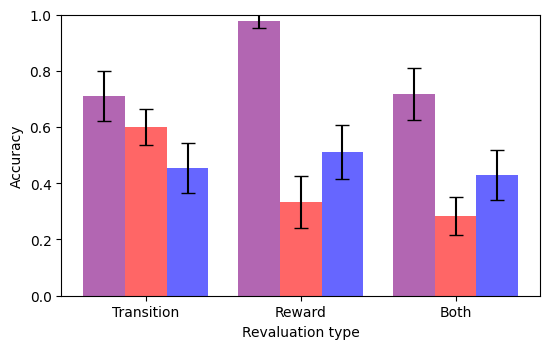

In [200]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

# Calculate accuracies
transition_accuracies_rag = [np.mean(t[0]) for t in all_transition]
transition_accuracies_mf = [np.mean(t[1]) for t in all_transition]
transition_accuracies_nc = [np.mean(t[2]) for t in all_transition]

reward_accuracies_rag = [np.mean(r[0]) for r in all_reward]
reward_accuracies_mf = [np.mean(r[1]) for r in all_reward]
reward_accuracies_nc = [np.mean(r[2]) for r in all_reward]

both_accuracies_rag = [np.mean(r[0]) for r in all_both]
both_accuracies_mf = [np.mean(r[1]) for r in all_both]
both_accuracies_nc = [np.mean(r[2]) for r in all_both]

# Calculate means
transition_means_rag = np.mean(transition_accuracies_rag)
transition_means_mf = np.mean(transition_accuracies_mf)
transition_means_nc = np.mean(transition_accuracies_nc)

reward_means_rag = np.mean(reward_accuracies_rag)
reward_means_mf = np.mean(reward_accuracies_mf)
reward_means_nc = np.mean(reward_accuracies_nc)

both_means_rag = np.mean(both_accuracies_rag)
both_means_mf = np.mean(both_accuracies_mf)
both_means_nc = np.mean(both_accuracies_nc)

# Calculate SEMs
transition_sem_rag = np.std(transition_accuracies_rag)
transition_sem_mf = np.std(transition_accuracies_mf)
transition_sem_nc = np.std(transition_accuracies_nc)

reward_sem_rag = np.std(reward_accuracies_rag)
reward_sem_mf = np.std(reward_accuracies_mf)
reward_sem_nc = np.std(reward_accuracies_nc)

both_sem_rag = np.std(both_accuracies_rag)
both_sem_mf = np.std(both_accuracies_mf)
both_sem_nc = np.std(both_accuracies_nc)

# Data to plot
labels = ['Transition', 'Reward', 'Both']

rag_means = [transition_means_rag, reward_means_rag, both_means_rag]
mf_means = [transition_means_mf, reward_means_mf, both_means_mf]
nc_means = [transition_means_nc, reward_means_nc, both_means_nc]

rag_sems = [transition_sem_rag, reward_sem_rag, both_sem_rag]
mf_sems = [transition_sem_mf, reward_sem_mf, both_sem_mf]
nc_sems = [transition_sem_nc, reward_sem_nc, both_sem_nc]

# Setting up the plot with adjusted bar positions
fig, ax = plt.subplots(figsize=(5.6, 3.6))
bar_width = 0.27  # Narrower bar width to fit three bars
index = np.arange(len(labels))
opacity = 0.6

# Adjusting the positions of the bars
bars1 = ax.bar(index - bar_width, rag_means, bar_width, alpha=opacity, color='purple', yerr=rag_sems, capsize=5, label='With RAG')
bars2 = ax.bar(index, mf_means, bar_width, alpha=opacity, color='red', yerr=mf_sems, capsize=5, label='HPC only')
bars3 = ax.bar(index + bar_width, nc_means, bar_width, alpha=opacity, color='blue', yerr=nc_sems, capsize=5, label='NC only')  # Added a third group

# Finalizing the plot
ax.set_xlabel('Revaluation type')
ax.set_ylabel('Accuracy')
#ax.set_title('Retrieval augmented generation (pre-consolidation)')
ax.set_xticks(index)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('oliver_task_rag2.png', dpi=500)
plt.show()
